# Thử nghiệm Model

# Yolov11m.pt

In [3]:
from ultralytics import YOLO

In [ ]:
!pip install albumentations opencv-python-headless pycocotools -q

In [ ]:
import os
import json
import cv2
import albumentations as A
import numpy as np
import random
import shutil
import yaml
from ultralytics import YOLO
from tqdm import tqdm
import glob

print("✅ Cài đặt và Import thành công!")

In [ ]:
from ultralytics import YOLO
import yaml

In [ ]:


# --- 1. Tạo file YAML ---
yaml_content = """
path: /kaggle/input/fisheye8k/Fisheye8K
train: train/images
val: test/images
test: test/images

names:
  0: Bus
  1: Bike
  2: Car
  3: Pedestrian
  4: Truck
"""

with open("/kaggle/working/fisheye_data.yaml", "w") as f:
    f.write(yaml_content)


In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO("yolo11m.pt") 

In [ ]:
model.train(
    data="/kaggle/working/fisheye_data.yaml",
    epochs=150,
    imgsz=640,
    batch=16,
    patience=40,
    optimizer='AdamW',
    lr0=0.002,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=5,
    cos_lr=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=2.0,
    translate=0.1,
    scale=0.4,
    shear=1.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.15,
    copy_paste=0.1,
    project="/kaggle/working/output_yolo",
    name="fisheye_yolov11m",
    exist_ok=True
)

In [ ]:
model = YOLO("/kaggle/input/yolov11/other/default/1/last.pt")
model.train(resume=True)

In [ ]:
import os

# Liệt kê tất cả file và thư mục trong /kaggle/working/
files = os.listdir('/kaggle/working/')
for f in files:
    print(f)



In [ ]:
model = YOLO("/kaggle/input/yolo11m/other/default/1/last (1).pt")
model.train(resume=True)

In [ ]:
metrics = model.val(
    data="/kaggle/working/fisheye_data.yaml",
    split="test"   # dùng test nếu có labels
)

print("Precision:", metrics.box.p)   # độ chính xác
print("Recall:", metrics.box.r)      # độ bao phủ
print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("F1-score:", metrics.box.f1)   # ✅ F1-score

In [ ]:
import pandas as pd

# Load file kết quả training
df = pd.read_csv("/kaggle/working/output_yolo/fisheye_yolov11m/results.csv")

# Tìm epoch có mAP50-95 cao nhất
best_epoch = df['metrics/mAP50-95(B)'].idxmax()
best_map = df['metrics/mAP50-95(B)'].max()


In [ ]:
print(f"Best epoch: {best_epoch}, mAP50-95: {best_map}")

In [5]:
import os
import json
from ultralytics import YOLO
from tqdm import tqdm

# --- Bước 1: Tải model với trọng số tốt nhất đã huấn luyện ---
# Đường dẫn này phải trỏ đến file weight tốt nhất trong thư mục kết quả của bạn
model_path = "/kaggle/input/yolov11m/other/default/1/last (2).pt"
print(f"Đang tải model từ: {model_path}")
model = YOLO(model_path)

Đang tải model từ: /kaggle/input/yolov11m/other/default/1/last (2).pt


In [7]:
# --- Bước 2: Hàm get_image_Id (giữ nguyên) ---
def get_image_Id(img_name):
    base_name = os.path.splitext(img_name)[0]
    sceneList = ['M', 'A', 'E', 'N']
    try:
        cameraIndx = int(base_name.split('_')[0].split('camera')[1])
        sceneIndx = sceneList.index(base_name.split('_')[1])
        frameIndx = int(base_name.split('_')[2])
        imageId = int(str(cameraIndx) + str(sceneIndx) + str(frameIndx))
        return imageId
    except (IndexError, ValueError) as e:
        print(f"Lỗi khi xử lý tên file: {img_name}. Lỗi: {e}")
        return None


# --- Bước 3: Chạy dự đoán và tạo danh sách kết quả ---
dirs = [
    "/kaggle/input/fisheye1keval/images/images",
    "/kaggle/input/fisheye1keval/images1/images1"
]

pred_list = []
print("Bắt đầu quá trình dự đoán...")

for d in dirs:
    print(f"Đang xử lý thư mục: {d}")
    results = model.predict(
        source=d,
        imgsz=640,
        conf=0.5,
        iou=0.5,
        save=False,
        stream=False,
        verbose=False
    )

    for r in tqdm(results, desc=f"Processing {os.path.basename(d)}"):
        img_name = os.path.basename(r.path)
        image_id = get_image_Id(img_name)
        if image_id is None:
            continue

        boxes_xywh = r.boxes.xywh.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy().astype(int)

        for box, score, cls in zip(boxes_xywh, scores, classes):
            x_center, y_center, w, h = box
            x_min = x_center - w / 2
            y_min = y_center - h / 2

            pred_list.append({
                "image_id": image_id,
                "category_id": int(cls),
                "bbox": [
                    round(float(x_min), 2),
                    round(float(y_min), 2),
                    round(float(w), 2),
                    round(float(h), 2)
                ],
                "score": round(float(score), 5)
            })

# --- Bước 4: Lưu kết quả ra file JSON ---
output_path = "/kaggle/working/submission.json"
print(f"\nĐã xử lý xong. Lưu kết quả vào file: {output_path}")
with open(output_path, 'w') as f:
    json.dump(pred_list, f) # Lưu file không indent để dung lượng nhỏ hơn

print(f"🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.")
print(f"Tổng số đối tượng dự đoán được: {len(pred_list)}")


Bắt đầu quá trình dự đoán...
Đang xử lý thư mục: /kaggle/input/fisheye1keval/images/images


Processing images: 100%|██████████| 431/431 [00:00<00:00, 1284.38it/s]


Đang xử lý thư mục: /kaggle/input/fisheye1keval/images1/images1


Processing images1: 100%|██████████| 569/569 [00:00<00:00, 1897.83it/s]



Đã xử lý xong. Lưu kết quả vào file: /kaggle/working/submission.json
🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.
Tổng số đối tượng dự đoán được: 15441


In [8]:
output_path = "/kaggle/working/yolo11m.json"
print(f"\nĐã xử lý xong. Lưu kết quả vào file: {output_path}")
with open(output_path, 'w') as f:
    json.dump(pred_list, f, indent=4)

print(f"🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.")
print(f"Tổng số đối tượng dự đoán được: {len(pred_list)}")


Đã xử lý xong. Lưu kết quả vào file: /kaggle/working/yolo11m.json
🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.
Tổng số đối tượng dự đoán được: 15441


# Kết quả

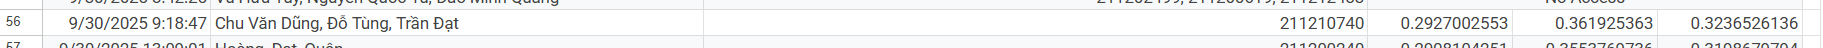

In [8]:
display(Image(filename='Submission/30092025_yolo11m.png', embed=True))

# Yolov8

In [4]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.2 MB/s eta 0:00:0000:0100:01


In [ ]:
# Cài đặt thư viện nếu chưa có
!pip install ultralytics -q

In [4]:


# --- Tạo nội dung YAML mới cho 5 lớp ---
yaml_content_5_classes = """
# Đường dẫn đến thư mục gốc của bộ dữ liệu
path: /kaggle/input/fisheye8k/Fisheye8K/

# Đường dẫn tương đối
train: train/images
val: test/images

# --- Thông tin lớp đã được cập nhật ---
nc: 5
names:
  0: Bus
  1: Bike
  2: Car
  3: Pedestrian
  4: Truck
"""

# Ghi nội dung vào file fisheye8k_aic.yaml
with open('fisheye8k_aic.yaml', 'w') as f:
    f.write(yaml_content_5_classes)

print("Tệp fisheye8k_aic.yaml đã được tạo thành công với 5 lớp.")

Tệp fisheye8k_aic.yaml đã được tạo thành công với 5 lớp.


In [ ]:
from ultralytics import YOLO

# Khởi tạo model yolov8l
model = YOLO('yolov8l.pt')

# Chạy training với bộ siêu tham số được tối ưu hóa
results = model.train(
    # --- Cấu hình cơ bản ---
    data='fisheye8k_aic.yaml',
    epochs=150,
    patience=50,
    batch=16,
    imgsz=640,
    project='runs/detect',
    name='yolov8l_fisheye_optimized_v2', # Đặt tên mới để so sánh
    seed=42,
    
    # --- Siêu tham số tối ưu ---
    optimizer='AdamW',
    lr0=0.001,           # <<< SỬA: Giảm learning rate về mức hợp lý cho AdamW
    lrf=0.01,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    # momentum=0.937,    # <<< BỎ: Không cần thiết cho AdamW
    
    # --- Augmentations ---
    degrees=5.0,         # <<< CÂN NHẮC: Giảm bớt để tránh biến dạng quá đà
    translate=0.1,
    scale=0.5,
    shear=2.0,           # <<< CÂN NHẮC: Giảm bớt để tránh biến dạng quá đà
    perspective=0.0005,
    flipud=0.0,          # <<< SỬA: Tắt lật dọc vì không thực tế
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    
    # --- Advanced Augmentations ---
    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.1,

    # --- Lưu lại các phiên bản model tốt nhất định kỳ ---
    save_period=10
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.205 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fisheye8k_aic.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kob

# Kết quả

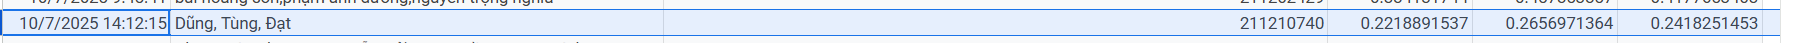

In [7]:
display(Image(filename='Submission/07102025_yolov82.png', embed=True))

# Yolo11m

# Final

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00:00:0100:01


In [4]:
# --- 1. CÀI ĐẶT VÀ IMPORTS ---
!pip install ultralytics albumentations opencv-python-headless -q
import os
import glob
import shutil
import yaml
import cv2
import random
import numpy as np
import albumentations as A
from ultralytics import YOLO
from tqdm import tqdm
print("--> Cài đặt và import thư viện thành công!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
--> Cài đặt và import thư viện thành công!


In [3]:

# --- 2. KHAI BÁO TOÀN BỘ ĐƯỜNG DẪN ---
print("--> Khai báo các đường dẫn...")

# Dữ liệu gốc
PATH_F8K_IMAGES = '/kaggle/input/fisheye8k/Fisheye8K/train/images'
PATH_F8K_LABELS = '/kaggle/input/fisheye8k/Fisheye8K/train/labels'
# ✅ ĐƯỜNG DẪN VISDRONE ĐÃ ĐƯỢC CẬP NHẬT
PATH_VISDRONE_IMAGES = '/kaggle/input/visdrone-dataset/VisDrone_Dataset/VisDrone2019-DET-train/images'
PATH_VISDRONE_YOLO_LABELS_ORIGINAL = '/kaggle/input/visdrone-dataset/VisDrone_Dataset/VisDrone2019-DET-train/labels'

# Dữ liệu sẽ được tạo ra
PATH_VISDRONE_YOLO_LABELS_MAPPED = '/kaggle/working/visdrone_yolo_labels_mapped'
PATH_SYNTHETIC_IMAGES = '/kaggle/working/synthetic_fisheye/images'
PATH_SYNTHETIC_LABELS = '/kaggle/working/synthetic_fisheye/labels'
PATH_DATA_PHASE1 = '/kaggle/working/data_phase1'
PATH_DATA_PHASE1_IMAGES = os.path.join(PATH_DATA_PHASE1, 'images')
PATH_DATA_PHASE1_LABELS = os.path.join(PATH_DATA_PHASE1, 'labels')
PATH_VIPCUP_IMAGES = '/kaggle/input/vip-cup-2020/vip_cup_2020/fisheye-day-30062020/images/train'
PATH_PSEUDO_LABELS = '/kaggle/working/pseudo_labels'
PATH_DATA_FINAL = '/kaggle/working/data_final'
PATH_DATA_FINAL_IMAGES = os.path.join(PATH_DATA_FINAL, 'images')
PATH_DATA_FINAL_LABELS = os.path.join(PATH_DATA_FINAL, 'labels')

# Model và Validation
PATH_VALIDATION_IMAGES = '/kaggle/input/fisheye8k/Fisheye8K/test/images'
PATH_TEACHER_OUTPUT = '/kaggle/working/models/teacher_yolov11m'
PATH_MODEL_A = os.path.join(PATH_TEACHER_OUTPUT, 'weights/best.pt')
PATH_FINAL_MODEL_OUTPUT = '/kaggle/working/models/final_model'
PATH_FINAL_MODEL = os.path.join(PATH_FINAL_MODEL_OUTPUT, 'weights/best.pt')

# Tạo tất cả các thư mục cần thiết
for path in [PATH_VISDRONE_YOLO_LABELS_MAPPED, PATH_SYNTHETIC_IMAGES, PATH_SYNTHETIC_LABELS,
             PATH_DATA_PHASE1_IMAGES, PATH_DATA_PHASE1_LABELS, PATH_PSEUDO_LABELS,
             PATH_DATA_FINAL_IMAGES, PATH_DATA_FINAL_LABELS]:
    os.makedirs(path, exist_ok=True)

print("--> Hoàn tất khai báo!")

--> Khai báo các đường dẫn...
--> Hoàn tất khai báo!


In [4]:
# --- HÀM 1: ÁNH XẠ LẠI CÁC LỚP CỦA VISDRONE (10+ lớp -> 5 lớp) ---
def remap_visdrone_yolo_labels(input_dir, output_dir):
    print(f"Bắt đầu ánh xạ lại nhãn từ {input_dir}...")
    label_map = {9: 0, 3: 1, 7: 1, 8: 1, 10: 1, 4: 2, 5: 2, 1: 3, 2: 3, 6: 4}
    for label_file in tqdm(os.listdir(input_dir), desc="Remapping VisDrone classes"):
        new_lines = []
        with open(os.path.join(input_dir, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                original_cls_id = int(parts[0])
                if original_cls_id in label_map:
                    new_cls_id = label_map[original_cls_id]
                    coords = " ".join(parts[1:])
                    new_lines.append(f"{new_cls_id} {coords}\n")
        if new_lines:
            with open(os.path.join(output_dir, label_file), 'w') as f: f.writelines(new_lines)

# --- HÀM 2: TẠO DỮ LIỆU MẮT CÁ NHÂN TẠO ---
def generate_synthetic_data(img_dir, label_dir, out_img_dir, out_label_dir):
    print(f"Bắt đầu tạo dữ liệu mắt cá nhân tạo...")
    transform = A.Compose([A.GridDistortion(num_steps=5, distort_limit=0.4, p=1.0)],
                          bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    for img_file in tqdm(os.listdir(img_dir), desc="Generating synthetic data"):
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
        image = cv2.imread(img_path)
        if image is None: continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes, class_labels = [], []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_labels.append(int(parts[0]))
                    coords = [float(p) for p in parts[1:]]
                    clipped_coords = np.clip(coords, 0.0, 1.0).tolist()
                    bboxes.append(clipped_coords)
        try:
            transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            transformed_image_bgr = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(out_img_dir, img_file), transformed_image_bgr)
            with open(os.path.join(out_label_dir, os.path.splitext(img_file)[0] + '.txt'), 'w') as f:
                for bbox, label in zip(transformed['bboxes'], transformed['class_labels']):
                    f.write(f"{label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
        except ValueError as e:
            print(f"\nSkipping {img_file} due to Albumentations error: {e}")
            continue

# --- THỰC THI XỬ LÝ DỮ LIỆU ---
# 1. Ánh xạ lại nhãn VisDrone
remap_visdrone_yolo_labels(PATH_VISDRONE_YOLO_LABELS_ORIGINAL, PATH_VISDRONE_YOLO_LABELS_MAPPED)

# 2. Tạo dữ liệu nhân tạo từ bộ nhãn đã được ánh xạ
generate_synthetic_data(PATH_VISDRONE_IMAGES, PATH_VISDRONE_YOLO_LABELS_MAPPED, PATH_SYNTHETIC_IMAGES, PATH_SYNTHETIC_LABELS)

# 3. Gộp dữ liệu cho Giai đoạn 1 (Fisheye8K + Synthetic VisDrone)
print("--> Gộp dữ liệu cho Giai đoạn 1...")
!cp -r {PATH_F8K_IMAGES}/* {PATH_DATA_PHASE1_IMAGES}/
!cp -r {PATH_F8K_LABELS}/* {PATH_DATA_PHASE1_LABELS}/
!cp -r {PATH_SYNTHETIC_IMAGES}/* {PATH_DATA_PHASE1_IMAGES}/
!cp -r {PATH_SYNTHETIC_LABELS}/* {PATH_DATA_PHASE1_LABELS}/
print("--> Hoàn tất Giai đoạn 1!")

Bắt đầu ánh xạ lại nhãn từ /kaggle/input/visdrone-dataset/VisDrone_Dataset/VisDrone2019-DET-train/labels...


Remapping VisDrone classes: 100%|██████████| 6471/6471 [01:00<00:00, 107.29it/s]


Bắt đầu tạo dữ liệu mắt cá nhân tạo...


Generating synthetic data:   0%|          | 5/6471 [00:18<5:44:28,  3.20s/it] 


Skipping 9999999_00259_d_0000112.jpg due to Albumentations error: Expected y_min for bbox [     0.1815 -5.0105e-07      0.2085    0.038667           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   0%|          | 11/6471 [00:39<9:09:20,  5.10s/it]


Skipping 9999951_00000_d_0000108.jpg due to Albumentations error: Expected y_min for bbox [    0.61286 -5.0012e-07     0.65357     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   0%|          | 17/6471 [00:40<2:04:35,  1.16s/it]


Skipping 9999962_00000_d_0000055.jpg due to Albumentations error: Expected y_min for bbox [    0.46857 -5.0105e-07     0.48714    0.061904           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999965_00000_d_0000048.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.22716    0.017143     0.26396           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999951_00000_d_0000071.jpg due to Albumentations error: Expected y_min for bbox [    0.31857 -4.9919e-07     0.35786    0.069797           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   0%|          | 23/6471 [00:45<1:19:23,  1.35it/s]


Skipping 0000361_00785_d_0000757.jpg due to Albumentations error: Expected y_min for bbox [    0.21765 -5.0012e-07     0.24118    0.024836           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999960_00000_d_0000039.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.45714     0.13643     0.57714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000256_00001_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.5817    0.026471     0.60523           4] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   0%|          | 32/6471 [00:52<1:08:04,  1.58it/s]


Skipping 0000072_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.8732     0.11985           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   1%|          | 44/6471 [01:05<2:27:06,  1.37s/it]


Skipping 9999955_00000_d_0000371.jpg due to Albumentations error: Expected y_min for bbox [    0.60643 -5.0012e-07     0.62143    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   1%|          | 47/6471 [01:09<2:34:35,  1.44s/it]


Skipping 9999970_00000_d_0000016.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63645    0.055078      0.6937           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   1%|          | 53/6471 [01:22<3:40:22,  2.06s/it]


Skipping 9999945_00000_d_0000024.jpg due to Albumentations error: Expected y_min for bbox [   0.097143 -5.0012e-07     0.13286    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   1%|          | 57/6471 [01:24<1:58:52,  1.11s/it]


Skipping 9999962_00000_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.76476    0.091429     0.98476           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:   1%|          | 68/6471 [01:32<42:49,  2.49it/s]  


Skipping 0000068_00460_d_0000002.jpg due to Albumentations error: Expected y_min for bbox [    0.66618 -5.0012e-07     0.67647    0.011765           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   1%|          | 72/6471 [01:35<1:00:50,  1.75it/s]


Skipping 9999937_00000_d_0000090.jpg due to Albumentations error: Expected y_min for bbox [    0.78079 -5.0012e-07     0.79332    0.019481           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   1%|          | 75/6471 [01:40<2:34:59,  1.45s/it]


Skipping 9999962_00000_d_0000060.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.82286    0.087142     0.88667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999975_00000_d_0000009.jpg due to Albumentations error: Expected y_min for bbox [    0.75643 -4.9965e-07     0.77357    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:   1%|▏         | 92/6471 [02:41<3:03:09,  1.72s/it] 


Skipping 0000279_01601_d_0000592.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.86928    0.082353     0.95294           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 9999953_00000_d_0000199.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.5165    0.042142     0.55964           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   2%|▏         | 98/6471 [02:51<2:44:58,  1.55s/it]


Skipping 9999972_00000_d_0000107.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.23562    0.033403     0.29221           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999942_00000_d_0000066.jpg due to Albumentations error: Expected y_min for bbox [    0.49571 -5.0012e-07        0.51    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   2%|▏         | 111/6471 [03:04<1:12:00,  1.47it/s]


Skipping 9999966_00000_d_0000104.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.15333    0.051429      0.2019           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   2%|▏         | 113/6471 [03:05<1:03:11,  1.68it/s]


Skipping 9999951_00000_d_0000111.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.57234     0.10714     0.67893           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   2%|▏         | 124/6471 [03:20<2:14:24,  1.27s/it]


Skipping 9999943_00000_d_0000022.jpg due to Albumentations error: Expected y_min for bbox [    0.77929 -5.0105e-07     0.83143     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   2%|▏         | 128/6471 [03:33<4:15:57,  2.42s/it]


Skipping 9999955_00000_d_0000308.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.67893    0.011428     0.70178           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:   2%|▏         | 144/6471 [03:56<2:51:14,  1.62s/it]


Skipping 0000079_01316_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07    0.057517    0.057352     0.14641           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   2%|▏         | 147/6471 [03:57<1:51:44,  1.06s/it]


Skipping 9999951_00000_d_0000183.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.90102    0.047142     0.96954           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   2%|▏         | 149/6471 [04:00<1:50:38,  1.05s/it]


Skipping 0000366_05097_d_0000802.jpg due to Albumentations error: Expected y_min for bbox [    0.58603 -5.0105e-07     0.61176    0.033987           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   2%|▏         | 152/6471 [04:01<1:22:25,  1.28it/s]


Skipping 9999990_00000_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.12429 -4.9965e-07     0.16714    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:   2%|▏         | 155/6471 [04:03<1:10:00,  1.50it/s]


Skipping 0000076_00616_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.38301     0.13235     0.65621           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   2%|▏         | 160/6471 [04:05<45:13,  2.33it/s]  


Skipping 9999937_00000_d_0000007.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.66698    0.086639     0.82653           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999951_00000_d_0000120.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.86929    0.022142     0.95431           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   3%|▎         | 166/6471 [04:11<1:52:32,  1.07s/it]


Skipping 9999962_00000_d_0000132.jpg due to Albumentations error: Expected y_min for bbox [    0.45571 -4.9919e-07     0.54071    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000058.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.30076    0.076429      0.3566           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   3%|▎         | 170/6471 [04:14<1:35:11,  1.10it/s]


Skipping 9999982_00000_d_0000195.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.42762    0.041428     0.47048           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   3%|▎         | 192/6471 [04:54<5:17:44,  3.04s/it]


Skipping 9999951_00000_d_0000191.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.001269    0.057142    0.093909           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   3%|▎         | 200/6471 [05:03<2:22:14,  1.36s/it]


Skipping 9999969_00000_d_0000024.jpg due to Albumentations error: Expected x_min for bbox [-5.0664e-07     0.62571     0.12643      0.7819           2] to be in the range [0.0, 1.0], got -5.066394805908203e-07.


Generating synthetic data:   3%|▎         | 218/6471 [05:34<3:20:49,  1.93s/it]


Skipping 9999965_00000_d_0000026.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.65228    0.051429     0.71701           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▎         | 231/6471 [05:41<53:33,  1.94it/s]  


Skipping 0000226_03490_d_0000012.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.62778    0.020312     0.67593           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   4%|▎         | 236/6471 [05:44<54:28,  1.91it/s]  


Skipping 9999942_00000_d_0000026.jpg due to Albumentations error: Expected y_min for bbox [    0.38357 -5.0291e-07     0.43643    0.091429           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:   4%|▎         | 240/6471 [05:51<2:07:50,  1.23s/it]


Skipping 0000349_04705_d_0000464.jpg due to Albumentations error: Expected y_min for bbox [    0.59412 -4.9919e-07       0.625    0.047059           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▎         | 242/6471 [05:52<1:24:28,  1.23it/s]


Skipping 0000178_00201_d_0000007.jpg due to Albumentations error: Expected y_min for bbox [  0.0088545 -4.9919e-07     0.16719    0.066666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 247/6471 [05:57<1:25:48,  1.21it/s]


Skipping 0000288_05401_d_0000809.jpg due to Albumentations error: Expected y_min for bbox [    0.82941 -5.0012e-07     0.87574    0.024836           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   4%|▍         | 249/6471 [05:59<1:32:32,  1.12it/s]


Skipping 9999970_00000_d_0000027.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.53435    0.027897     0.56202           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   4%|▍         | 251/6471 [06:01<1:41:02,  1.03it/s]


Skipping 0000134_02166_d_0000148.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07        0.95    0.059375     0.99907           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 255/6471 [06:12<2:55:56,  1.70s/it]


Skipping 0000008_03499_d_0000043.jpg due to Albumentations error: Expected y_min for bbox [    0.42647 -4.9919e-07         0.5     0.10196           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 261/6471 [06:17<1:49:44,  1.06s/it]


Skipping 0000342_01961_d_0000252.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.19477    0.047059     0.25882           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 265/6471 [06:20<1:27:02,  1.19it/s]


Skipping 9999990_00000_d_0000025.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61048    0.042142        0.64           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 280/6471 [06:29<1:36:39,  1.07it/s]


Skipping 9999970_00000_d_0000026.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49046    0.052933     0.57824           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 284/6471 [06:34<1:53:14,  1.10s/it]


Skipping 9999965_00000_d_0000059.jpg due to Albumentations error: Expected y_min for bbox [      0.145 -4.9919e-07     0.19429     0.13325           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   4%|▍         | 288/6471 [06:36<1:14:51,  1.38it/s]


Skipping 9999982_00000_d_0000114.jpg due to Albumentations error: Expected y_min for bbox [    0.91786 -5.0012e-07       0.945    0.021904           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   4%|▍         | 290/6471 [06:50<5:46:38,  3.36s/it]


Skipping 9999940_00000_d_0000052.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07    0.064721    0.032142     0.11421           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   5%|▍         | 297/6471 [07:02<3:28:56,  2.03s/it]


Skipping 9999942_00000_d_0000202.jpg due to Albumentations error: Expected y_min for bbox [       0.74 -5.0105e-07     0.80143     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   5%|▍         | 318/6471 [07:35<1:06:32,  1.54it/s]


Skipping 9999994_00000_d_0000084.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.79524     0.20214           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   5%|▍         | 323/6471 [07:46<3:29:16,  2.04s/it]


Skipping 9999951_00000_d_0000077.jpg due to Albumentations error: Expected y_min for bbox [   0.076429 -4.9919e-07     0.12214    0.054568           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   5%|▌         | 328/6471 [07:58<3:46:34,  2.21s/it]


Skipping 9999950_00000_d_0000063.jpg due to Albumentations error: Expected y_min for bbox [       0.05 -5.0012e-07    0.070714    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   5%|▌         | 332/6471 [08:00<1:57:54,  1.15s/it]


Skipping 9999940_00000_d_0000010.jpg due to Albumentations error: Expected y_min for bbox [      0.105 -5.0012e-07        0.13    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   5%|▌         | 347/6471 [08:21<2:03:44,  1.21s/it]


Skipping 9999990_00000_d_0000009.jpg due to Albumentations error: Expected y_min for bbox [    0.83929 -5.0105e-07     0.86857     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   5%|▌         | 350/6471 [08:22<1:27:04,  1.17it/s]


Skipping 9999962_00000_d_0000063.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.7181     0.13643     0.99809           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   5%|▌         | 355/6471 [08:26<1:05:56,  1.55it/s]


Skipping 9999942_00000_d_0000196.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.27333    0.056428      0.3981           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   6%|▌         | 367/6471 [08:40<1:19:29,  1.28it/s]


Skipping 9999942_00000_d_0000081.jpg due to Albumentations error: Expected y_min for bbox [    0.75357 -4.9919e-07       0.785    0.031429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   6%|▌         | 371/6471 [08:53<4:07:01,  2.43s/it]


Skipping 9999955_00000_d_0000274.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.5165    0.017143     0.54822           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   6%|▌         | 386/6471 [09:10<1:44:44,  1.03s/it]


Skipping 9999970_00000_d_0000041.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.88263    0.083691     0.99714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999964_00000_d_0000077.jpg due to Albumentations error: Expected y_min for bbox [    0.82143 -4.9919e-07     0.88857    0.081905           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   6%|▌         | 395/6471 [09:37<3:17:15,  1.95s/it]


Skipping 0000361_00589_d_0000756.jpg due to Albumentations error: Expected y_min for bbox [    0.40147 -4.9919e-07     0.43015    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   6%|▌         | 397/6471 [09:38<1:55:51,  1.14s/it]


Skipping 9999967_00000_d_0000059.jpg due to Albumentations error: Expected y_min for bbox [    0.89786 -5.0012e-07       0.935    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   6%|▌         | 403/6471 [09:44<1:21:55,  1.23it/s]


Skipping 9999999_00815_d_0000373.jpg due to Albumentations error: Expected y_min for bbox [     0.9495 -5.0012e-07       0.971    0.024666           4] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   6%|▋         | 406/6471 [09:46<1:10:39,  1.43it/s]


Skipping 0000220_03847_d_0000012.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.52778    0.053125     0.61944           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   6%|▋         | 408/6471 [09:51<2:09:59,  1.29s/it]


Skipping 9999981_00000_d_0000088.jpg due to Albumentations error: Expected y_min for bbox [      0.595 -4.9919e-07        0.63    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   6%|▋         | 416/6471 [09:53<31:39,  3.19it/s]  


Skipping 9999942_00000_d_0000167.jpg due to Albumentations error: Expected y_min for bbox [       0.48 -5.0012e-07     0.51714    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999937_00000_d_0000018.jpg due to Albumentations error: Expected y_min for bbox [    0.82214 -4.9965e-07     0.85357    0.011428           3] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:   7%|▋         | 432/6471 [10:35<7:19:15,  4.36s/it] 


Skipping 9999997_00000_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.60095     0.11714     0.70191           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   7%|▋         | 451/6471 [11:06<4:27:21,  2.66s/it]


Skipping 9999969_00000_d_0000011.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.67333     0.14214      0.7619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   7%|▋         | 459/6471 [11:22<1:43:01,  1.03s/it]


Skipping 9999972_00000_d_0000016.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.11039    0.061065     0.16605           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   7%|▋         | 465/6471 [11:26<1:21:16,  1.23it/s]


Skipping 9999942_00000_d_0000083.jpg due to Albumentations error: Expected y_min for bbox [    0.60857 -5.0105e-07        0.64    0.061904           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   7%|▋         | 467/6471 [11:28<1:20:29,  1.24it/s]


Skipping 0000227_00235_d_0000002.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.30926    0.015624     0.34167           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   7%|▋         | 474/6471 [11:31<51:24,  1.94it/s]  


Skipping 9999964_00000_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07    0.064762    0.062142     0.12381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   8%|▊         | 489/6471 [11:44<1:33:27,  1.07it/s]


Skipping 9999964_00000_d_0000071.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.24571    0.037143         0.3           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   8%|▊         | 493/6471 [11:48<1:47:36,  1.08s/it]


Skipping 9999997_00000_d_0000005.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70476    0.031429     0.72571           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   8%|▊         | 506/6471 [12:03<2:00:55,  1.22s/it]


Skipping 9999974_00000_d_0000015.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.34416    0.047495     0.41466           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   8%|▊         | 509/6471 [12:09<2:33:13,  1.54s/it]


Skipping 9999975_00000_d_0000023.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.58381    0.017143     0.61714           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   8%|▊         | 515/6471 [12:12<1:16:55,  1.29it/s]


Skipping 0000126_00054_d_0000124.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07      0.7787    0.032812     0.81389           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 0000325_00201_d_0000663.jpg due to Albumentations error: Expected y_min for bbox [    0.44118 -5.0012e-07     0.44779      0.0183           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   8%|▊         | 519/6471 [12:18<2:02:48,  1.24s/it]


Skipping 9999972_00000_d_0000022.jpg due to Albumentations error: Expected y_min for bbox [    0.64509 -4.9919e-07     0.70825     0.11224           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   8%|▊         | 531/6471 [12:48<6:16:05,  3.80s/it] 


Skipping 9999955_00000_d_0000109.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.17766    0.052143     0.24365           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   8%|▊         | 538/6471 [12:52<1:25:53,  1.15it/s]


Skipping 9999955_00000_d_0000381.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.27411    0.017143     0.30076           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   9%|▊         | 551/6471 [13:02<1:46:41,  1.08s/it]


Skipping 9999942_00000_d_0000155.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.23714    0.082143     0.35333           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   9%|▊         | 556/6471 [13:04<59:50,  1.65it/s]  


Skipping 0000288_05601_d_0000810.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.67712    0.086764     0.87059           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   9%|▊         | 563/6471 [13:12<1:27:30,  1.13it/s]


Skipping 0000342_02353_d_0000254.jpg due to Albumentations error: Expected y_min for bbox [    0.14926 -5.0105e-07     0.19706    0.033987           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:   9%|▉         | 580/6471 [13:34<3:46:41,  2.31s/it]


Skipping 9999962_00000_d_0000092.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.6219     0.13214     0.93809           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   9%|▉         | 593/6471 [13:49<57:02,  1.72it/s]  


Skipping 9999942_00000_d_0000143.jpg due to Albumentations error: Expected y_min for bbox [    0.61357 -4.9919e-07     0.64286    0.046666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   9%|▉         | 610/6471 [14:16<2:35:06,  1.59s/it]


Skipping 9999955_00000_d_0000418.jpg due to Albumentations error: Expected y_min for bbox [    0.58571 -5.0012e-07     0.59857    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:   9%|▉         | 612/6471 [14:16<1:39:18,  1.02s/it]


Skipping 9999962_00000_d_0000031.jpg due to Albumentations error: Expected y_min for bbox [    0.58857 -4.9919e-07     0.61857    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:   9%|▉         | 614/6471 [14:17<1:07:26,  1.45it/s]


Skipping 9999997_00000_d_0000033.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.56476    0.066428        0.64           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  10%|▉         | 626/6471 [14:33<1:31:43,  1.06it/s]


Skipping 9999951_00000_d_0000032.jpg due to Albumentations error: Expected y_min for bbox [    0.61929 -5.0012e-07     0.63429    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999951_00000_d_0000096.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.59391    0.011428      0.6231           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  10%|▉         | 634/6471 [14:38<50:01,  1.94it/s]  


Skipping 9999951_00000_d_0000284.jpg due to Albumentations error: Expected y_min for bbox [    0.45857 -4.9919e-07     0.47214    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000257_03360_d_0000058.jpg due to Albumentations error: Expected y_min for bbox [    0.46471 -5.0012e-07     0.47647    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999972_00000_d_0000046.jpg due to Albumentations error: Expected y_min for bbox [    0.31107 -4.9919e-07     0.33873    0.055659           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  10%|▉         | 646/6471 [14:45<1:01:40,  1.57it/s]


Skipping 9999942_00000_d_0000038.jpg due to Albumentations error: Expected y_min for bbox [    0.21286 -5.0012e-07     0.28714    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000281_02001_d_0000637.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07    0.082353     0.01397      0.1268           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  10%|█         | 653/6471 [15:14<6:23:25,  3.95s/it]


Skipping 9999937_00000_d_0000223.jpg due to Albumentations error: Expected y_min for bbox [    0.38518 -4.9919e-07      0.4619    0.050092           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  10%|█         | 664/6471 [15:25<1:47:21,  1.11s/it]


Skipping 0000342_00981_d_0000247.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.62091    0.034558     0.66797           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999982_00000_d_0000070.jpg due to Albumentations error: Expected y_min for bbox [    0.47214 -4.9965e-07     0.47643    0.011428           0] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  10%|█         | 668/6471 [15:27<1:16:13,  1.27it/s]


Skipping 9999969_00000_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-5.0664e-07     0.77905     0.16214     0.98095           1] to be in the range [0.0, 1.0], got -5.066394805908203e-07.


Generating synthetic data:  10%|█         | 674/6471 [15:29<45:45,  2.11it/s]  


Skipping 9999982_00000_d_0000149.jpg due to Albumentations error: Expected y_min for bbox [    0.33786 -5.0012e-07     0.35214    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  11%|█         | 685/6471 [15:36<44:20,  2.17it/s]  


Skipping 9999965_00000_d_0000060.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.71574    0.026428     0.80076           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  11%|█         | 717/6471 [16:05<1:22:54,  1.16it/s]


Skipping 0000270_03401_d_0000370.jpg due to Albumentations error: Expected y_min for bbox [    0.54485 -5.0012e-07     0.55662    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  11%|█         | 722/6471 [16:24<4:51:16,  3.04s/it]


Skipping 9999966_00000_d_0000047.jpg due to Albumentations error: Expected y_min for bbox [    0.41714 -5.0105e-07     0.45714    0.041905           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  11%|█▏        | 735/6471 [16:37<2:09:28,  1.35s/it]


Skipping 9999972_00000_d_0000113.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.87198    0.022964     0.95918           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999951_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [       0.37 -5.0012e-07     0.39143    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  12%|█▏        | 745/6471 [16:48<1:56:38,  1.22s/it]


Skipping 9999951_00000_d_0000048.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.58376    0.036428     0.62056           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  12%|█▏        | 752/6471 [16:53<1:18:37,  1.21it/s]


Skipping 9999975_00000_d_0000029.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.34857    0.011428      0.3619           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  12%|█▏        | 757/6471 [17:01<2:26:18,  1.54s/it]


Skipping 0000126_02904_d_0000127.jpg due to Albumentations error: Expected y_min for bbox [    0.81146 -4.9919e-07     0.85313    0.064815           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  12%|█▏        | 762/6471 [17:06<1:35:03,  1.00it/s]


Skipping 9999989_00000_d_0000011.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.41809     0.12214     0.54381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  12%|█▏        | 773/6471 [17:44<2:49:34,  1.79s/it] 


Skipping 9999969_00000_d_0000048.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.38095    0.057142     0.41048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000142_02858_d_0000037.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.33889    0.020312     0.35463           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  12%|█▏        | 776/6471 [17:52<3:28:24,  2.20s/it]


Skipping 9999966_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.95143    0.071429     0.99905           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  12%|█▏        | 781/6471 [17:58<2:25:18,  1.53s/it]


Skipping 9999955_00000_d_0000059.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.51142    0.027142     0.56853           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  12%|█▏        | 790/6471 [18:03<36:51,  2.57it/s]  


Skipping 9999981_00000_d_0000040.jpg due to Albumentations error: Expected y_min for bbox [    0.53214 -5.0105e-07     0.55214    0.052381           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  12%|█▏        | 802/6471 [18:11<51:29,  1.84it/s]  


Skipping 9999998_00360_d_0000312.jpg due to Albumentations error: Expected y_min for bbox [      0.772 -4.9965e-07       0.778    0.014666           3] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  13%|█▎        | 814/6471 [18:36<2:26:17,  1.55s/it]


Skipping 9999953_00000_d_0000019.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.39721    0.056428     0.48096           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  13%|█▎        | 816/6471 [18:37<1:34:26,  1.00s/it]


Skipping 9999967_00000_d_0000038.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.34667     0.14214      0.5781           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  13%|█▎        | 820/6471 [18:40<1:38:08,  1.04s/it]


Skipping 0000352_05293_d_0000566.jpg due to Albumentations error: Expected y_min for bbox [    0.55588 -5.0012e-07     0.56912    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000227.jpg due to Albumentations error: Expected y_min for bbox [   0.089286 -4.9919e-07     0.13429    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  13%|█▎        | 826/6471 [18:55<2:54:02,  1.85s/it]


Skipping 0000325_04201_d_0000683.jpg due to Albumentations error: Expected y_min for bbox [     0.4875 -5.0012e-07     0.49779    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  13%|█▎        | 833/6471 [19:00<1:28:00,  1.07it/s]


Skipping 9999942_00000_d_0000073.jpg due to Albumentations error: Expected y_min for bbox [    0.15429 -5.0105e-07     0.19643     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  13%|█▎        | 842/6471 [19:10<1:40:10,  1.07s/it]


Skipping 9999999_00338_d_0000148.jpg due to Albumentations error: Expected y_min for bbox [     0.3635 -4.9919e-07      0.3905    0.054667           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  13%|█▎        | 852/6471 [19:18<40:30,  2.31it/s]  


Skipping 9999955_00000_d_0000153.jpg due to Albumentations error: Expected y_min for bbox [    0.42071 -5.0012e-07     0.44214    0.030456           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  13%|█▎        | 866/6471 [19:37<2:59:53,  1.93s/it]


Skipping 9999940_00000_d_0000035.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.73731    0.031429     0.76396           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  14%|█▎        | 881/6471 [19:56<2:01:04,  1.30s/it]


Skipping 9999981_00000_d_0000086.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.30952    0.022142     0.34571           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.75333    0.021428     0.79429           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  14%|█▎        | 886/6471 [19:57<49:03,  1.90it/s]  


Skipping 9999942_00000_d_0000179.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.34381    0.022142     0.39143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  14%|█▎        | 889/6471 [20:00<1:07:10,  1.39it/s]


Skipping 0000071_03470_d_0000005.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.12941    0.036765     0.20915           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999999_00642_d_0000292.jpg due to Albumentations error: Expected y_min for bbox [     0.7795 -4.9989e-07       0.784   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.

Skipping 9999955_00000_d_0000259.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.22969    0.061429     0.29315           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  14%|█▍        | 901/6471 [20:05<32:09,  2.89it/s]  


Skipping 9999981_00000_d_0000123.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.26476    0.051429     0.35143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  14%|█▍        | 915/6471 [20:33<1:54:18,  1.23s/it]


Skipping 9999942_00000_d_0000183.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.10667    0.026428     0.13048           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  14%|█▍        | 916/6471 [20:46<6:23:09,  4.14s/it]


Skipping 9999942_00000_d_0000031.jpg due to Albumentations error: Expected y_min for bbox [       0.43 -5.0012e-07     0.46286    0.026666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  14%|█▍        | 931/6471 [21:18<3:59:21,  2.59s/it]


Skipping 0000270_02601_d_0000366.jpg due to Albumentations error: Expected y_min for bbox [    0.23676 -5.0012e-07     0.24412    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  15%|█▍        | 939/6471 [21:21<53:53,  1.71it/s]  


Skipping 9999943_00000_d_0000011.jpg due to Albumentations error: Expected y_min for bbox [    0.26857 -5.0012e-07     0.28143    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  15%|█▍        | 947/6471 [21:29<57:39,  1.60it/s]  


Skipping 9999991_00000_d_0000021.jpg due to Albumentations error: Expected y_min for bbox [    0.92714 -4.9919e-07     0.96714    0.046666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  15%|█▍        | 955/6471 [21:54<4:08:45,  2.71s/it]


Skipping 0000342_00589_d_0000245.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.54771    0.038971     0.61046           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  15%|█▍        | 959/6471 [22:17<7:11:40,  4.70s/it]


Skipping 9999964_00000_d_0000022.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.39714    0.021428     0.43524           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  15%|█▍        | 963/6471 [22:21<3:18:50,  2.17s/it]


Skipping 9999998_00374_d_0000326.jpg due to Albumentations error: Expected y_min for bbox [     0.3545 -5.0012e-07      0.4125    0.024666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  15%|█▌        | 971/6471 [22:53<3:04:22,  2.01s/it]


Skipping 9999964_00000_d_0000068.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.64667    0.026428     0.72762           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  15%|█▌        | 977/6471 [22:56<1:07:35,  1.35it/s]


Skipping 9999967_00000_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.49357 -4.9919e-07     0.51143    0.037143           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  15%|█▌        | 1003/6471 [23:38<1:54:50,  1.26s/it]


Skipping 9999966_00000_d_0000031.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.57143    0.057142     0.62095           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  16%|█▌        | 1005/6471 [23:42<2:23:01,  1.57s/it]


Skipping 9999981_00000_d_0000156.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.21143    0.027142     0.26381           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  16%|█▌        | 1015/6471 [23:57<2:56:49,  1.94s/it]


Skipping 9999998_00391_d_0000343.jpg due to Albumentations error: Expected y_min for bbox [     0.7965 -4.9919e-07       0.813    0.032667           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  16%|█▌        | 1024/6471 [24:06<1:05:43,  1.38it/s]


Skipping 0000281_00601_d_0000631.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.9268    0.084559           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  16%|█▌        | 1036/6471 [24:16<42:54,  2.11it/s]  


Skipping 9999972_00000_d_0000065.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.94156    0.020877     0.99629           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999999_00725_d_0000330.jpg due to Albumentations error: Expected y_min for bbox [     0.3535 -4.9919e-07       0.415     0.15667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  16%|█▌        | 1037/6471 [24:19<1:33:27,  1.03s/it]


Skipping 9999965_00000_d_0000047.jpg due to Albumentations error: Expected y_min for bbox [    0.83143 -5.0012e-07     0.85143    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999960_00000_d_0000042.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.68095    0.091429     0.86095           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  16%|█▋        | 1059/6471 [24:44<1:45:01,  1.16s/it]


Skipping 9999990_00000_d_0000032.jpg due to Albumentations error: Expected y_min for bbox [    0.47714 -5.0012e-07     0.49214    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  16%|█▋        | 1063/6471 [24:49<1:35:04,  1.05s/it]


Skipping 9999945_00000_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.87929 -4.9989e-07       0.885   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  17%|█▋        | 1068/6471 [24:54<1:42:43,  1.14s/it]


Skipping 9999937_00000_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.9295   0.0067845     0.94249           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  17%|█▋        | 1072/6471 [24:55<53:45,  1.67it/s]  


Skipping 9999962_00000_d_0000064.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.15619    0.026428         0.2           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  17%|█▋        | 1077/6471 [25:02<2:03:36,  1.38s/it]


Skipping 9999951_00000_d_0000302.jpg due to Albumentations error: Expected y_min for bbox [    0.44143 -5.0012e-07     0.46286    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  17%|█▋        | 1079/6471 [25:04<1:40:50,  1.12s/it]


Skipping 9999942_00000_d_0000089.jpg due to Albumentations error: Expected y_min for bbox [    0.34929 -4.9919e-07     0.38571     0.07238           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  17%|█▋        | 1100/6471 [25:29<1:08:22,  1.31it/s]


Skipping 9999998_00337_d_0000289.jpg due to Albumentations error: Expected y_min for bbox [      0.212 -4.9919e-07       0.316    0.050666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  17%|█▋        | 1105/6471 [25:29<26:48,  3.34it/s]  


Skipping 9999943_00000_d_0000036.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.46191    0.037143     0.51143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  17%|█▋        | 1113/6471 [25:43<3:22:00,  2.26s/it]


Skipping 0000008_02999_d_0000042.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.52288     0.17206     0.85359           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  17%|█▋        | 1117/6471 [25:44<1:18:05,  1.14it/s]


Skipping 9999998_00228_d_0000184.jpg due to Albumentations error: Expected y_min for bbox [      0.366 -5.0012e-07      0.3925    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  17%|█▋        | 1118/6471 [25:46<1:42:15,  1.15s/it]


Skipping 9999997_00000_d_0000044.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.80286    0.026428     0.84476           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  17%|█▋        | 1132/6471 [26:00<1:56:03,  1.30s/it]


Skipping 9999955_00000_d_0000320.jpg due to Albumentations error: Expected y_min for bbox [   0.057857 -5.0012e-07    0.079286    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1134/6471 [26:03<1:50:24,  1.24s/it]


Skipping 0000007_05499_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.62132 -5.0105e-07      0.6625    0.033987           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 0000342_03333_d_0000259.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.22876     0.05147      0.2902           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  18%|█▊        | 1137/6471 [26:05<1:32:03,  1.04s/it]


Skipping 9999965_00000_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.40482    0.022142     0.43401           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1144/6471 [26:07<33:11,  2.67it/s]  


Skipping 0000076_03689_d_0000012.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.13856    0.069853     0.23922           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999994_00000_d_0000071.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.62762    0.012142     0.63905           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1151/6471 [26:24<2:36:54,  1.77s/it]


Skipping 0000358_01765_d_0000689.jpg due to Albumentations error: Expected y_min for bbox [    0.52868 -5.0012e-07     0.55294      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1174/6471 [26:58<2:12:41,  1.50s/it]


Skipping 9999962_00000_d_0000067.jpg due to Albumentations error: Expected y_min for bbox [    0.35571 -4.9919e-07     0.39571    0.037143           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  18%|█▊        | 1176/6471 [26:59<1:26:43,  1.02it/s]


Skipping 9999942_00000_d_0000108.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.48381     0.22143     0.70286           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  18%|█▊        | 1179/6471 [27:00<1:03:36,  1.39it/s]


Skipping 9999975_00000_d_0000027.jpg due to Albumentations error: Expected y_min for bbox [    0.23786 -4.9965e-07     0.25714    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  18%|█▊        | 1187/6471 [27:16<3:23:45,  2.31s/it]


Skipping 9999955_00000_d_0000251.jpg due to Albumentations error: Expected y_min for bbox [   0.031429 -5.0012e-07    0.047143    0.020305           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1194/6471 [27:31<3:40:25,  2.51s/it]


Skipping 9999951_00000_d_0000090.jpg due to Albumentations error: Expected y_min for bbox [      0.405 -5.0012e-07     0.42929    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  18%|█▊        | 1196/6471 [27:34<2:50:26,  1.94s/it]


Skipping 9999951_00000_d_0000110.jpg due to Albumentations error: Expected y_min for bbox [    0.91786 -5.0105e-07     0.96429    0.032995           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 0000326_00001_d_0000696.jpg due to Albumentations error: Expected y_min for bbox [    0.77353 -4.9919e-07     0.87353    0.079738           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  19%|█▊        | 1213/6471 [27:51<2:04:07,  1.42s/it]


Skipping 9999967_00000_d_0000034.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.21238    0.037143     0.26286           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  19%|█▉        | 1227/6471 [28:03<1:47:07,  1.23s/it]


Skipping 9999940_00000_d_0000021.jpg due to Albumentations error: Expected y_min for bbox [       0.61 -5.0012e-07     0.62071    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  19%|█▉        | 1233/6471 [28:04<32:23,  2.70it/s]  


Skipping 9999999_00139_d_0000054.jpg due to Albumentations error: Expected y_min for bbox [     0.3325 -4.9989e-07      0.3395   0.0046665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.

Skipping 9999955_00000_d_0000352.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.5203    0.012142     0.53173           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  19%|█▉        | 1239/6471 [28:12<1:09:48,  1.25it/s]


Skipping 0000288_04401_d_0000805.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.18954    0.094852     0.38039           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000214_01218_d_0000251.jpg due to Albumentations error: Expected y_min for bbox [    0.35147 -4.9919e-07     0.37721    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  19%|█▉        | 1240/6471 [28:15<1:45:47,  1.21s/it]


Skipping 0000349_02157_d_0000451.jpg due to Albumentations error: Expected y_min for bbox [    0.93235 -4.9919e-07     0.97059    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999962_00000_d_0000085.jpg due to Albumentations error: Expected y_min for bbox [    0.25143 -4.9919e-07        0.32    0.071429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  19%|█▉        | 1246/6471 [28:19<1:20:14,  1.09it/s]


Skipping 9999951_00000_d_0000320.jpg due to Albumentations error: Expected y_min for bbox [    0.71286 -4.9919e-07        0.78     0.13325           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  19%|█▉        | 1252/6471 [28:23<54:36,  1.59it/s]  


Skipping 9999951_00000_d_0000024.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.58249    0.031429     0.65228           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  20%|█▉        | 1263/6471 [28:34<32:17,  2.69it/s]  


Skipping 9999951_00000_d_0000274.jpg due to Albumentations error: Expected y_min for bbox [    0.70429 -5.0012e-07     0.72429    0.027918           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  20%|█▉        | 1271/6471 [28:41<49:07,  1.76it/s]  


Skipping 9999945_00000_d_0000122.jpg due to Albumentations error: Expected y_min for bbox [    0.65857 -4.9965e-07     0.68429    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  20%|█▉        | 1288/6471 [29:16<3:30:20,  2.43s/it]


Skipping 9999999_00446_d_0000198.jpg due to Albumentations error: Expected y_min for bbox [       0.56 -4.9965e-07       0.577    0.014666           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  20%|██        | 1303/6471 [29:56<1:49:12,  1.27s/it]


Skipping 0000072_00137_d_0000002.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.41569    0.072058     0.56078           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  20%|██        | 1305/6471 [29:57<1:24:59,  1.01it/s]


Skipping 9999999_00155_d_0000062.jpg due to Albumentations error: Expected y_min for bbox [      0.329 -4.9919e-07       0.357    0.056667           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  20%|██        | 1307/6471 [30:01<1:58:23,  1.38s/it]


Skipping 0000243_00500_d_0000002.jpg due to Albumentations error: Expected y_min for bbox [    0.54271 -4.9919e-07     0.55521    0.016666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  20%|██        | 1313/6471 [30:11<3:29:19,  2.44s/it]


Skipping 9999951_00000_d_0000289.jpg due to Albumentations error: Expected y_min for bbox [    0.42643 -5.0105e-07     0.44214    0.032995           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  20%|██        | 1326/6471 [30:39<1:47:36,  1.25s/it]


Skipping 9999942_00000_d_0000204.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07    0.054286    0.061429    0.085715           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  21%|██        | 1334/6471 [30:54<3:13:35,  2.26s/it]


Skipping 9999951_00000_d_0000247.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.18401    0.057142     0.30964           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  21%|██        | 1339/6471 [30:58<2:00:35,  1.41s/it]


Skipping 9999943_00000_d_0000016.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.22762    0.031429     0.26952           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  21%|██        | 1344/6471 [31:02<1:39:26,  1.16s/it]


Skipping 9999991_00000_d_0000011.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.32667    0.031429      0.3819           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  21%|██        | 1349/6471 [31:08<1:58:38,  1.39s/it]


Skipping 9999998_00376_d_0000328.jpg due to Albumentations error: Expected y_min for bbox [      0.381 -5.0012e-07      0.4385    0.022666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  21%|██        | 1358/6471 [31:16<48:03,  1.77it/s]  


Skipping 9999951_00000_d_0000148.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61294    0.052143     0.72208           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  21%|██        | 1364/6471 [31:21<1:44:43,  1.23s/it]


Skipping 9999942_00000_d_0000064.jpg due to Albumentations error: Expected y_min for bbox [      0.375 -5.0012e-07     0.38714    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999972_00000_d_0000099.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.43599    0.088205     0.51113           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  21%|██        | 1368/6471 [31:24<1:10:19,  1.21it/s]


Skipping 9999945_00000_d_0000174.jpg due to Albumentations error: Expected y_min for bbox [    0.19929 -5.0012e-07     0.21786    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  21%|██        | 1371/6471 [31:25<50:08,  1.70it/s]  


Skipping 9999943_00000_d_0000048.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07        0.78    0.016429      0.8181           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  21%|██▏       | 1383/6471 [31:48<3:04:15,  2.17s/it]


Skipping 9999962_00000_d_0000088.jpg due to Albumentations error: Expected y_min for bbox [  0.0014285 -4.9919e-07    0.038571    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  22%|██▏       | 1400/6471 [32:04<1:13:05,  1.16it/s]


Skipping 9999991_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07        0.08    0.026428     0.11714           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  22%|██▏       | 1410/6471 [32:19<1:59:59,  1.42s/it]


Skipping 0000334_00001_d_0000021.jpg due to Albumentations error: Expected y_min for bbox [    0.45735 -4.9919e-07     0.47353    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  22%|██▏       | 1418/6471 [32:24<58:40,  1.44it/s]  


Skipping 9999945_00000_d_0000040.jpg due to Albumentations error: Expected y_min for bbox [    0.71143 -5.0105e-07     0.77857     0.03238           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  22%|██▏       | 1420/6471 [32:27<1:27:13,  1.04s/it]


Skipping 9999955_00000_d_0000112.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.22843    0.091429     0.34772           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  22%|██▏       | 1423/6471 [32:34<2:08:41,  1.53s/it]


Skipping 9999951_00000_d_0000146.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.12817    0.022142     0.16498           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  22%|██▏       | 1425/6471 [32:34<1:24:42,  1.01s/it]


Skipping 9999964_00000_d_0000061.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.83429    0.096428      0.9619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000312.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.76269    0.017143     0.78553           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  22%|██▏       | 1438/6471 [32:46<2:41:36,  1.93s/it]


Skipping 0000357_04509_d_0000679.jpg due to Albumentations error: Expected y_min for bbox [    0.60147 -4.9919e-07     0.63382    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999950_00000_d_0000013.jpg due to Albumentations error: Expected y_min for bbox [    0.55929 -4.9919e-07     0.66786    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  22%|██▏       | 1443/6471 [32:50<1:40:09,  1.20s/it]


Skipping 9999940_00000_d_0000038.jpg due to Albumentations error: Expected y_min for bbox [    0.49357 -5.0012e-07     0.50429    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  22%|██▏       | 1450/6471 [33:09<3:42:39,  2.66s/it]


Skipping 9999974_00000_d_0000044.jpg due to Albumentations error: Expected y_min for bbox [     0.2928 -4.9919e-07     0.33246    0.055659           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  22%|██▏       | 1452/6471 [33:10<2:23:31,  1.72s/it]


Skipping 9999994_00000_d_0000025.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.81333    0.041428      0.8619           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  23%|██▎       | 1456/6471 [33:12<1:26:07,  1.03s/it]


Skipping 9999942_00000_d_0000150.jpg due to Albumentations error: Expected y_min for bbox [       0.47 -4.9919e-07     0.50286    0.051429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1472/6471 [33:46<3:36:20,  2.60s/it]


Skipping 0000133_00078_d_0000141.jpg due to Albumentations error: Expected y_min for bbox [    0.44531 -4.9919e-07     0.45938    0.037963           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1474/6471 [33:47<2:23:38,  1.72s/it]


Skipping 9999981_00000_d_0000127.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.2381    0.051429        0.28           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1491/6471 [34:11<2:12:52,  1.60s/it]


Skipping 9999942_00000_d_0000189.jpg due to Albumentations error: Expected y_min for bbox [    0.41786 -4.9919e-07        0.46    0.081905           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1499/6471 [34:15<44:33,  1.86it/s]  


Skipping 9999998_00254_d_0000208.jpg due to Albumentations error: Expected y_min for bbox [      0.613 -5.0012e-07       0.633    0.012667           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999999_00147_d_0000058.jpg due to Albumentations error: Expected y_min for bbox [     0.2305 -4.9919e-07       0.298    0.046666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1500/6471 [34:16<51:19,  1.61it/s]


Skipping 9999998_00347_d_0000299.jpg due to Albumentations error: Expected y_min for bbox [     0.7775 -4.9989e-07       0.785   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  23%|██▎       | 1507/6471 [34:18<34:49,  2.38it/s]


Skipping 9999967_00000_d_0000025.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.061904    0.052143     0.11333           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  23%|██▎       | 1511/6471 [34:28<2:09:41,  1.57s/it]


Skipping 0000068_04169_d_0000014.jpg due to Albumentations error: Expected y_min for bbox [    0.77573 -5.0012e-07     0.81323    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  23%|██▎       | 1513/6471 [34:30<1:51:46,  1.35s/it]


Skipping 9999945_00000_d_0000039.jpg due to Albumentations error: Expected y_min for bbox [    0.38929 -5.0105e-07        0.42     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  23%|██▎       | 1516/6471 [34:31<1:15:17,  1.10it/s]


Skipping 9999984_00000_d_0000137.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.35143    0.026428     0.36857           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  24%|██▎       | 1527/6471 [34:47<3:03:11,  2.22s/it]


Skipping 9999960_00000_d_0000175.jpg due to Albumentations error: Expected y_min for bbox [    0.42714 -5.0012e-07     0.47214    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  24%|██▎       | 1532/6471 [34:55<2:24:49,  1.76s/it]


Skipping 0000338_01765_d_0000147.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.55294    0.038971     0.62484           4] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  24%|██▍       | 1537/6471 [35:14<3:55:28,  2.86s/it]


Skipping 9999943_00000_d_0000045.jpg due to Albumentations error: Expected y_min for bbox [    0.31071 -5.0012e-07       0.335    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  24%|██▍       | 1546/6471 [35:25<1:30:56,  1.11s/it]


Skipping 0000352_06469_d_0000572.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.85752    0.032352     0.91373           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  24%|██▍       | 1559/6471 [35:35<1:12:25,  1.13it/s]


Skipping 9999951_00000_d_0000088.jpg due to Albumentations error: Expected y_min for bbox [    0.68857 -5.0012e-07     0.70214    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  24%|██▍       | 1578/6471 [36:06<2:13:03,  1.63s/it]


Skipping 9999960_00000_d_0000015.jpg due to Albumentations error: Expected y_min for bbox [    0.36429 -4.9919e-07     0.43714    0.081905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000406.jpg due to Albumentations error: Expected y_min for bbox [    0.93429 -4.9919e-07     0.96071    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  24%|██▍       | 1580/6471 [36:07<1:31:26,  1.12s/it]


Skipping 9999999_00402_d_0000176.jpg due to Albumentations error: Expected y_min for bbox [     0.5085 -5.0012e-07       0.518    0.022666           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  24%|██▍       | 1584/6471 [36:14<1:49:10,  1.34s/it]


Skipping 0000257_02072_d_0000054.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.75817     0.05147     0.96471           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  25%|██▍       | 1589/6471 [36:18<1:26:38,  1.06s/it]


Skipping 9999965_00000_d_0000067.jpg due to Albumentations error: Expected y_min for bbox [    0.89286 -4.9919e-07       0.925    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  25%|██▍       | 1596/6471 [36:24<1:25:52,  1.06s/it]


Skipping 9999962_00000_d_0000130.jpg due to Albumentations error: Expected y_min for bbox [    0.86143 -4.9919e-07       0.905    0.077142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  25%|██▍       | 1602/6471 [36:28<46:09,  1.76it/s]  


Skipping 9999984_00000_d_0000071.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.44762    0.046429     0.48286           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  25%|██▌       | 1634/6471 [37:14<1:29:58,  1.12s/it]


Skipping 0000059_01886_d_0000114.jpg due to Albumentations error: Expected y_min for bbox [    0.70521 -5.0012e-07     0.72292    0.014814           4] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  25%|██▌       | 1636/6471 [37:15<1:05:41,  1.23it/s]


Skipping 9999997_00000_d_0000040.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.92571    0.032142     0.99048           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  25%|██▌       | 1639/6471 [37:17<1:02:35,  1.29it/s]


Skipping 9999999_00107_d_0000038.jpg due to Albumentations error: Expected y_min for bbox [     0.8295 -5.0012e-07      0.8595    0.022666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  25%|██▌       | 1643/6471 [37:17<29:39,  2.71it/s]  


Skipping 0000309_01201_d_0000339.jpg due to Albumentations error: Expected y_min for bbox [   0.040441 -5.0012e-07    0.078676    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  25%|██▌       | 1647/6471 [37:19<32:28,  2.48it/s]


Skipping 9999942_00000_d_0000025.jpg due to Albumentations error: Expected y_min for bbox [    0.22071 -4.9919e-07     0.26429    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  26%|██▌       | 1657/6471 [37:30<47:00,  1.71it/s]  


Skipping 9999955_00000_d_0000344.jpg due to Albumentations error: Expected y_min for bbox [    0.57571 -4.9919e-07     0.61214    0.091371           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999962_00000_d_0000128.jpg due to Albumentations error: Expected y_min for bbox [      0.415 -4.9919e-07     0.46857    0.077142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  26%|██▌       | 1659/6471 [37:33<1:23:00,  1.04s/it]


Skipping 9999962_00000_d_0000091.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43238     0.22214     0.93524           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  26%|██▌       | 1662/6471 [37:34<56:37,  1.42it/s]  


Skipping 0000339_03725_d_0000180.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.60784    0.032352     0.68235           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  26%|██▌       | 1670/6471 [37:37<51:32,  1.55it/s]


Skipping 9999942_00000_d_0000194.jpg due to Albumentations error: Expected y_min for bbox [    0.43786 -5.0012e-07     0.49357    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  26%|██▌       | 1672/6471 [37:41<1:33:22,  1.17s/it]


Skipping 0000334_02745_d_0000035.jpg due to Albumentations error: Expected y_min for bbox [    0.93382 -4.9919e-07     0.99926    0.073202           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000329_06001_d_0000795.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.06013    0.057352     0.11634           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  26%|██▌       | 1675/6471 [37:41<51:41,  1.55it/s]  


Skipping 9999999_00039_d_0000008.jpg due to Albumentations error: Expected y_min for bbox [      0.517 -5.0012e-07       0.536    0.024666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  26%|██▌       | 1678/6471 [37:43<46:43,  1.71it/s]


Skipping 9999994_00000_d_0000087.jpg due to Albumentations error: Expected x_min for bbox [-4.9989e-07     0.64476   0.0064285     0.66476           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  26%|██▌       | 1685/6471 [37:48<1:16:31,  1.04it/s]


Skipping 9999962_00000_d_0000164.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.29905    0.061429     0.34952           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  26%|██▌       | 1696/6471 [37:55<40:08,  1.98it/s]  


Skipping 0000031_00000_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.77187 -5.0105e-07         0.8     0.04074           3] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999955_00000_d_0000396.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.76396    0.022142     0.80584           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  26%|██▌       | 1698/6471 [37:55<36:00,  2.21it/s]


Skipping 0000339_02941_d_0000176.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.44837    0.049264     0.49673           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  26%|██▋       | 1711/6471 [38:13<2:40:29,  2.02s/it]


Skipping 9999948_00000_d_0000020.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.40191    0.067143     0.44095           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  26%|██▋       | 1713/6471 [38:16<2:24:14,  1.82s/it]


Skipping 9999956_00000_d_0000024.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.65228    0.011428     0.68782           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 0000343_03137_d_0000291.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.27059    0.038971     0.29804           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1718/6471 [38:18<1:05:17,  1.21it/s]


Skipping 9999999_00340_d_0000149.jpg due to Albumentations error: Expected y_min for bbox [     0.3615 -5.0105e-07      0.3785    0.058666           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  27%|██▋       | 1725/6471 [38:22<42:54,  1.84it/s]  


Skipping 0000342_03725_d_0000261.jpg due to Albumentations error: Expected y_min for bbox [    0.48676 -4.9919e-07     0.50735    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1727/6471 [38:23<49:56,  1.58it/s]


Skipping 9999955_00000_d_0000227.jpg due to Albumentations error: Expected y_min for bbox [    0.60071 -5.0291e-07     0.62929    0.093909           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  27%|██▋       | 1737/6471 [38:29<47:53,  1.65it/s]


Skipping 9999955_00000_d_0000275.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.78553    0.051429     0.91751           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1752/6471 [38:43<1:23:57,  1.07s/it]


Skipping 9999991_00000_d_0000015.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.82857    0.037143     0.93524           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1766/6471 [38:50<22:28,  3.49it/s]  


Skipping 9999964_00000_d_0000039.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.35048    0.057142     0.38857           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1770/6471 [38:58<1:48:07,  1.38s/it]


Skipping 9999951_00000_d_0000112.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.8236    0.076429     0.91751           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  27%|██▋       | 1776/6471 [39:04<1:59:39,  1.53s/it]


Skipping 9999985_00000_d_0000045.jpg due to Albumentations error: Expected y_min for bbox [    0.13786 -5.0012e-07     0.16286    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  28%|██▊       | 1782/6471 [39:07<1:08:35,  1.14it/s]


Skipping 9999951_00000_d_0000248.jpg due to Albumentations error: Expected y_min for bbox [    0.35143 -5.0105e-07     0.41071    0.057107           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  28%|██▊       | 1786/6471 [39:08<33:37,  2.32it/s]  


Skipping 0000348_04117_d_0000427.jpg due to Albumentations error: Expected y_min for bbox [    0.43676 -5.0012e-07     0.49632    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  28%|██▊       | 1797/6471 [39:26<1:37:01,  1.25s/it]


Skipping 0000143_01681_d_0000056.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.48426    0.054166     0.52407           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  28%|██▊       | 1803/6471 [39:32<1:17:26,  1.00it/s]


Skipping 9999998_00375_d_0000327.jpg due to Albumentations error: Expected y_min for bbox [     0.3575 -5.0291e-07       0.453    0.076667           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  28%|██▊       | 1812/6471 [39:48<1:45:15,  1.36s/it]


Skipping 9999991_00000_d_0000007.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.7219    0.031429     0.76667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999953_00000_d_0000047.jpg due to Albumentations error: Expected y_min for bbox [    0.18643 -4.9919e-07     0.22429    0.098985           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  28%|██▊       | 1820/6471 [39:58<1:21:36,  1.05s/it]


Skipping 9999951_00000_d_0000326.jpg due to Albumentations error: Expected y_min for bbox [    0.94857 -4.9919e-07           1     0.13325           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  28%|██▊       | 1822/6471 [39:58<56:18,  1.38it/s]  


Skipping 0000288_00601_d_0000788.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07      0.1085    0.082353     0.17909           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  28%|██▊       | 1838/6471 [40:21<1:49:23,  1.42s/it]


Skipping 0000257_02550_d_0000055.jpg due to Albumentations error: Expected y_min for bbox [    0.33015 -5.0012e-07     0.34559      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  28%|██▊       | 1840/6471 [40:22<1:08:21,  1.13it/s]


Skipping 9999940_00000_d_0000022.jpg due to Albumentations error: Expected y_min for bbox [      0.475 -5.0012e-07     0.48929    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  29%|██▊       | 1851/6471 [40:36<3:13:56,  2.52s/it]


Skipping 9999940_00000_d_0000054.jpg due to Albumentations error: Expected y_min for bbox [    0.15286 -5.0012e-07     0.16071    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  29%|██▊       | 1858/6471 [40:39<1:07:11,  1.14it/s]


Skipping 9999975_00000_d_0000016.jpg due to Albumentations error: Expected y_min for bbox [    0.47571 -4.9965e-07     0.48286    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  29%|██▉       | 1868/6471 [40:53<2:02:49,  1.60s/it]


Skipping 9999940_00000_d_0000075.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.81218    0.041428     0.85533           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  29%|██▉       | 1877/6471 [41:05<1:44:23,  1.36s/it]


Skipping 0000342_01569_d_0000250.jpg due to Albumentations error: Expected y_min for bbox [    0.43088 -5.0012e-07     0.45221    0.024836           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  29%|██▉       | 1879/6471 [41:06<1:09:59,  1.09it/s]


Skipping 0000279_05401_d_0000608.jpg due to Albumentations error: Expected y_min for bbox [    0.57574 -5.0012e-07     0.59926      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  29%|██▉       | 1885/6471 [41:08<34:00,  2.25it/s]  


Skipping 9999951_00000_d_0000293.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.13833    0.061429     0.19162           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  29%|██▉       | 1889/6471 [41:14<1:40:24,  1.31s/it]


Skipping 9999960_00000_d_0000049.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.69524     0.10214     0.93333           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  29%|██▉       | 1908/6471 [41:39<36:29,  2.08it/s]  


Skipping 9999972_00000_d_0000066.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.30241    0.033924     0.33766           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  30%|██▉       | 1910/6471 [41:40<37:06,  2.05it/s]


Skipping 9999955_00000_d_0000341.jpg due to Albumentations error: Expected y_min for bbox [    0.49357 -5.0012e-07     0.52214    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  30%|██▉       | 1932/6471 [42:23<3:41:45,  2.93s/it]


Skipping 0000352_04117_d_0000560.jpg due to Albumentations error: Expected y_min for bbox [    0.51838 -5.0012e-07     0.54485      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  30%|███       | 1946/6471 [42:44<54:17,  1.39it/s]  


Skipping 9999964_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.6381    0.057142     0.68762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999962_00000_d_0000087.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.31714     0.11214     0.42762           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 9999943_00000_d_0000072.jpg due to Albumentations error: Expected y_min for bbox [       0.06 -4.9919e-07     0.10929    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  31%|███       | 1979/6471 [43:04<47:09,  1.59it/s]  


Skipping 9999982_00000_d_0000230.jpg due to Albumentations error: Expected y_min for bbox [    0.53714 -4.9919e-07     0.55429    0.057142           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  31%|███       | 1984/6471 [43:10<1:11:08,  1.05it/s]


Skipping 0000348_03921_d_0000426.jpg due to Albumentations error: Expected y_min for bbox [    0.75956 -5.0012e-07     0.76912    0.024836           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999981_00000_d_0000069.jpg due to Albumentations error: Expected y_min for bbox [   0.090714 -5.0105e-07     0.13857     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  31%|███       | 1996/6471 [43:30<2:14:47,  1.81s/it]


Skipping 0000308_01201_d_0000311.jpg due to Albumentations error: Expected y_min for bbox [    0.41765 -4.9919e-07     0.43971    0.040523           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  31%|███       | 2007/6471 [43:36<36:46,  2.02it/s]  


Skipping 9999951_00000_d_0000043.jpg due to Albumentations error: Expected y_min for bbox [    0.70143 -5.0105e-07     0.73857    0.057107           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  31%|███       | 2018/6471 [43:53<1:11:21,  1.04it/s]


Skipping 0000325_02201_d_0000673.jpg due to Albumentations error: Expected y_min for bbox [    0.49044 -5.0105e-07     0.52132    0.031373           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  31%|███▏      | 2024/6471 [43:57<1:06:21,  1.12it/s]


Skipping 9999956_00000_d_0000036.jpg due to Albumentations error: Expected y_min for bbox [    0.28214 -5.0105e-07     0.31214    0.059644           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  31%|███▏      | 2030/6471 [44:05<2:22:11,  1.92s/it]


Skipping 0000225_00939_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.46198 -4.9965e-07      0.4724    0.012962           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  32%|███▏      | 2057/6471 [44:54<1:31:19,  1.24s/it]


Skipping 9999965_00000_d_0000053.jpg due to Albumentations error: Expected y_min for bbox [       0.18 -5.0012e-07         0.2     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  32%|███▏      | 2075/6471 [45:32<1:17:20,  1.06s/it]


Skipping 9999984_00000_d_0000046.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.45333    0.016429     0.48952           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  32%|███▏      | 2081/6471 [45:33<29:02,  2.52it/s]  


Skipping 9999948_00000_d_0000009.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.65238    0.066428     0.69143           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  32%|███▏      | 2090/6471 [45:59<2:02:06,  1.67s/it]


Skipping 9999942_00000_d_0000115.jpg due to Albumentations error: Expected y_min for bbox [        0.5 -5.0012e-07     0.51643    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  32%|███▏      | 2100/6471 [46:06<54:17,  1.34it/s]  


Skipping 9999964_00000_d_0000035.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.38286    0.027142     0.42095           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  33%|███▎      | 2108/6471 [46:17<1:31:54,  1.26s/it]


Skipping 9999937_00000_d_0000217.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.10297    0.046972     0.13544           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  33%|███▎      | 2114/6471 [46:28<1:49:46,  1.51s/it]


Skipping 9999981_00000_d_0000075.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.64952    0.082143      0.7181           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  33%|███▎      | 2153/6471 [47:11<41:45,  1.72it/s]  


Skipping 0000309_02401_d_0000345.jpg due to Albumentations error: Expected y_min for bbox [    0.42647 -5.0012e-07     0.43088    0.011765           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  33%|███▎      | 2156/6471 [47:13<1:03:50,  1.13it/s]


Skipping 9999964_00000_d_0000031.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.56952    0.036428     0.62857           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  34%|███▍      | 2186/6471 [47:48<3:30:59,  2.95s/it]


Skipping 0000256_00594_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.4366    0.026471     0.46536           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  34%|███▍      | 2196/6471 [48:15<1:39:56,  1.40s/it]


Skipping 9999990_00000_d_0000076.jpg due to Albumentations error: Expected y_min for bbox [    0.48429 -5.0012e-07     0.49786    0.026666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  34%|███▍      | 2200/6471 [48:18<1:20:26,  1.13s/it]


Skipping 9999942_00000_d_0000188.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.85143    0.037143     0.95048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  34%|███▍      | 2202/6471 [48:23<1:55:48,  1.63s/it]


Skipping 9999962_00000_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07        0.12    0.037143     0.19714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  34%|███▍      | 2215/6471 [48:29<31:19,  2.26it/s]  


Skipping 9999972_00000_d_0000048.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.62709    0.019832     0.66141           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  34%|███▍      | 2219/6471 [48:31<29:29,  2.40it/s]


Skipping 9999955_00000_d_0000332.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07    0.021574    0.017143    0.058376           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  34%|███▍      | 2221/6471 [48:49<4:56:31,  4.19s/it]


Skipping 9999943_00000_d_0000024.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.59333    0.022142     0.65619           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999951_00000_d_0000037.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.80457    0.086429     0.99746           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  34%|███▍      | 2225/6471 [48:53<2:45:11,  2.33s/it]


Skipping 9999945_00000_d_0000035.jpg due to Albumentations error: Expected y_min for bbox [       0.48 -5.0105e-07       0.515    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  34%|███▍      | 2228/6471 [48:57<2:11:22,  1.86s/it]


Skipping 9999985_00000_d_0000050.jpg due to Albumentations error: Expected y_min for bbox [    0.55429 -5.0012e-07     0.57429    0.012381           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  34%|███▍      | 2230/6471 [48:58<1:36:47,  1.37s/it]


Skipping 9999990_00000_d_0000077.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.2619    0.082143      0.3781           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2234/6471 [49:03<1:22:33,  1.17s/it]


Skipping 0000344_02157_d_0000304.jpg due to Albumentations error: Expected y_min for bbox [    0.28309 -5.0012e-07     0.30735      0.0183           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999972_00000_d_0000060.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.58905    0.022964     0.69944           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2238/6471 [49:17<2:43:37,  2.32s/it]


Skipping 9999962_00000_d_0000032.jpg due to Albumentations error: Expected y_min for bbox [    0.39071 -4.9919e-07     0.44786    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2240/6471 [49:23<3:09:23,  2.69s/it]


Skipping 0000133_01764_d_0000144.jpg due to Albumentations error: Expected y_min for bbox [    0.34167 -4.9919e-07     0.37552    0.062963           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2244/6471 [49:25<1:40:43,  1.43s/it]


Skipping 9999981_00000_d_0000029.jpg due to Albumentations error: Expected y_min for bbox [    0.41929 -5.0105e-07     0.48786    0.052381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  35%|███▍      | 2245/6471 [49:25<1:25:28,  1.21s/it]


Skipping 9999972_00000_d_0000007.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.92208    0.074634     0.99907           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2250/6471 [49:28<48:45,  1.44it/s]  


Skipping 9999960_00000_d_0000101.jpg due to Albumentations error: Expected y_min for bbox [    0.95929 -5.0105e-07     0.98286     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  35%|███▍      | 2254/6471 [49:33<1:00:00,  1.17it/s]


Skipping 9999937_00000_d_0000211.jpg due to Albumentations error: Expected y_min for bbox [    0.51879 -4.9965e-07     0.52244   0.0083485           3] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  35%|███▍      | 2256/6471 [49:34<41:22,  1.70it/s]  


Skipping 0000273_02201_d_0000450.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63529     0.10956           1           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▍      | 2264/6471 [49:39<1:00:39,  1.16it/s]


Skipping 9999956_00000_d_0000034.jpg due to Albumentations error: Expected y_min for bbox [    0.65929 -4.9919e-07     0.69929    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▌      | 2269/6471 [49:41<37:41,  1.86it/s]  


Skipping 0000167_00984_d_0000129.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.66204     0.12187     0.96389           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 0000275_00601_d_0000500.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.50196    0.036765     0.54379           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  35%|███▌      | 2276/6471 [49:51<2:38:54,  2.27s/it]


Skipping 0000125_00574_d_0000123.jpg due to Albumentations error: Expected y_min for bbox [    0.91927 -4.9919e-07     0.94792    0.016666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▌      | 2279/6471 [49:52<1:19:38,  1.14s/it]


Skipping 0000258_01368_d_0000073.jpg due to Albumentations error: Expected y_min for bbox [    0.59926 -4.9919e-07     0.62059    0.027451           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▌      | 2292/6471 [50:04<1:34:00,  1.35s/it]


Skipping 0000325_04601_d_0000685.jpg due to Albumentations error: Expected y_min for bbox [    0.50956 -5.0012e-07     0.51985    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  35%|███▌      | 2294/6471 [50:05<1:01:57,  1.12it/s]


Skipping 9999982_00000_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.28286    0.036428     0.30381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  35%|███▌      | 2296/6471 [50:05<43:07,  1.61it/s]  


Skipping 9999945_00000_d_0000178.jpg due to Albumentations error: Expected y_min for bbox [    0.70214 -4.9989e-07       0.705   0.0066665           3] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  36%|███▌      | 2301/6471 [50:07<30:48,  2.26it/s]


Skipping 9999942_00000_d_0000132.jpg due to Albumentations error: Expected y_min for bbox [      0.375 -4.9919e-07     0.40786    0.081905           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  36%|███▌      | 2304/6471 [50:10<54:15,  1.28it/s]


Skipping 9999999_00733_d_0000334.jpg due to Albumentations error: Expected y_min for bbox [     0.7315 -5.0012e-07       0.765    0.030667           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  36%|███▌      | 2307/6471 [50:10<31:27,  2.21it/s]


Skipping 9999937_00000_d_0000023.jpg due to Albumentations error: Expected y_min for bbox [    0.19429 -5.0105e-07     0.25071    0.052381           4] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  36%|███▌      | 2318/6471 [50:33<1:25:48,  1.24s/it]


Skipping 9999982_00000_d_0000086.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.92571    0.061429     0.96857           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  36%|███▌      | 2322/6471 [50:39<1:37:12,  1.41s/it]


Skipping 9999942_00000_d_0000210.jpg due to Albumentations error: Expected y_min for bbox [    0.47357 -5.0105e-07     0.50357    0.061904           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  36%|███▌      | 2327/6471 [50:42<56:41,  1.22it/s]  


Skipping 0000351_03137_d_0000535.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.91503    0.061765           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  36%|███▋      | 2347/6471 [51:12<1:32:59,  1.35s/it]


Skipping 9999951_00000_d_0000072.jpg due to Albumentations error: Expected y_min for bbox [    0.24286 -5.0291e-07     0.27643     0.06472           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  36%|███▋      | 2349/6471 [51:14<1:26:33,  1.26s/it]


Skipping 9999977_00000_d_0000013.jpg due to Albumentations error: Expected y_min for bbox [    0.63935 -4.9965e-07     0.64562    0.013914           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  36%|███▋      | 2353/6471 [51:15<41:29,  1.65it/s]  


Skipping 0000252_00800_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.53889    0.022916     0.57222           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  36%|███▋      | 2359/6471 [51:18<46:21,  1.48it/s]


Skipping 9999998_00258_d_0000212.jpg due to Albumentations error: Expected y_min for bbox [     0.8295 -4.9919e-07      0.8765    0.034667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  36%|███▋      | 2361/6471 [51:19<31:05,  2.20it/s]


Skipping 9999982_00000_d_0000253.jpg due to Albumentations error: Expected y_min for bbox [    0.18857 -4.9919e-07     0.20857    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  37%|███▋      | 2373/6471 [51:32<1:02:39,  1.09it/s]


Skipping 0000257_01607_d_0000050.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61307    0.076471     0.70719           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  37%|███▋      | 2377/6471 [51:33<35:14,  1.94it/s]  


Skipping 0000288_04601_d_0000806.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.78824    0.011765     0.89935           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  37%|███▋      | 2381/6471 [51:35<32:42,  2.08it/s]


Skipping 0000076_01601_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.006536    0.099265      0.1098           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  37%|███▋      | 2391/6471 [51:49<1:22:55,  1.22s/it]


Skipping 0000257_01551_d_0000049.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.25752    0.034558      0.3268           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  37%|███▋      | 2394/6471 [51:52<1:12:41,  1.07s/it]


Skipping 9999969_00000_d_0000010.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.18286    0.061429     0.23619           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  37%|███▋      | 2414/6471 [52:34<1:30:17,  1.34s/it]


Skipping 9999956_00000_d_0000097.jpg due to Albumentations error: Expected y_min for bbox [    0.73286 -5.0012e-07     0.75214     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999953_00000_d_0000186.jpg due to Albumentations error: Expected y_min for bbox [    0.71071 -5.0012e-07     0.72143    0.022843           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  37%|███▋      | 2421/6471 [52:38<44:21,  1.52it/s]  


Skipping 9999943_00000_d_0000008.jpg due to Albumentations error: Expected y_min for bbox [    0.59571 -5.0012e-07     0.61357    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  38%|███▊      | 2431/6471 [52:49<55:09,  1.22it/s]  


Skipping 9999945_00000_d_0000121.jpg due to Albumentations error: Expected y_min for bbox [    0.89143 -5.0012e-07     0.90286    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  38%|███▊      | 2435/6471 [52:55<1:47:12,  1.59s/it]


Skipping 9999955_00000_d_0000372.jpg due to Albumentations error: Expected y_min for bbox [    0.28071 -5.0105e-07     0.32643    0.059644           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999972_00000_d_0000057.jpg due to Albumentations error: Expected y_min for bbox [    0.81994 -4.9965e-07     0.83664    0.013914           2] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  38%|███▊      | 2439/6471 [52:57<58:41,  1.14it/s]  


Skipping 9999962_00000_d_0000111.jpg due to Albumentations error: Expected y_min for bbox [    0.53571 -5.0012e-07     0.56714    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999981_00000_d_0000064.jpg due to Albumentations error: Expected y_min for bbox [    0.20714 -4.9919e-07     0.24857    0.046666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  38%|███▊      | 2447/6471 [53:04<1:02:32,  1.07it/s]


Skipping 9999945_00000_d_0000111.jpg due to Albumentations error: Expected y_min for bbox [    0.47429 -4.9989e-07     0.48143   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  38%|███▊      | 2450/6471 [53:06<56:58,  1.18it/s]  


Skipping 9999940_00000_d_0000096.jpg due to Albumentations error: Expected y_min for bbox [      0.385 -5.0105e-07     0.39929    0.032995           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  38%|███▊      | 2487/6471 [53:58<48:43,  1.36it/s]  


Skipping 9999970_00000_d_0000046.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.15524    0.057142      0.1981           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  39%|███▊      | 2494/6471 [54:09<1:22:18,  1.24s/it]


Skipping 0000031_02000_d_0000041.jpg due to Albumentations error: Expected y_min for bbox [     0.9125 -4.9919e-07     0.93333    0.042592           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  39%|███▊      | 2496/6471 [54:09<55:04,  1.20it/s]  


Skipping 0000224_01513_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.2963    0.015624     0.31759           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  39%|███▉      | 2536/6471 [55:08<1:25:41,  1.31s/it]


Skipping 9999972_00000_d_0000068.jpg due to Albumentations error: Expected y_min for bbox [   0.040709 -5.0012e-07    0.061065    0.028756           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  39%|███▉      | 2545/6471 [55:25<1:26:46,  1.33s/it]


Skipping 9999999_00326_d_0000142.jpg due to Albumentations error: Expected y_min for bbox [     0.4785 -4.9919e-07      0.5255    0.068667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  39%|███▉      | 2555/6471 [55:43<2:31:19,  2.32s/it]


Skipping 9999951_00000_d_0000229.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07         0.5    0.041428     0.58629           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  40%|███▉      | 2563/6471 [56:00<2:08:37,  1.97s/it]


Skipping 9999981_00000_d_0000114.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.54571    0.062142     0.65619           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  40%|███▉      | 2566/6471 [56:03<1:25:55,  1.32s/it]


Skipping 9999942_00000_d_0000138.jpg due to Albumentations error: Expected y_min for bbox [    0.45286 -5.0012e-07     0.47071    0.012381           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999974_00000_d_0000042.jpg due to Albumentations error: Expected y_min for bbox [    0.71399 -4.9965e-07     0.73695    0.013914           0] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  40%|████      | 2589/6471 [56:31<1:54:25,  1.77s/it]


Skipping 9999942_00000_d_0000114.jpg due to Albumentations error: Expected y_min for bbox [    0.46643 -5.0105e-07     0.50071     0.03238           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  40%|████      | 2595/6471 [56:39<1:14:40,  1.16s/it]


Skipping 9999965_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.43401    0.032142     0.51904           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  40%|████      | 2598/6471 [56:41<53:41,  1.20it/s]  


Skipping 9999955_00000_d_0000339.jpg due to Albumentations error: Expected y_min for bbox [       0.32 -4.9919e-07     0.34357    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  40%|████      | 2609/6471 [56:48<54:56,  1.17it/s]  


Skipping 9999943_00000_d_0000071.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07      0.8819    0.011428     0.90667           3] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  40%|████      | 2615/6471 [56:53<54:15,  1.18it/s]  


Skipping 0000257_02841_d_0000056.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07         0.4     0.18456     0.88627           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  40%|████      | 2616/6471 [56:58<1:47:10,  1.67s/it]


Skipping 9999999_00640_d_0000291.jpg due to Albumentations error: Expected y_min for bbox [     0.7605 -4.9989e-07       0.766   0.0046665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  41%|████      | 2624/6471 [57:07<1:51:52,  1.74s/it]


Skipping 0000279_04601_d_0000604.jpg due to Albumentations error: Expected y_min for bbox [    0.58603 -5.0012e-07     0.58897    0.011765           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  41%|████      | 2644/6471 [57:38<1:21:16,  1.27s/it]


Skipping 9999994_00000_d_0000098.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.94095    0.036428     0.97619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  41%|████      | 2648/6471 [57:41<1:13:29,  1.15s/it]


Skipping 9999955_00000_d_0000329.jpg due to Albumentations error: Expected y_min for bbox [    0.62214 -5.0105e-07     0.64929    0.057107           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  41%|████      | 2660/6471 [58:00<1:05:59,  1.04s/it]


Skipping 9999951_00000_d_0000114.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.74619     0.12143     0.95305           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999972_00000_d_0000129.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63173    0.034968     0.68367           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  41%|████▏     | 2674/6471 [58:15<1:25:54,  1.36s/it]


Skipping 9999998_00359_d_0000311.jpg due to Albumentations error: Expected y_min for bbox [      0.421 -5.0012e-07       0.432    0.012667           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  41%|████▏     | 2678/6471 [58:17<46:51,  1.35it/s]  


Skipping 9999942_00000_d_0000151.jpg due to Albumentations error: Expected y_min for bbox [    0.63571 -5.0012e-07     0.66143    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  42%|████▏     | 2713/6471 [59:43<46:58,  1.33it/s]  


Skipping 9999942_00000_d_0000171.jpg due to Albumentations error: Expected y_min for bbox [    0.12214 -4.9919e-07        0.19    0.092381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  42%|████▏     | 2718/6471 [59:53<1:47:12,  1.71s/it]


Skipping 9999942_00000_d_0000005.jpg due to Albumentations error: Expected y_min for bbox [    0.83571 -5.0012e-07     0.92571    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  42%|████▏     | 2720/6471 [59:54<1:26:06,  1.38s/it]


Skipping 9999965_00000_d_0000058.jpg due to Albumentations error: Expected y_min for bbox [    0.37929 -5.0105e-07     0.40857    0.032995           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  42%|████▏     | 2723/6471 [59:56<1:10:43,  1.13s/it]


Skipping 9999960_00000_d_0000033.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.44286     0.10714     0.55429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  42%|████▏     | 2734/6471 [1:00:10<1:07:09,  1.08s/it]


Skipping 9999960_00000_d_0000009.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.19619    0.082143     0.28095           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  42%|████▏     | 2741/6471 [1:00:20<1:40:00,  1.61s/it]


Skipping 0000135_00828_d_0000150.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.68889    0.041667      0.8037           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  42%|████▏     | 2749/6471 [1:00:53<2:15:08,  2.18s/it]


Skipping 9999984_00000_d_0000043.jpg due to Albumentations error: Expected y_min for bbox [   0.095715 -5.0012e-07     0.11857    0.017143           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000338_01569_d_0000146.jpg due to Albumentations error: Expected y_min for bbox [   0.075735 -5.0105e-07     0.13309    0.033987           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  43%|████▎     | 2772/6471 [1:01:15<1:08:07,  1.10s/it]


Skipping 9999942_00000_d_0000082.jpg due to Albumentations error: Expected y_min for bbox [    0.15857 -5.0105e-07     0.23071     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  43%|████▎     | 2778/6471 [1:01:17<28:51,  2.13it/s]  


Skipping 9999967_00000_d_0000040.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.36952    0.062142     0.41619           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999990_00000_d_0000072.jpg due to Albumentations error: Expected y_min for bbox [    0.23643 -4.9919e-07     0.31857    0.071429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999991_00000_d_0000010.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.71333    0.066428     0.79429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  43%|████▎     | 2781/6471 [1:01:21<41:03,  1.50it/s]


Skipping 9999966_00000_d_0000138.jpg due to Albumentations error: Expected y_min for bbox [    0.33357 -5.0105e-07     0.47071    0.061904           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  43%|████▎     | 2785/6471 [1:01:22<26:28,  2.32it/s]


Skipping 0000281_01401_d_0000635.jpg due to Albumentations error: Expected y_min for bbox [    0.55147 -5.0012e-07      0.5625    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  43%|████▎     | 2796/6471 [1:01:43<2:24:14,  2.35s/it]


Skipping 0000226_03899_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.79259    0.041667     0.89815           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  43%|████▎     | 2800/6471 [1:01:44<59:22,  1.03it/s]  


Skipping 9999965_00000_d_0000030.jpg due to Albumentations error: Expected y_min for bbox [    0.11071 -5.0291e-07     0.14571    0.093909           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 9999953_00000_d_0000030.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.87437    0.051429     0.94416           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  43%|████▎     | 2805/6471 [1:02:00<2:14:51,  2.21s/it]


Skipping 9999951_00000_d_0000104.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.48985    0.032142     0.54442           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999942_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07        0.94     0.11714           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  43%|████▎     | 2812/6471 [1:02:04<58:07,  1.05it/s]  


Skipping 9999943_00000_d_0000035.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.14571    0.052143     0.23048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999970_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.36762    0.032142     0.42095           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  44%|████▎     | 2816/6471 [1:02:06<42:06,  1.45it/s]


Skipping 9999945_00000_d_0000008.jpg due to Albumentations error: Expected y_min for bbox [    0.25786 -5.0105e-07     0.31214    0.052381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  44%|████▎     | 2818/6471 [1:02:07<37:53,  1.61it/s]


Skipping 9999998_00397_d_0000349.jpg due to Albumentations error: Expected y_min for bbox [      0.022 -4.9919e-07      0.0595    0.016666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  44%|████▎     | 2829/6471 [1:02:17<1:34:14,  1.55s/it]


Skipping 0000303_03201_d_0000199.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.53725    0.047059      0.5817           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  44%|████▍     | 2836/6471 [1:02:27<1:20:48,  1.33s/it]


Skipping 9999937_00000_d_0000191.jpg due to Albumentations error: Expected y_min for bbox [    0.50731 -4.9919e-07     0.53079    0.054731           0] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  44%|████▍     | 2838/6471 [1:02:27<49:01,  1.23it/s]  


Skipping 9999937_00000_d_0000179.jpg due to Albumentations error: Expected y_min for bbox [     0.5261 -4.9965e-07     0.53653   0.0083485           4] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  44%|████▍     | 2845/6471 [1:02:30<26:06,  2.31it/s]


Skipping 9999999_00448_d_0000199.jpg due to Albumentations error: Expected y_min for bbox [      0.059 -5.0012e-07      0.1035    0.020666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  44%|████▍     | 2847/6471 [1:02:32<39:08,  1.54it/s]


Skipping 0000309_03401_d_0000350.jpg due to Albumentations error: Expected y_min for bbox [    0.43971 -5.0012e-07     0.44338    0.011765           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  44%|████▍     | 2849/6471 [1:02:32<30:50,  1.96it/s]


Skipping 0000334_01569_d_0000029.jpg due to Albumentations error: Expected y_min for bbox [   0.098529 -5.0105e-07     0.13015    0.031373           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  44%|████▍     | 2854/6471 [1:02:37<43:35,  1.38it/s]  


Skipping 9999943_00000_d_0000070.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70476    0.081428     0.82286           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  44%|████▍     | 2866/6471 [1:02:53<1:31:50,  1.53s/it]


Skipping 0000361_00981_d_0000758.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.48366    0.034558     0.51634           4] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  44%|████▍     | 2868/6471 [1:02:53<59:26,  1.01it/s]  


Skipping 9999951_00000_d_0000145.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.01269    0.016429    0.035533           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  44%|████▍     | 2873/6471 [1:03:02<1:23:04,  1.39s/it]


Skipping 0000325_01201_d_0000668.jpg due to Albumentations error: Expected y_min for bbox [    0.44118 -4.9919e-07     0.46324    0.047059           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999964_00000_d_0000011.jpg due to Albumentations error: Expected y_min for bbox [    0.26643 -4.9919e-07        0.31    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  45%|████▍     | 2882/6471 [1:03:23<3:23:02,  3.39s/it]


Skipping 9999972_00000_d_0000067.jpg due to Albumentations error: Expected y_min for bbox [   0.020355 -4.9965e-07    0.036535    0.013914           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 9999942_00000_d_0000159.jpg due to Albumentations error: Expected y_min for bbox [    0.12786 -5.0105e-07     0.22643    0.052381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  45%|████▍     | 2885/6471 [1:03:23<1:37:16,  1.63s/it]


Skipping 9999937_00000_d_0000181.jpg due to Albumentations error: Expected y_min for bbox [    0.59812      -5e-07     0.59969   0.0037105           3] to be in the range [0.0, 1.0], got -5.00003807246685e-07.


Generating synthetic data:  45%|████▍     | 2888/6471 [1:03:33<2:15:23,  2.27s/it]


Skipping 9999967_00000_d_0000046.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.77619    0.072142      0.8581           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  45%|████▍     | 2898/6471 [1:03:43<1:09:55,  1.17s/it]


Skipping 9999972_00000_d_0000083.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.40167    0.022964     0.45269           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  45%|████▌     | 2921/6471 [1:04:08<30:54,  1.91it/s]  


Skipping 9999998_00382_d_0000334.jpg due to Albumentations error: Expected y_min for bbox [     0.4075 -4.9919e-07      0.4945    0.034667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  45%|████▌     | 2930/6471 [1:04:25<1:00:36,  1.03s/it]


Skipping 9999972_00000_d_0000025.jpg due to Albumentations error: Expected y_min for bbox [    0.59029 -4.9919e-07     0.61169    0.054731           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  45%|████▌     | 2932/6471 [1:04:26<38:37,  1.53it/s]  


Skipping 9999940_00000_d_0000028.jpg due to Albumentations error: Expected y_min for bbox [ 5.0012e-07 -5.0105e-07    0.023571    0.057107           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999953_00000_d_0000029.jpg due to Albumentations error: Expected y_min for bbox [    0.53071 -5.0012e-07        0.54    0.030456           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  45%|████▌     | 2938/6471 [1:04:32<52:08,  1.13it/s]  


Skipping 9999981_00000_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.67905    0.056428     0.76381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  45%|████▌     | 2943/6471 [1:04:40<1:21:18,  1.38s/it]


Skipping 9999981_00000_d_0000057.jpg due to Albumentations error: Expected y_min for bbox [    0.74143 -4.9919e-07        0.78    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  46%|████▌     | 2945/6471 [1:05:08<6:41:16,  6.83s/it]


Skipping 9999981_00000_d_0000137.jpg due to Albumentations error: Expected y_min for bbox [    0.74429 -4.9919e-07     0.79214    0.051429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  46%|████▌     | 2957/6471 [1:05:20<1:09:20,  1.18s/it]


Skipping 9999969_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.38952    0.076429     0.50857           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  46%|████▌     | 2970/6471 [1:05:47<1:35:10,  1.63s/it]


Skipping 9999942_00000_d_0000092.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.52762    0.027142     0.54191           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  46%|████▋     | 3006/6471 [1:06:27<32:56,  1.75it/s]  


Skipping 9999981_00000_d_0000077.jpg due to Albumentations error: Expected y_min for bbox [    0.49643 -4.9919e-07        0.52    0.046666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3035/6471 [1:07:06<50:50,  1.13it/s]  


Skipping 9999951_00000_d_0000334.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.19289    0.036428     0.32234           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3037/6471 [1:07:09<1:10:33,  1.23s/it]


Skipping 9999966_00000_d_0000101.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.50667    0.081428     0.67048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3045/6471 [1:07:18<1:13:23,  1.29s/it]


Skipping 9999972_00000_d_0000105.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.93878    0.046972     0.99443           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  47%|████▋     | 3049/6471 [1:07:20<39:38,  1.44it/s]  


Skipping 0000030_00754_d_0000036.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.84444    0.066666     0.94259           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3052/6471 [1:07:23<44:31,  1.28it/s]


Skipping 9999964_00000_d_0000078.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07         0.9    0.087142           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3054/6471 [1:07:23<29:18,  1.94it/s]


Skipping 9999962_00000_d_0000115.jpg due to Albumentations error: Expected y_min for bbox [   0.072857 -4.9919e-07     0.11071    0.057142           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  47%|████▋     | 3056/6471 [1:07:25<33:05,  1.72it/s]


Skipping 0000243_01000_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.55521 -5.0012e-07     0.56354    0.014814           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  47%|████▋     | 3067/6471 [1:07:31<27:41,  2.05it/s]


Skipping 9999975_00000_d_0000012.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.8381    0.027142     0.85714           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  47%|████▋     | 3073/6471 [1:07:33<17:58,  3.15it/s]


Skipping 9999942_00000_d_0000008.jpg due to Albumentations error: Expected y_min for bbox [    0.21429 -4.9919e-07       0.265    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  48%|████▊     | 3082/6471 [1:07:48<1:23:11,  1.47s/it]


Skipping 9999985_00000_d_0000039.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07        0.86    0.071429     0.91048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  48%|████▊     | 3087/6471 [1:08:05<2:03:30,  2.19s/it]


Skipping 0000281_00201_d_0000630.jpg due to Albumentations error: Expected y_min for bbox [    0.83603 -4.9919e-07     0.90515    0.040523           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999990_00000_d_0000068.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.68095    0.027142     0.69619           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  48%|████▊     | 3091/6471 [1:08:08<1:21:46,  1.45s/it]


Skipping 9999975_00000_d_0000004.jpg due to Albumentations error: Expected y_min for bbox [    0.59286 -5.0012e-07     0.60357    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  48%|████▊     | 3093/6471 [1:08:08<57:55,  1.03s/it]  


Skipping 9999982_00000_d_0000208.jpg due to Albumentations error: Expected y_min for bbox [    0.46143 -4.9989e-07     0.47143   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  48%|████▊     | 3108/6471 [1:08:42<54:51,  1.02it/s]  


Skipping 9999953_00000_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.25508    0.037143     0.30964           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  48%|████▊     | 3111/6471 [1:08:43<36:43,  1.52it/s]


Skipping 9999965_00000_d_0000041.jpg due to Albumentations error: Expected y_min for bbox [    0.18857 -5.0012e-07       0.225    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  48%|████▊     | 3116/6471 [1:09:08<4:20:28,  4.66s/it]


Skipping 9999953_00000_d_0000123.jpg due to Albumentations error: Expected y_min for bbox [    0.57071 -5.0105e-07     0.58929    0.059644           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  48%|████▊     | 3121/6471 [1:09:09<1:11:17,  1.28s/it]


Skipping 9999960_00000_d_0000020.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.30857    0.062142     0.36571           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  48%|████▊     | 3134/6471 [1:09:19<43:37,  1.27it/s]  


Skipping 9999943_00000_d_0000017.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.73524    0.077142     0.84095           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999942_00000_d_0000017.jpg due to Albumentations error: Expected y_min for bbox [    0.70357 -5.0012e-07     0.78357    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  49%|████▊     | 3143/6471 [1:09:29<52:53,  1.05it/s]  


Skipping 9999943_00000_d_0000028.jpg due to Albumentations error: Expected y_min for bbox [    0.24786 -5.0105e-07     0.30643    0.041905           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999962_00000_d_0000065.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.38286    0.047142     0.42952           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▊     | 3147/6471 [1:09:31<39:38,  1.40it/s]


Skipping 9999955_00000_d_0000199.jpg due to Albumentations error: Expected y_min for bbox [    0.74357 -5.0105e-07        0.81    0.057107           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▊     | 3153/6471 [1:09:54<1:52:29,  2.03s/it]


Skipping 0000225_01376_d_0000004.jpg due to Albumentations error: Expected y_min for bbox [    0.48958 -5.0012e-07         0.5     0.01574           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999967_00000_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.37905     0.10643     0.49429           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  49%|████▉     | 3159/6471 [1:09:55<35:10,  1.57it/s]  


Skipping 9999955_00000_d_0000348.jpg due to Albumentations error: Expected y_min for bbox [    0.29429 -5.0105e-07     0.31286    0.032995           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▉     | 3166/6471 [1:09:57<15:46,  3.49it/s]


Skipping 9999982_00000_d_0000216.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.72667    0.052143     0.76762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  49%|████▉     | 3169/6471 [1:10:03<1:03:36,  1.16s/it]


Skipping 9999942_00000_d_0000192.jpg due to Albumentations error: Expected y_min for bbox [    0.55786 -5.0105e-07     0.58143     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▉     | 3176/6471 [1:10:25<3:30:54,  3.84s/it]


Skipping 9999955_00000_d_0000226.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.73985    0.057142     0.83629           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999982_00000_d_0000109.jpg due to Albumentations error: Expected y_min for bbox [    0.59786 -5.0105e-07     0.61429     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▉     | 3184/6471 [1:10:31<1:04:14,  1.17s/it]


Skipping 9999981_00000_d_0000135.jpg due to Albumentations error: Expected y_min for bbox [    0.57714 -5.0105e-07     0.60286     0.03238           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  49%|████▉     | 3202/6471 [1:11:23<1:26:36,  1.59s/it]


Skipping 9999987_00000_d_0000063.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.44667    0.017143     0.47048           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999964_00000_d_0000053.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.5581    0.056428     0.59619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  50%|████▉     | 3220/6471 [1:11:50<51:51,  1.04it/s]  


Skipping 0000318_03201_d_0000570.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49935     0.16176     0.62745           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  50%|████▉     | 3225/6471 [1:12:06<2:27:21,  2.72s/it]


Skipping 9999991_00000_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.47809    0.017143     0.50762           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  50%|████▉     | 3228/6471 [1:12:08<1:21:08,  1.50s/it]


Skipping 0000290_02401_d_0000859.jpg due to Albumentations error: Expected y_min for bbox [    0.49706 -5.0012e-07     0.50809    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  50%|████▉     | 3235/6471 [1:12:20<1:24:59,  1.58s/it]


Skipping 0000325_01801_d_0000671.jpg due to Albumentations error: Expected y_min for bbox [    0.53676 -5.0012e-07     0.55735      0.0183           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  50%|█████     | 3239/6471 [1:12:34<2:05:53,  2.34s/it]


Skipping 9999951_00000_d_0000182.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.72208    0.021428     0.79188           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999950_00000_d_10000080.jpg due to Albumentations error: Expected y_min for bbox [    0.50786 -4.9965e-07        0.52    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  50%|█████     | 3255/6471 [1:12:55<1:58:00,  2.20s/it]


Skipping 9999985_00000_d_0000010.jpg due to Albumentations error: Expected y_min for bbox [    0.73929 -5.0012e-07     0.75214    0.021904           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  50%|█████     | 3257/6471 [1:13:00<2:13:07,  2.49s/it]


Skipping 9999974_00000_d_0000039.jpg due to Albumentations error: Expected y_min for bbox [    0.74426 -5.0012e-07     0.75261    0.028756           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  51%|█████     | 3268/6471 [1:13:14<1:14:49,  1.40s/it]


Skipping 0000334_01765_d_0000030.jpg due to Albumentations error: Expected y_min for bbox [    0.41323 -5.0012e-07     0.42794    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  51%|█████     | 3280/6471 [1:13:44<1:25:12,  1.60s/it]


Skipping 0000313_05601_d_0000464.jpg due to Albumentations error: Expected y_min for bbox [     0.0125 -4.9919e-07    0.044852    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  51%|█████     | 3285/6471 [1:13:47<38:04,  1.39it/s]  


Skipping 9999937_00000_d_0000098.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.79128   0.0078285      0.8154           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  51%|█████     | 3291/6471 [1:13:51<35:49,  1.48it/s]


Skipping 9999962_00000_d_0000082.jpg due to Albumentations error: Expected y_min for bbox [   0.046428 -4.9919e-07    0.083571    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  51%|█████     | 3298/6471 [1:14:02<1:23:41,  1.58s/it]


Skipping 9999981_00000_d_0000035.jpg due to Albumentations error: Expected y_min for bbox [      0.455 -5.0105e-07     0.52786    0.052381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  51%|█████     | 3302/6471 [1:14:06<1:12:22,  1.37s/it]


Skipping 9999951_00000_d_0000172.jpg due to Albumentations error: Expected y_min for bbox [      0.495 -5.0012e-07     0.50286    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  51%|█████     | 3314/6471 [1:14:28<3:25:19,  3.90s/it]


Skipping 0000366_09997_d_0000819.jpg due to Albumentations error: Expected y_min for bbox [    0.64338 -4.9919e-07     0.71912      0.1085           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  51%|█████     | 3316/6471 [1:14:31<2:25:17,  2.76s/it]


Skipping 9999942_00000_d_0000226.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.18667    0.047142     0.27429           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  51%|█████▏    | 3323/6471 [1:14:48<1:33:56,  1.79s/it]


Skipping 9999999_00378_d_0000164.jpg due to Albumentations error: Expected y_min for bbox [      0.073 -4.9919e-07       0.128    0.046666           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  51%|█████▏    | 3326/6471 [1:14:51<1:20:17,  1.53s/it]


Skipping 9999942_00000_d_0000187.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.23905    0.017143     0.29238           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000334_02353_d_0000033.jpg due to Albumentations error: Expected y_min for bbox [    0.35662 -5.0105e-07     0.39338    0.033987           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  52%|█████▏    | 3335/6471 [1:15:03<1:14:45,  1.43s/it]


Skipping 9999964_00000_d_0000067.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.54667    0.016429     0.57905           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000246.jpg due to Albumentations error: Expected y_min for bbox [    0.45929 -5.0012e-07     0.47714    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  52%|█████▏    | 3347/6471 [1:15:08<29:08,  1.79it/s]  


Skipping 9999981_00000_d_0000117.jpg due to Albumentations error: Expected y_min for bbox [      0.015 -4.9965e-07    0.042142    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  52%|█████▏    | 3349/6471 [1:15:10<37:18,  1.39it/s]


Skipping 9999955_00000_d_0000246.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.48858    0.022142     0.50888           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  52%|█████▏    | 3357/6471 [1:15:14<19:39,  2.64it/s]


Skipping 0000214_00840_d_0000250.jpg due to Albumentations error: Expected y_min for bbox [    0.35662 -4.9919e-07     0.38676    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000147.jpg due to Albumentations error: Expected y_min for bbox [    0.54143 -5.0012e-07     0.55643    0.030456           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  52%|█████▏    | 3361/6471 [1:15:18<42:42,  1.21it/s]


Skipping 0000239_00708_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.27187 -4.9919e-07     0.31667    0.038888           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  52%|█████▏    | 3367/6471 [1:15:29<2:03:03,  2.38s/it]


Skipping 0000264_00601_d_0000197.jpg due to Albumentations error: Expected y_min for bbox [    0.34632 -4.9919e-07     0.37059    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  52%|█████▏    | 3389/6471 [1:16:10<1:36:29,  1.88s/it]


Skipping 9999942_00000_d_0000050.jpg due to Albumentations error: Expected y_min for bbox [    0.75071 -5.0012e-07     0.77786    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  52%|█████▏    | 3390/6471 [1:16:12<1:35:17,  1.86s/it]


Skipping 9999943_00000_d_0000079.jpg due to Albumentations error: Expected y_min for bbox [    0.59571 -5.0105e-07     0.64786     0.03238           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  53%|█████▎    | 3399/6471 [1:16:19<43:09,  1.19it/s]  


Skipping 9999956_00000_d_0000005.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.18528    0.042142     0.26142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000258_01628_d_0000074.jpg due to Albumentations error: Expected y_min for bbox [    0.75588 -5.0105e-07         0.8    0.033987           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999951_00000_d_0000163.jpg due to Albumentations error: Expected y_min for bbox [    0.17786 -5.0012e-07     0.19429    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  53%|█████▎    | 3401/6471 [1:16:23<58:00,  1.13s/it]  


Skipping 9999942_00000_d_0000065.jpg due to Albumentations error: Expected y_min for bbox [    0.56857 -5.0012e-07         0.6    0.012381           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  53%|█████▎    | 3403/6471 [1:16:26<1:00:56,  1.19s/it]


Skipping 9999940_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.19036    0.017143     0.21066           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999951_00000_d_0000031.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.54442    0.027142     0.60152           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  53%|█████▎    | 3421/6471 [1:16:42<49:36,  1.02it/s]  


Skipping 9999977_00000_d_0000021.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.1243   0.0078285       0.141           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  53%|█████▎    | 3432/6471 [1:17:08<2:29:30,  2.95s/it]


Skipping 9999962_00000_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.34381    0.027142     0.37143           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999955_00000_d_0000057.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.15863    0.011428      0.1764           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  54%|█████▎    | 3477/6471 [1:18:19<1:08:09,  1.37s/it]


Skipping 9999942_00000_d_0000049.jpg due to Albumentations error: Expected y_min for bbox [    0.81429 -4.9919e-07        0.84    0.031429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  54%|█████▍    | 3484/6471 [1:18:25<53:00,  1.06s/it]  


Skipping 9999942_00000_d_0000045.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.77619    0.062142     0.99429           3] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  54%|█████▍    | 3495/6471 [1:18:35<31:31,  1.57it/s]  


Skipping 0000068_00001_d_0000001.jpg due to Albumentations error: Expected y_min for bbox [    0.94338 -5.0105e-07     0.96691    0.031373           4] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  54%|█████▍    | 3510/6471 [1:18:44<17:32,  2.81it/s]


Skipping 9999966_00000_d_0000113.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.1781    0.086429     0.25619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999942_00000_d_0000182.jpg due to Albumentations error: Expected y_min for bbox [    0.92714 -5.0012e-07     0.95571    0.012381           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  54%|█████▍    | 3517/6471 [1:18:52<40:09,  1.23it/s]  


Skipping 0000076_04200_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-5.0664e-07     0.08366     0.22647      0.4719           2] to be in the range [0.0, 1.0], got -5.066394805908203e-07.


Generating synthetic data:  55%|█████▍    | 3534/6471 [1:19:21<1:51:39,  2.28s/it]


Skipping 9999937_00000_d_0000118.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.44063    0.046972     0.49815           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  55%|█████▍    | 3539/6471 [1:19:32<1:28:21,  1.81s/it]


Skipping 9999962_00000_d_0000101.jpg due to Albumentations error: Expected y_min for bbox [      0.395 -4.9919e-07     0.42286    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  55%|█████▍    | 3549/6471 [1:19:40<29:57,  1.63it/s]  


Skipping 9999964_00000_d_0000019.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.65048     0.13143     0.73238           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  55%|█████▍    | 3552/6471 [1:19:45<1:02:40,  1.29s/it]


Skipping 9999999_00534_d_0000239.jpg due to Albumentations error: Expected y_min for bbox [     0.5595 -4.9965e-07      0.5685    0.014666           3] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 0000305_04601_d_0000236.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.42745    0.049264      0.5098           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  55%|█████▍    | 3559/6471 [1:19:50<45:49,  1.06it/s]  


Skipping 9999965_00000_d_0000049.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63833    0.037143     0.69162           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  55%|█████▌    | 3564/6471 [1:20:00<1:30:12,  1.86s/it]


Skipping 9999970_00000_d_0000019.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.66889    0.040772      0.7271           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  55%|█████▌    | 3567/6471 [1:20:03<1:13:51,  1.53s/it]


Skipping 9999945_00000_d_0000053.jpg due to Albumentations error: Expected y_min for bbox [       0.47 -4.9989e-07     0.47429   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  55%|█████▌    | 3571/6471 [1:20:06<45:36,  1.06it/s]  


Skipping 9999962_00000_d_0000106.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.10857    0.032142      0.1581           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  55%|█████▌    | 3575/6471 [1:20:07<27:45,  1.74it/s]


Skipping 9999960_00000_d_0000021.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.59809     0.17643     0.96762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  55%|█████▌    | 3580/6471 [1:20:14<1:03:13,  1.31s/it]


Skipping 0000123_01819_d_0000120.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.91389    0.032812     0.94722           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  55%|█████▌    | 3586/6471 [1:20:19<34:12,  1.41it/s]  


Skipping 9999940_00000_d_0000051.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.95051    0.021428     0.97208           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999997_00000_d_0000060.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.56857    0.032142     0.58667           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  56%|█████▌    | 3596/6471 [1:20:34<1:14:26,  1.55s/it]


Skipping 9999950_00000_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07        0.62     0.18714     0.83429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  56%|█████▌    | 3598/6471 [1:20:36<57:57,  1.21s/it]  


Skipping 0000205_01665_d_0000200.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.2963    0.041667     0.34074           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  56%|█████▌    | 3608/6471 [1:20:46<55:23,  1.16s/it]  


Skipping 9999998_00251_d_0000205.jpg due to Albumentations error: Expected y_min for bbox [      0.799 -5.0012e-07       0.818    0.024666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  56%|█████▌    | 3627/6471 [1:21:13<1:00:45,  1.28s/it]


Skipping 9999981_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [    0.68286 -4.9919e-07     0.73214    0.086667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  56%|█████▌    | 3629/6471 [1:21:17<1:11:44,  1.51s/it]


Skipping 9999937_00000_d_0000139.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63451    0.020355     0.66234           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  56%|█████▌    | 3633/6471 [1:21:19<43:57,  1.08it/s]  


Skipping 9999975_00000_d_0000006.jpg due to Albumentations error: Expected y_min for bbox [    0.11214 -5.0012e-07     0.12429    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  56%|█████▌    | 3639/6471 [1:21:23<41:20,  1.14it/s]


Skipping 9999962_00000_d_0000033.jpg due to Albumentations error: Expected y_min for bbox [    0.26143 -5.0105e-07     0.38429    0.061904           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  56%|█████▋    | 3645/6471 [1:21:29<42:10,  1.12it/s]


Skipping 9999962_00000_d_0000112.jpg due to Albumentations error: Expected y_min for bbox [       0.58 -5.0012e-07     0.63071    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999962_00000_d_0000103.jpg due to Albumentations error: Expected y_min for bbox [    0.59143 -4.9919e-07     0.61786    0.031429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  56%|█████▋    | 3649/6471 [1:21:29<21:30,  2.19it/s]


Skipping 9999962_00000_d_0000020.jpg due to Albumentations error: Expected y_min for bbox [    0.71929 -4.9919e-07     0.80571    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999943_00000_d_0000090.jpg due to Albumentations error: Expected y_min for bbox [    0.91357 -4.9919e-07     0.98286    0.046666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  57%|█████▋    | 3657/6471 [1:21:41<1:06:04,  1.41s/it]


Skipping 9999942_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [   0.061429 -5.0664e-07     0.12714     0.13238           1] to be in the range [0.0, 1.0], got -5.066394805908203e-07.


Generating synthetic data:  57%|█████▋    | 3690/6471 [1:22:53<1:11:49,  1.55s/it]


Skipping 9999962_00000_d_0000053.jpg due to Albumentations error: Expected y_min for bbox [    0.65857 -5.0012e-07     0.68714    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  57%|█████▋    | 3704/6471 [1:23:12<39:22,  1.17it/s]  


Skipping 9999984_00000_d_0000145.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.2419    0.022142        0.26           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  57%|█████▋    | 3714/6471 [1:23:35<1:03:23,  1.38s/it]


Skipping 9999951_00000_d_0000287.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70812    0.031429      0.7868           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000351.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.46574    0.026428     0.50761           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  57%|█████▋    | 3717/6471 [1:23:39<58:13,  1.27s/it]  


Skipping 9999975_00000_d_0000026.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.33333    0.022142     0.34952           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  58%|█████▊    | 3729/6471 [1:23:51<27:06,  1.69it/s]  


Skipping 9999960_00000_d_0000114.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61714     0.15143     0.82571           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  58%|█████▊    | 3750/6471 [1:24:17<1:05:06,  1.44s/it]


Skipping 9999951_00000_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.35406    0.036428     0.43655           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  58%|█████▊    | 3756/6471 [1:24:21<27:35,  1.64it/s]  


Skipping 9999974_00000_d_0000045.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07  4.9919e-07    0.072546    0.069573           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  58%|█████▊    | 3765/6471 [1:24:28<19:33,  2.31it/s]


Skipping 9999966_00000_d_0000108.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.26571    0.081428     0.43619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  58%|█████▊    | 3774/6471 [1:24:47<2:08:20,  2.86s/it]


Skipping 9999942_00000_d_0000220.jpg due to Albumentations error: Expected y_min for bbox [    0.59929 -5.0105e-07     0.62643    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  58%|█████▊    | 3781/6471 [1:25:05<2:02:24,  2.73s/it]


Skipping 9999999_00215_d_0000090.jpg due to Albumentations error: Expected y_min for bbox [      0.624 -5.0012e-07       0.656    0.024666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  59%|█████▊    | 3791/6471 [1:25:18<38:11,  1.17it/s]  


Skipping 0000300_01001_d_0000143.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.69804    0.044853      0.7817           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  59%|█████▊    | 3797/6471 [1:25:30<1:21:44,  1.83s/it]


Skipping 0000348_01373_d_0000413.jpg due to Albumentations error: Expected y_min for bbox [    0.57427 -4.9919e-07     0.61618    0.047059           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  59%|█████▉    | 3803/6471 [1:25:34<31:12,  1.42it/s]  


Skipping 9999962_00000_d_0000158.jpg due to Albumentations error: Expected y_min for bbox [    0.30429 -5.0012e-07     0.32929    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  59%|█████▉    | 3809/6471 [1:25:37<27:19,  1.62it/s]


Skipping 9999994_00000_d_0000009.jpg due to Albumentations error: Expected y_min for bbox [    0.78857 -4.9919e-07     0.87286    0.086667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  59%|█████▉    | 3819/6471 [1:25:43<18:20,  2.41it/s]


Skipping 9999982_00000_d_0000115.jpg due to Albumentations error: Expected y_min for bbox [    0.86643 -4.9965e-07     0.89714    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  59%|█████▉    | 3826/6471 [1:25:56<1:09:15,  1.57s/it]


Skipping 9999955_00000_d_0000207.jpg due to Albumentations error: Expected y_min for bbox [    0.42929 -5.0012e-07     0.44357    0.027918           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000345_00001_d_0000309.jpg due to Albumentations error: Expected y_min for bbox [    0.38309 -5.0105e-07     0.41471    0.033987           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  59%|█████▉    | 3839/6471 [1:26:03<17:14,  2.54it/s]  


Skipping 9999966_00000_d_0000041.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.47524    0.056428     0.59143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  59%|█████▉    | 3846/6471 [1:26:15<1:49:41,  2.51s/it]


Skipping 9999940_00000_d_0000092.jpg due to Albumentations error: Expected y_min for bbox [    0.70357 -4.9919e-07     0.72714    0.062183           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  60%|██████    | 3887/6471 [1:27:13<36:43,  1.17it/s]  


Skipping 9999940_00000_d_0000025.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.51523    0.011428     0.55076           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  60%|██████    | 3894/6471 [1:27:17<27:49,  1.54it/s]


Skipping 9999964_00000_d_0000017.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43619    0.031429     0.49143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  60%|██████    | 3911/6471 [1:27:31<39:07,  1.09it/s]


Skipping 9999960_00000_d_0000025.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.31333    0.077142      0.4381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  61%|██████    | 3919/6471 [1:27:53<2:37:21,  3.70s/it]


Skipping 0000133_00846_d_0000143.jpg due to Albumentations error: Expected y_min for bbox [    0.24479 -4.9919e-07     0.25937    0.037963           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999951_00000_d_0000127.jpg due to Albumentations error: Expected y_min for bbox [    0.68071 -4.9919e-07     0.70286    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999955_00000_d_0000411.jpg due to Albumentations error: Expected y_min for bbox [    0.95857 -5.0105e-07           1    0.059644           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  61%|██████    | 3928/6471 [1:28:05<1:44:39,  2.47s/it]


Skipping 9999953_00000_d_0000139.jpg due to Albumentations error: Expected y_min for bbox [    0.35214 -4.9919e-07        0.41     0.12563           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  61%|██████    | 3938/6471 [1:28:16<1:01:58,  1.47s/it]


Skipping 9999955_00000_d_0000180.jpg due to Albumentations error: Expected y_min for bbox [    0.49214 -5.0012e-07     0.53714    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  61%|██████    | 3946/6471 [1:28:34<1:52:24,  2.67s/it]


Skipping 0000122_01200_d_0000119.jpg due to Albumentations error: Expected y_min for bbox [    0.64844 -4.9919e-07     0.66198    0.016666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  61%|██████    | 3952/6471 [1:28:36<37:49,  1.11it/s]  


Skipping 0000334_02157_d_0000032.jpg due to Albumentations error: Expected y_min for bbox [   0.061765 -5.0012e-07    0.097059    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  61%|██████    | 3958/6471 [1:28:44<36:48,  1.14it/s]  


Skipping 9999943_00000_d_0000047.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.55524    0.031429     0.57714           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  61%|██████▏   | 3976/6471 [1:29:27<1:54:05,  2.74s/it]


Skipping 9999990_00000_d_0000081.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.50762    0.042142     0.53809           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  61%|██████▏   | 3979/6471 [1:29:35<1:49:02,  2.63s/it]


Skipping 9999984_00000_d_0000130.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.62571    0.042142     0.75714           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  62%|██████▏   | 3992/6471 [1:29:57<53:34,  1.30s/it]  


Skipping 9999994_00000_d_0000095.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07      0.7019    0.032142     0.72952           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999999_00360_d_0000156.jpg due to Albumentations error: Expected y_min for bbox [      0.726 -4.9919e-07           1     0.14867           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  62%|██████▏   | 3997/6471 [1:30:02<42:03,  1.02s/it]


Skipping 9999943_00000_d_0000050.jpg due to Albumentations error: Expected y_min for bbox [    0.81429 -4.9965e-07     0.82643    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  62%|██████▏   | 4009/6471 [1:30:10<21:18,  1.93it/s]


Skipping 9999955_00000_d_0000376.jpg due to Albumentations error: Expected y_min for bbox [    0.46071 -4.9919e-07     0.52071    0.069797           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999964_00000_d_0000033.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.51905    0.077142     0.61429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999960_00000_d_0000059.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.39333     0.17643     0.46762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000126_02406_d_0000126.jpg due to Albumentations error: Expected y_min for bbox [    0.65937 -4.9965e-07     0.68229    0.012962           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  62%|██████▏   | 4023/6471 [1:30:35<53:46,  1.32s/it]  


Skipping 0000331_00001_d_0000824.jpg due to Albumentations error: Expected y_min for bbox [    0.38603 -5.0012e-07     0.40441      0.0183           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  62%|██████▏   | 4027/6471 [1:30:40<1:02:04,  1.52s/it]


Skipping 0000239_04995_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.41111    0.029167     0.49444           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999960_00000_d_0000024.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.20476    0.072142     0.28571           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  62%|██████▏   | 4036/6471 [1:30:48<23:24,  1.73it/s]  


Skipping 0000235_00932_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.37396 -4.9919e-07         0.4    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  62%|██████▏   | 4037/6471 [1:30:48<19:57,  2.03it/s]


Skipping 9999990_00000_d_0000004.jpg due to Albumentations error: Expected y_min for bbox [    0.43429 -5.0012e-07     0.44429    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  62%|██████▏   | 4044/6471 [1:30:57<44:53,  1.11s/it]  


Skipping 9999964_00000_d_0000045.jpg due to Albumentations error: Expected y_min for bbox [    0.92429 -5.0012e-07     0.98071    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999999_00819_d_0000374.jpg due to Albumentations error: Expected y_min for bbox [      0.435 -4.9919e-07       0.472    0.034667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  63%|██████▎   | 4067/6471 [1:31:27<1:36:01,  2.40s/it]


Skipping 9999985_00000_d_0000038.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.72762    0.081428      0.7981           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  63%|██████▎   | 4091/6471 [1:32:10<1:38:29,  2.48s/it]


Skipping 0000334_01177_d_0000027.jpg due to Albumentations error: Expected y_min for bbox [    0.49044 -5.0105e-07     0.50515    0.031373           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999951_00000_d_0000119.jpg due to Albumentations error: Expected y_min for bbox [    0.53429 -4.9919e-07     0.56857     0.20685           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  63%|██████▎   | 4099/6471 [1:32:24<1:02:02,  1.57s/it]


Skipping 9999966_00000_d_0000089.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.3381    0.036428     0.36286           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  64%|██████▎   | 4114/6471 [1:32:42<1:40:57,  2.57s/it]


Skipping 9999999_00414_d_0000182.jpg due to Albumentations error: Expected y_min for bbox [     0.6055 -4.9919e-07      0.6135    0.028667           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999982_00000_d_0000099.jpg due to Albumentations error: Expected y_min for bbox [    0.89214 -4.9965e-07        0.92    0.011428           2] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  64%|██████▍   | 4136/6471 [1:33:08<51:26,  1.32s/it]  


Skipping 0000338_03725_d_0000157.jpg due to Albumentations error: Expected y_min for bbox [    0.63382 -4.9919e-07     0.65956    0.040523           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000342_04117_d_0000263.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61307    0.086764     0.82091           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  64%|██████▍   | 4145/6471 [1:33:19<59:26,  1.53s/it]  


Skipping 9999990_00000_d_0000024.jpg due to Albumentations error: Expected y_min for bbox [    0.52786 -4.9989e-07     0.53286   0.0066665           3] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  64%|██████▍   | 4153/6471 [1:33:23<27:08,  1.42it/s]


Skipping 0000146_00601_d_0000060.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70556    0.066666     0.77593           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  64%|██████▍   | 4158/6471 [1:33:25<21:23,  1.80it/s]


Skipping 9999975_00000_d_0000021.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.59143    0.012142     0.62476           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  64%|██████▍   | 4173/6471 [1:33:43<38:02,  1.01it/s]  


Skipping 9999999_00053_d_0000013.jpg due to Albumentations error: Expected y_min for bbox [     0.4965 -4.9919e-07      0.5275    0.048666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  65%|██████▍   | 4177/6471 [1:33:50<59:07,  1.55s/it]  


Skipping 9999960_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [    0.49071 -5.0012e-07     0.52786    0.017143           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  65%|██████▍   | 4179/6471 [1:33:50<37:49,  1.01it/s]


Skipping 9999955_00000_d_0000200.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.21447    0.027142     0.28426           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  65%|██████▍   | 4194/6471 [1:34:05<37:02,  1.02it/s]  


Skipping 0000263_02201_d_0000178.jpg due to Albumentations error: Expected y_min for bbox [    0.17941 -5.0105e-07     0.23456    0.033987           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999994_00000_d_0000108.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.62381    0.067143     0.67619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  65%|██████▌   | 4219/6471 [1:34:43<39:49,  1.06s/it]  


Skipping 0000214_01652_d_0000252.jpg due to Albumentations error: Expected y_min for bbox [    0.38382 -4.9919e-07     0.40809    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  65%|██████▌   | 4228/6471 [1:35:09<42:38,  1.14s/it]  


Skipping 0000279_02601_d_0000597.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.83399     0.10735     0.93203           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  66%|██████▌   | 4253/6471 [1:35:40<41:09,  1.11s/it]  


Skipping 9999998_00225_d_0000181.jpg due to Albumentations error: Expected y_min for bbox [     0.3735 -5.0012e-07      0.3935    0.024666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  66%|██████▌   | 4261/6471 [1:35:44<20:51,  1.77it/s]


Skipping 9999951_00000_d_0000059.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70939    0.036428     0.78173           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  66%|██████▌   | 4265/6471 [1:35:45<14:27,  2.54it/s]


Skipping 9999994_00000_d_0000105.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.83429     0.22714      0.9981           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  66%|██████▌   | 4275/6471 [1:36:09<1:51:14,  3.04s/it]


Skipping 0000072_05564_d_0000007.jpg due to Albumentations error: Expected y_min for bbox [    0.67427 -5.0291e-07     0.96838    0.095425           2] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  66%|██████▌   | 4279/6471 [1:36:13<1:06:20,  1.82s/it]


Skipping 9999985_00000_d_0000049.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.72762    0.046429     0.82381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  66%|██████▌   | 4284/6471 [1:36:15<26:27,  1.38it/s]  


Skipping 9999960_00000_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.46286 -5.0291e-07     0.52429      0.1019           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  66%|██████▋   | 4288/6471 [1:36:20<36:18,  1.00it/s]


Skipping 9999945_00000_d_0000043.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.23619    0.011428     0.25238           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  66%|██████▋   | 4291/6471 [1:36:21<23:44,  1.53it/s]


Skipping 9999964_00000_d_0000026.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.22286    0.042142     0.25809           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  67%|██████▋   | 4308/6471 [1:36:32<20:47,  1.73it/s]


Skipping 0000045_00000_d_0000083.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.6037    0.021874     0.65185           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  67%|██████▋   | 4310/6471 [1:36:34<29:48,  1.21it/s]


Skipping 9999942_00000_d_0000201.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.83333     0.15714     0.99905           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  67%|██████▋   | 4315/6471 [1:36:43<1:00:41,  1.69s/it]


Skipping 0000124_02088_d_0000121.jpg due to Albumentations error: Expected y_min for bbox [    0.33854 -4.9965e-07     0.34896    0.012962           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  67%|██████▋   | 4319/6471 [1:36:51<1:13:32,  2.05s/it]


Skipping 0000309_02601_d_0000346.jpg due to Albumentations error: Expected y_min for bbox [        0.3 -5.0012e-07     0.31397    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  67%|██████▋   | 4324/6471 [1:36:53<28:48,  1.24it/s]  


Skipping 0000325_00801_d_0000666.jpg due to Albumentations error: Expected y_min for bbox [    0.65441 -4.9919e-07     0.69265    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000257_03739_d_0000061.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07    0.083659    0.019853     0.11503           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  67%|██████▋   | 4333/6471 [1:36:59<37:01,  1.04s/it]


Skipping 0000264_00201_d_0000195.jpg due to Albumentations error: Expected y_min for bbox [    0.23971 -5.0012e-07     0.28162      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  67%|██████▋   | 4335/6471 [1:37:00<25:25,  1.40it/s]


Skipping 9999940_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [    0.40929 -5.0012e-07     0.42286    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  67%|██████▋   | 4339/6471 [1:37:01<15:00,  2.37it/s]


Skipping 0000325_04401_d_0000684.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.65752    0.057352     0.72288           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  67%|██████▋   | 4343/6471 [1:37:01<08:10,  4.34it/s]


Skipping 9999943_00000_d_0000025.jpg due to Albumentations error: Expected y_min for bbox [    0.38214 -5.0291e-07     0.42429      0.1019           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  67%|██████▋   | 4346/6471 [1:37:11<1:15:15,  2.12s/it]


Skipping 9999969_00000_d_0000035.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.83429     0.11714     0.93905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  67%|██████▋   | 4360/6471 [1:37:29<48:58,  1.39s/it]  


Skipping 0000206_00668_d_0000205.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.86296    0.035416     0.97593           4] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  67%|██████▋   | 4362/6471 [1:37:29<30:34,  1.15it/s]


Skipping 9999943_00000_d_0000056.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43333    0.087142     0.53809           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  67%|██████▋   | 4367/6471 [1:37:36<49:13,  1.40s/it]


Skipping 9999942_00000_d_0000051.jpg due to Albumentations error: Expected y_min for bbox [    0.86143 -5.0012e-07     0.88857    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  68%|██████▊   | 4377/6471 [1:37:42<32:03,  1.09it/s]


Skipping 0000351_02549_d_0000532.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.7451    0.072058     0.89673           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999998_00414_d_0000366.jpg due to Albumentations error: Expected y_min for bbox [      0.452 -5.0105e-07       0.502    0.036666           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  68%|██████▊   | 4403/6471 [1:38:12<19:23,  1.78it/s]  


Skipping 9999999_00741_d_0000338.jpg due to Albumentations error: Expected y_min for bbox [       0.48 -5.0012e-07       0.498    0.012667           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  68%|██████▊   | 4407/6471 [1:38:16<33:13,  1.04it/s]


Skipping 9999966_00000_d_0000035.jpg due to Albumentations error: Expected y_min for bbox [    0.34143 -5.0105e-07     0.40214     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  68%|██████▊   | 4411/6471 [1:38:17<16:54,  2.03it/s]


Skipping 9999951_00000_d_0000290.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07      0.8033    0.061429     0.94416           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  68%|██████▊   | 4428/6471 [1:38:37<19:42,  1.73it/s]  


Skipping 9999955_00000_d_0000323.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.53299    0.012142     0.56853           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  69%|██████▊   | 4433/6471 [1:38:49<1:23:10,  2.45s/it]


Skipping 9999943_00000_d_0000012.jpg due to Albumentations error: Expected y_min for bbox [    0.24786 -5.0012e-07     0.27143    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  69%|██████▊   | 4447/6471 [1:39:03<24:25,  1.38it/s]  


Skipping 9999990_00000_d_0000050.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70476    0.086429     0.77619           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  69%|██████▉   | 4456/6471 [1:39:13<52:37,  1.57s/it]


Skipping 0000279_03601_d_0000600.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.60261    0.044853     0.65882           4] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  69%|██████▉   | 4471/6471 [1:39:47<33:02,  1.01it/s]  


Skipping 9999942_00000_d_0000199.jpg due to Albumentations error: Expected y_min for bbox [    0.53071 -4.9919e-07     0.56357    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  69%|██████▉   | 4478/6471 [1:39:56<42:11,  1.27s/it]  


Skipping 0000068_03388_d_0000010.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.11242    0.038971     0.16732           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999962_00000_d_0000078.jpg due to Albumentations error: Expected y_min for bbox [    0.53714 -4.9919e-07     0.57786    0.051429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999943_00000_d_0000023.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.72952    0.056428     0.78286           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  69%|██████▉   | 4483/6471 [1:39:56<17:47,  1.86it/s]


Skipping 9999999_00787_d_0000360.jpg due to Albumentations error: Expected y_min for bbox [      0.059 -4.9919e-07      0.1205    0.034667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  70%|██████▉   | 4501/6471 [1:40:17<27:46,  1.18it/s]


Skipping 9999942_00000_d_0000016.jpg due to Albumentations error: Expected y_min for bbox [    0.90214 -5.0105e-07           1    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  70%|██████▉   | 4507/6471 [1:40:24<42:31,  1.30s/it]


Skipping 9999937_00000_d_0000079.jpg due to Albumentations error: Expected y_min for bbox [    0.63466 -4.9919e-07     0.66806    0.097402           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  70%|██████▉   | 4521/6471 [1:40:37<1:01:51,  1.90s/it]


Skipping 9999964_00000_d_0000037.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.23524    0.047142     0.33619           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  70%|███████   | 4534/6471 [1:41:07<42:50,  1.33s/it]  


Skipping 0000141_01851_d_0000017.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.80556    0.076563      0.9537           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  70%|███████   | 4545/6471 [1:41:12<14:26,  2.22it/s]


Skipping 0000339_02157_d_0000172.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.72157    0.074264      0.7817           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 9999955_00000_d_0000156.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.69543    0.046429     0.79442           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999990_00000_d_0000053.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.22286    0.021428     0.24571           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  70%|███████   | 4550/6471 [1:41:15<18:24,  1.74it/s]


Skipping 0000263_05201_d_0000193.jpg due to Albumentations error: Expected y_min for bbox [    0.80515 -5.0012e-07     0.82794    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000325_03601_d_0000680.jpg due to Albumentations error: Expected y_min for bbox [    0.51029 -5.0012e-07     0.51912    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  70%|███████   | 4561/6471 [1:41:36<35:57,  1.13s/it]  


Skipping 9999943_00000_d_0000067.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.80476    0.071429     0.92476           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  71%|███████   | 4565/6471 [1:41:40<36:22,  1.15s/it]


Skipping 9999943_00000_d_0000084.jpg due to Albumentations error: Expected y_min for bbox [    0.42143 -5.0105e-07        0.51    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  71%|███████   | 4571/6471 [1:41:42<15:09,  2.09it/s]


Skipping 9999972_00000_d_0000089.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.80891     0.04645     0.86549           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  71%|███████   | 4574/6471 [1:41:42<09:05,  3.48it/s]


Skipping 9999981_00000_d_0000148.jpg due to Albumentations error: Expected y_min for bbox [    0.39857 -5.0105e-07     0.47286    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  71%|███████   | 4579/6471 [1:41:43<06:47,  4.64it/s]


Skipping 9999966_00000_d_0000033.jpg due to Albumentations error: Expected y_min for bbox [    0.31071 -5.0012e-07     0.31929    0.021904           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999998_00379_d_0000331.jpg due to Albumentations error: Expected y_min for bbox [      0.318 -5.0012e-07       0.391    0.022666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  71%|███████   | 4581/6471 [1:41:43<05:07,  6.15it/s]


Skipping 0000325_05801_d_0000691.jpg due to Albumentations error: Expected y_min for bbox [    0.46176 -5.0012e-07     0.47059    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  71%|███████   | 4587/6471 [1:41:55<47:02,  1.50s/it]


Skipping 9999962_00000_d_0000162.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.20571    0.086429     0.29905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999998_00394_d_0000346.jpg due to Albumentations error: Expected y_min for bbox [     0.1765 -4.9919e-07       0.198    0.016666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  71%|███████   | 4601/6471 [1:42:18<36:49,  1.18s/it]  


Skipping 9999974_00000_d_0000041.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.26252    0.049061     0.32931           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  71%|███████▏  | 4614/6471 [1:42:27<11:07,  2.78it/s]


Skipping 9999942_00000_d_0000091.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.27143    0.046429     0.33714           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  72%|███████▏  | 4646/6471 [1:43:18<45:16,  1.49s/it]  


Skipping 0000205_02315_d_0000202.jpg due to Albumentations error: Expected y_min for bbox [    0.21146 -4.9919e-07     0.24063    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999999_00685_d_0000310.jpg due to Albumentations error: Expected y_min for bbox [      0.334 -4.9989e-07      0.3515   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.

Skipping 9999987_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.74286    0.096428     0.83714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  72%|███████▏  | 4660/6471 [1:43:29<20:28,  1.47it/s]


Skipping 0000334_01373_d_0000028.jpg due to Albumentations error: Expected y_min for bbox [    0.81397 -5.0012e-07     0.84118    0.024836           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  72%|███████▏  | 4662/6471 [1:43:30<13:34,  2.22it/s]


Skipping 9999951_00000_d_0000294.jpg due to Albumentations error: Expected y_min for bbox [    0.50143 -4.9919e-07     0.53071    0.062183           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  72%|███████▏  | 4664/6471 [1:43:30<10:49,  2.78it/s]


Skipping 9999955_00000_d_0000419.jpg due to Albumentations error: Expected y_min for bbox [       0.87 -5.0105e-07     0.88357    0.032995           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  72%|███████▏  | 4668/6471 [1:43:31<06:48,  4.42it/s]


Skipping 9999972_00000_d_0000072.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.22727    0.022443     0.29314           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999982_00000_d_0000111.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.067619    0.056428     0.10667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  72%|███████▏  | 4673/6471 [1:43:37<21:06,  1.42it/s]


Skipping 9999972_00000_d_0000062.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.55844    0.034447     0.60668           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  73%|███████▎  | 4693/6471 [1:44:01<38:15,  1.29s/it]  


Skipping 9999969_00000_d_0000050.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43905    0.042142     0.46571           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999945_00000_d_0000032.jpg due to Albumentations error: Expected y_min for bbox [    0.21857 -5.0105e-07     0.25786     0.03238           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  73%|███████▎  | 4696/6471 [1:44:01<18:41,  1.58it/s]


Skipping 0000239_08430_d_0000022.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.82222    0.053125     0.91852           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  73%|███████▎  | 4699/6471 [1:44:02<13:21,  2.21it/s]


Skipping 9999967_00000_d_0000036.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.29143    0.072142        0.34           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.

Skipping 9999951_00000_d_0000265.jpg due to Albumentations error: Expected y_min for bbox [      0.385 -4.9919e-07     0.40929    0.067258           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  73%|███████▎  | 4709/6471 [1:44:06<09:16,  3.17it/s]


Skipping 9999999_00823_d_0000375.jpg due to Albumentations error: Expected y_min for bbox [     0.6025 -5.0105e-07      0.6215    0.042667           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999943_00000_d_0000076.jpg due to Albumentations error: Expected y_min for bbox [      0.685 -4.9919e-07     0.77357    0.097143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  73%|███████▎  | 4712/6471 [1:44:07<10:56,  2.68it/s]


Skipping 9999956_00000_d_0000040.jpg due to Albumentations error: Expected y_min for bbox [    0.65786 -5.0012e-07     0.66786    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  73%|███████▎  | 4716/6471 [1:44:10<17:42,  1.65it/s]


Skipping 9999998_00418_d_0000370.jpg due to Albumentations error: Expected y_min for bbox [     0.7565 -5.0012e-07      0.7715    0.018666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  73%|███████▎  | 4725/6471 [1:44:46<2:55:51,  6.04s/it]


Skipping 9999969_00000_d_0000017.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.26476    0.071429     0.33714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  73%|███████▎  | 4734/6471 [1:45:10<1:45:20,  3.64s/it]


Skipping 9999942_00000_d_0000029.jpg due to Albumentations error: Expected y_min for bbox [    0.18643 -4.9919e-07     0.25429    0.051429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  73%|███████▎  | 4739/6471 [1:45:17<1:00:36,  2.10s/it]


Skipping 0000325_03001_d_0000677.jpg due to Albumentations error: Expected y_min for bbox [    0.48309 -5.0012e-07     0.49044    0.011765           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  73%|███████▎  | 4751/6471 [1:45:27<19:40,  1.46it/s]  


Skipping 9999990_00000_d_0000017.jpg due to Albumentations error: Expected y_min for bbox [      0.505 -5.0105e-07     0.52929    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999945_00000_d_0000150.jpg due to Albumentations error: Expected y_min for bbox [    0.96214 -5.0012e-07        0.99    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  73%|███████▎  | 4755/6471 [1:45:28<11:07,  2.57it/s]


Skipping 9999951_00000_d_0000040.jpg due to Albumentations error: Expected y_min for bbox [    0.13429 -5.0012e-07     0.15857    0.030456           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  74%|███████▎  | 4763/6471 [1:45:48<1:41:26,  3.56s/it]


Skipping 9999990_00000_d_0000008.jpg due to Albumentations error: Expected y_min for bbox [    0.55857 -4.9919e-07     0.59143    0.071429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  74%|███████▍  | 4780/6471 [1:46:00<16:53,  1.67it/s]  


Skipping 9999955_00000_d_0000328.jpg due to Albumentations error: Expected y_min for bbox [    0.84929 -5.0012e-07       0.865    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  74%|███████▍  | 4784/6471 [1:46:02<19:13,  1.46it/s]


Skipping 9999977_00000_d_0000036.jpg due to Albumentations error: Expected y_min for bbox [     0.4739 -4.9965e-07     0.47912   0.0083485           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 9999943_00000_d_0000077.jpg due to Albumentations error: Expected y_min for bbox [    0.71214 -5.0105e-07     0.77429     0.03238           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  74%|███████▍  | 4792/6471 [1:46:05<08:29,  3.29it/s]


Skipping 0000342_04901_d_0000267.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.59216    0.032352     0.63922           4] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  74%|███████▍  | 4801/6471 [1:46:23<1:36:10,  3.46s/it]


Skipping 9999962_00000_d_0000051.jpg due to Albumentations error: Expected y_min for bbox [    0.41929 -4.9919e-07     0.43786    0.031429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  74%|███████▍  | 4806/6471 [1:46:47<3:08:36,  6.80s/it]


Skipping 0000222_01135_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.34444     0.01927     0.36481           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  74%|███████▍  | 4811/6471 [1:46:50<1:00:25,  2.18s/it]


Skipping 9999984_00000_d_0000138.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.34667    0.011428     0.36095           2] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 9999955_00000_d_0000078.jpg due to Albumentations error: Expected y_min for bbox [    0.49071 -5.0012e-07     0.50857     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  74%|███████▍  | 4814/6471 [1:46:56<53:49,  1.95s/it]  


Skipping 9999953_00000_d_0000011.jpg due to Albumentations error: Expected y_min for bbox [       0.14 -5.0012e-07        0.17    0.030456           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  75%|███████▍  | 4831/6471 [1:47:12<16:44,  1.63it/s]


Skipping 9999999_00251_d_0000108.jpg due to Albumentations error: Expected y_min for bbox [      0.505 -5.0012e-07       0.524    0.018666           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  75%|███████▍  | 4833/6471 [1:47:13<10:56,  2.49it/s]


Skipping 9999966_00000_d_0000128.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.29619    0.041428     0.33048           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  75%|███████▍  | 4848/6471 [1:47:49<1:16:04,  2.81s/it]


Skipping 9999999_00813_d_0000372.jpg due to Albumentations error: Expected y_min for bbox [      0.087 -5.0012e-07      0.1135    0.018666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  75%|███████▍  | 4851/6471 [1:47:50<41:38,  1.54s/it]  


Skipping 0000325_01001_d_0000667.jpg due to Albumentations error: Expected y_min for bbox [    0.41691 -4.9919e-07     0.44044    0.040523           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  75%|███████▌  | 4854/6471 [1:47:53<30:51,  1.14s/it]


Skipping 9999955_00000_d_0000370.jpg due to Albumentations error: Expected y_min for bbox [      0.295 -4.9919e-07     0.34714    0.067258           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  75%|███████▌  | 4862/6471 [1:47:56<15:43,  1.71it/s]


Skipping 9999955_00000_d_0000355.jpg due to Albumentations error: Expected y_min for bbox [       0.92 -4.9919e-07     0.94929    0.035533           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  75%|███████▌  | 4870/6471 [1:47:59<09:45,  2.74it/s]


Skipping 0000349_04509_d_0000463.jpg due to Albumentations error: Expected y_min for bbox [    0.74853 -4.9919e-07     0.77132    0.040523           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999937_00000_d_0000132.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07      0.3256    0.062109     0.41002           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999966_00000_d_0000111.jpg due to Albumentations error: Expected y_min for bbox [    0.59857 -5.0012e-07     0.61286    0.017143           0] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  75%|███████▌  | 4873/6471 [1:48:00<08:43,  3.05it/s]


Skipping 9999937_00000_d_0000054.jpg due to Albumentations error: Expected y_min for bbox [    0.86482 -5.0105e-07     0.89301    0.039889           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  75%|███████▌  | 4883/6471 [1:48:21<1:00:30,  2.29s/it]


Skipping 9999982_00000_d_0000098.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.12476    0.026428        0.18           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  76%|███████▌  | 4898/6471 [1:48:42<28:04,  1.07s/it]  


Skipping 9999951_00000_d_0000295.jpg due to Albumentations error: Expected y_min for bbox [    0.52429 -5.0012e-07     0.54214    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  76%|███████▌  | 4908/6471 [1:48:57<56:36,  2.17s/it]


Skipping 9999998_00355_d_0000307.jpg due to Albumentations error: Expected y_min for bbox [     0.3745 -4.9965e-07        0.39    0.014666           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.

Skipping 9999943_00000_d_0000055.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07    0.082856    0.012142     0.10952           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  76%|███████▌  | 4914/6471 [1:48:59<17:06,  1.52it/s]


Skipping 0000349_04313_d_0000462.jpg due to Albumentations error: Expected y_min for bbox [    0.74338 -5.0105e-07     0.79779    0.031373           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  76%|███████▌  | 4921/6471 [1:49:12<1:18:58,  3.06s/it]


Skipping 9999967_00000_d_0000035.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.055239    0.057142     0.12381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  76%|███████▌  | 4923/6471 [1:49:12<47:02,  1.82s/it]  


Skipping 9999943_00000_d_0000062.jpg due to Albumentations error: Expected y_min for bbox [    0.88571 -4.9919e-07     0.95214    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999977_00000_d_0000075.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.18182    0.019832      0.2013           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  76%|███████▌  | 4934/6471 [1:49:55<1:22:17,  3.21s/it]


Skipping 9999962_00000_d_0000120.jpg due to Albumentations error: Expected y_min for bbox [    0.35429 -4.9919e-07     0.37786    0.031429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  76%|███████▋  | 4943/6471 [1:50:05<38:00,  1.49s/it]  


Skipping 9999990_00000_d_0000069.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07         0.9     0.11714     0.99714           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  77%|███████▋  | 4977/6471 [1:50:41<07:15,  3.43it/s]  


Skipping 9999942_00000_d_0000228.jpg due to Albumentations error: Expected y_min for bbox [    0.59929 -4.9919e-07     0.63357    0.077142           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999956_00000_d_0000067.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.27538    0.037143     0.32868           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999951_00000_d_0000121.jpg due to Albumentations error: Expected y_min for bbox [       0.52 -5.0012e-07       0.575     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  77%|███████▋  | 4979/6471 [1:50:41<06:09,  4.04it/s]


Skipping 9999945_00000_d_0000128.jpg due to Albumentations error: Expected y_min for bbox [    0.75929 -5.0012e-07     0.80071    0.026666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  77%|███████▋  | 4989/6471 [1:50:49<12:02,  2.05it/s]


Skipping 9999955_00000_d_0000257.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.58883    0.011428     0.63198           0] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  77%|███████▋  | 4995/6471 [1:50:56<22:35,  1.09it/s]


Skipping 9999962_00000_d_0000080.jpg due to Albumentations error: Expected y_min for bbox [   0.002857 -5.0012e-07    0.042143    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  77%|███████▋  | 5003/6471 [1:51:05<31:42,  1.30s/it]


Skipping 9999962_00000_d_0000069.jpg due to Albumentations error: Expected y_min for bbox [    0.61929 -4.9919e-07     0.65357    0.077142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  77%|███████▋  | 5010/6471 [1:51:10<14:41,  1.66it/s]


Skipping 0000142_03458_d_0000040.jpg due to Albumentations error: Expected x_min for bbox [-4.9965e-07     0.33426    0.014062     0.36204           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  77%|███████▋  | 5012/6471 [1:51:10<10:10,  2.39it/s]


Skipping 9999942_00000_d_0000117.jpg due to Albumentations error: Expected y_min for bbox [    0.65071 -5.0105e-07     0.69214    0.052381           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  77%|███████▋  | 5015/6471 [1:51:11<08:00,  3.03it/s]


Skipping 9999942_00000_d_0000216.jpg due to Albumentations error: Expected y_min for bbox [    0.40571 -5.0105e-07     0.43357    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  78%|███████▊  | 5028/6471 [1:51:37<45:35,  1.90s/it]  


Skipping 9999962_00000_d_0000113.jpg due to Albumentations error: Expected y_min for bbox [    0.48786 -4.9919e-07     0.53214    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  78%|███████▊  | 5034/6471 [1:52:03<1:05:31,  2.74s/it]


Skipping 9999955_00000_d_0000191.jpg due to Albumentations error: Expected y_min for bbox [    0.49429 -5.0105e-07     0.58786    0.057107           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  78%|███████▊  | 5038/6471 [1:52:04<28:41,  1.20s/it]  


Skipping 0000254_01500_d_0000004.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.79815    0.016666     0.84444           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  78%|███████▊  | 5057/6471 [1:52:22<16:31,  1.43it/s]


Skipping 9999962_00000_d_0000013.jpg due to Albumentations error: Expected y_min for bbox [    0.56643 -4.9919e-07     0.59643    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999964_00000_d_0000076.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.68857    0.062142     0.75714           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  78%|███████▊  | 5062/6471 [1:52:25<14:59,  1.57it/s]


Skipping 9999955_00000_d_0000337.jpg due to Albumentations error: Expected y_min for bbox [      0.335 -5.0012e-07     0.35071     0.02538           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  78%|███████▊  | 5064/6471 [1:52:26<10:35,  2.22it/s]


Skipping 9999937_00000_d_0000022.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.18667    0.022142     0.21048           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  78%|███████▊  | 5074/6471 [1:52:51<56:12,  2.41s/it]  


Skipping 9999999_00775_d_0000354.jpg due to Albumentations error: Expected y_min for bbox [     0.4435 -4.9919e-07       0.472    0.032667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  79%|███████▊  | 5090/6471 [1:53:36<53:06,  2.31s/it]  


Skipping 9999965_00000_d_0000024.jpg due to Albumentations error: Expected y_min for bbox [       0.78 -5.0012e-07     0.82214    0.030456           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  79%|███████▉  | 5098/6471 [1:53:46<25:27,  1.11s/it]


Skipping 9999966_00000_d_0000038.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.79333     0.23214     0.96476           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  79%|███████▉  | 5102/6471 [1:53:49<25:35,  1.12s/it]


Skipping 9999969_00000_d_0000053.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70952    0.031429     0.77048           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  79%|███████▉  | 5129/6471 [1:54:26<1:39:01,  4.43s/it]


Skipping 9999945_00000_d_0000036.jpg due to Albumentations error: Expected y_min for bbox [    0.85571 -4.9989e-07     0.85929   0.0066665           3] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  79%|███████▉  | 5133/6471 [1:54:33<58:03,  2.60s/it]  


Skipping 0000348_05293_d_0000433.jpg due to Albumentations error: Expected y_min for bbox [     0.7875 -5.0012e-07     0.84632      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  79%|███████▉  | 5136/6471 [1:54:35<35:00,  1.57s/it]


Skipping 9999948_00000_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07      0.5781    0.086429     0.60762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  80%|███████▉  | 5157/6471 [1:55:02<50:03,  2.29s/it]


Skipping 0000325_03801_d_0000681.jpg due to Albumentations error: Expected y_min for bbox [    0.51323 -5.0105e-07     0.52794    0.033987           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  80%|███████▉  | 5166/6471 [1:55:05<08:36,  2.53it/s]


Skipping 9999951_00000_d_0000238.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.81345    0.086429     0.96574           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999942_00000_d_0000113.jpg due to Albumentations error: Expected y_min for bbox [    0.38143 -4.9919e-07     0.40714    0.037143           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  80%|████████  | 5178/6471 [1:55:22<21:23,  1.01it/s]  


Skipping 9999987_00000_d_0000039.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.16857    0.031429     0.20667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999942_00000_d_0000225.jpg due to Albumentations error: Expected y_min for bbox [       0.33 -5.0105e-07     0.36071    0.061904           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  80%|████████  | 5195/6471 [1:55:31<08:26,  2.52it/s]


Skipping 9999982_00000_d_0000117.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.40667    0.012142     0.42381           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  80%|████████  | 5199/6471 [1:55:39<39:23,  1.86s/it]


Skipping 0000072_07660_d_0000012.jpg due to Albumentations error: Expected y_min for bbox [    0.44706 -4.9919e-07     0.45515    0.027451           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  80%|████████  | 5207/6471 [1:55:48<32:35,  1.55s/it]


Skipping 9999960_00000_d_0000026.jpg due to Albumentations error: Expected y_min for bbox [    0.14071 -4.9919e-07     0.17714    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  81%|████████  | 5213/6471 [1:55:49<10:27,  2.01it/s]


Skipping 9999998_00356_d_0000308.jpg due to Albumentations error: Expected y_min for bbox [     0.5905 -5.0012e-07      0.6045    0.010666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  81%|████████  | 5230/6471 [1:56:16<28:47,  1.39s/it]


Skipping 9999955_00000_d_0000249.jpg due to Albumentations error: Expected y_min for bbox [    0.17071 -5.0105e-07     0.19714    0.059644           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  81%|████████  | 5235/6471 [1:56:19<16:01,  1.29it/s]


Skipping 0000308_02201_d_0000316.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.31242    0.097058     0.40392           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  81%|████████  | 5238/6471 [1:56:48<2:24:45,  7.04s/it]


Skipping 9999942_00000_d_0000096.jpg due to Albumentations error: Expected y_min for bbox [    0.13643 -4.9919e-07     0.19786    0.097143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  81%|████████  | 5242/6471 [1:56:54<1:10:49,  3.46s/it]


Skipping 9999998_00357_d_0000309.jpg due to Albumentations error: Expected y_min for bbox [      0.008 -4.9919e-07      0.1045    0.066666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  81%|████████  | 5246/6471 [1:56:58<34:25,  1.69s/it]  


Skipping 9999975_00000_d_0000010.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.5019    0.017143      0.5181           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  81%|████████  | 5254/6471 [1:57:14<1:03:57,  3.15s/it]


Skipping 9999942_00000_d_0000084.jpg due to Albumentations error: Expected y_min for bbox [    0.36786 -4.9919e-07     0.40429    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  82%|████████▏ | 5275/6471 [1:58:01<1:30:34,  4.54s/it]


Skipping 9999965_00000_d_0000043.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.11421    0.056428     0.17259           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  82%|████████▏ | 5280/6471 [1:58:03<28:01,  1.41s/it]  


Skipping 0000307_05801_d_0000297.jpg due to Albumentations error: Expected y_min for bbox [    0.55515 -5.0012e-07     0.56838    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  82%|████████▏ | 5284/6471 [1:58:06<16:19,  1.21it/s]


Skipping 0000325_02801_d_0000676.jpg due to Albumentations error: Expected y_min for bbox [    0.41765 -5.0012e-07     0.42721      0.0183           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  82%|████████▏ | 5310/6471 [1:58:44<26:28,  1.37s/it]


Skipping 9999969_00000_d_0000034.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.38095    0.037143     0.44286           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999951_00000_d_0000291.jpg due to Albumentations error: Expected y_min for bbox [    0.39286 -5.0012e-07     0.40571    0.022843           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  82%|████████▏ | 5315/6471 [1:58:46<11:41,  1.65it/s]


Skipping 9999943_00000_d_0000060.jpg due to Albumentations error: Expected y_min for bbox [       0.79 -4.9919e-07     0.81357    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  82%|████████▏ | 5318/6471 [1:58:47<09:29,  2.03it/s]


Skipping 9999990_00000_d_0000047.jpg due to Albumentations error: Expected y_min for bbox [    0.47714 -4.9919e-07     0.51857    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  82%|████████▏ | 5326/6471 [1:58:57<17:46,  1.07it/s]


Skipping 9999942_00000_d_0000043.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.042857    0.057142    0.090476           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  82%|████████▏ | 5328/6471 [1:58:59<20:53,  1.10s/it]


Skipping 9999990_00000_d_0000071.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.84952    0.041428     0.87429           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  83%|████████▎ | 5341/6471 [1:59:33<31:42,  1.68s/it]  


Skipping 9999962_00000_d_0000124.jpg due to Albumentations error: Expected y_min for bbox [    0.46286 -4.9919e-07     0.50643    0.066666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  83%|████████▎ | 5351/6471 [1:59:40<13:26,  1.39it/s]


Skipping 9999962_00000_d_0000102.jpg due to Albumentations error: Expected y_min for bbox [    0.39429 -5.0012e-07     0.41929    0.026666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  83%|████████▎ | 5358/6471 [1:59:44<10:32,  1.76it/s]


Skipping 9999962_00000_d_0000097.jpg due to Albumentations error: Expected y_min for bbox [       0.26 -4.9919e-07        0.31    0.086667           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  83%|████████▎ | 5361/6471 [1:59:47<19:33,  1.06s/it]


Skipping 9999969_00000_d_0000064.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.60095    0.092142        0.66           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  83%|████████▎ | 5363/6471 [1:59:50<20:47,  1.13s/it]


Skipping 9999943_00000_d_0000088.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.83238    0.091429     0.93238           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  83%|████████▎ | 5388/6471 [2:00:45<30:54,  1.71s/it]  


Skipping 9999974_00000_d_0000019.jpg due to Albumentations error: Expected y_min for bbox [    0.59342 -5.0012e-07     0.64405    0.019481           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  83%|████████▎ | 5390/6471 [2:00:49<31:22,  1.74s/it]


Skipping 9999999_00422_d_0000186.jpg due to Albumentations error: Expected y_min for bbox [     0.4025 -4.9919e-07      0.4485    0.032667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  83%|████████▎ | 5398/6471 [2:00:58<15:59,  1.12it/s]


Skipping 9999943_00000_d_0000069.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.32381    0.056428     0.49524           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  84%|████████▎ | 5418/6471 [2:01:19<10:53,  1.61it/s]


Skipping 9999942_00000_d_0000240.jpg due to Albumentations error: Expected y_min for bbox [    0.31929 -4.9919e-07     0.35571    0.066666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999967_00000_d_0000062.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.15143    0.026428     0.16952           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  84%|████████▍ | 5425/6471 [2:01:22<08:35,  2.03it/s]


Skipping 0000222_01650_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07      0.1713   0.0093745     0.18611           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  84%|████████▍ | 5443/6471 [2:01:38<25:42,  1.50s/it]


Skipping 9999943_00000_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.66952    0.037143     0.75905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  84%|████████▍ | 5453/6471 [2:01:44<06:04,  2.80it/s]


Skipping 9999955_00000_d_0000287.jpg due to Albumentations error: Expected y_min for bbox [   0.073571 -5.0012e-07     0.10714    0.027918           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  84%|████████▍ | 5457/6471 [2:01:55<33:40,  1.99s/it]


Skipping 0000303_00401_d_0000185.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43399    0.061765      0.4902           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  84%|████████▍ | 5462/6471 [2:02:01<27:52,  1.66s/it]


Skipping 0000165_05725_d_0000112.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.85185    0.053125     0.96759           3] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  85%|████████▍ | 5470/6471 [2:02:07<15:37,  1.07it/s]


Skipping 0000305_03601_d_0000231.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.12157    0.049264     0.19869           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  85%|████████▍ | 5485/6471 [2:02:30<10:06,  1.63it/s]  


Skipping 0000264_02001_d_0000204.jpg due to Albumentations error: Expected x_min for bbox [-4.9989e-07     0.83529   0.0073525     0.86797           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.

Skipping 9999955_00000_d_0000177.jpg due to Albumentations error: Expected y_min for bbox [    0.52714 -5.0105e-07       0.695    0.032995           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  85%|████████▍ | 5492/6471 [2:02:46<32:43,  2.01s/it]


Skipping 0000290_03201_d_0000863.jpg due to Albumentations error: Expected y_min for bbox [     0.5375 -5.0012e-07     0.55074    0.011765           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  85%|████████▌ | 5503/6471 [2:03:06<28:07,  1.74s/it]


Skipping 0000126_03402_d_0000128.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.56852    0.016666     0.59167           3] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999945_00000_d_0000113.jpg due to Albumentations error: Expected y_min for bbox [    0.48071 -4.9989e-07     0.48714   0.0066665           1] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  85%|████████▌ | 5519/6471 [2:03:33<19:09,  1.21s/it]


Skipping 9999991_00000_d_0000018.jpg due to Albumentations error: Expected y_min for bbox [    0.64643 -5.0012e-07     0.66071    0.017143           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  85%|████████▌ | 5527/6471 [2:03:43<13:06,  1.20it/s]


Skipping 0000201_00446_d_0000173.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49444    0.097916         0.6           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999999_00225_d_0000095.jpg due to Albumentations error: Expected y_min for bbox [      0.503 -5.0105e-07      0.5255    0.042667           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  86%|████████▌ | 5536/6471 [2:03:56<23:55,  1.53s/it]


Skipping 0000214_01968_d_0000253.jpg due to Albumentations error: Expected y_min for bbox [    0.50368 -5.0105e-07     0.55735    0.031373           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  86%|████████▌ | 5547/6471 [2:04:14<25:10,  1.63s/it]


Skipping 9999990_00000_d_0000029.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.59429    0.067143     0.64286           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  86%|████████▌ | 5551/6471 [2:04:21<24:03,  1.57s/it]


Skipping 9999951_00000_d_0000190.jpg due to Albumentations error: Expected y_min for bbox [    0.75929 -4.9919e-07     0.78357    0.035533           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  86%|████████▌ | 5566/6471 [2:04:40<17:21,  1.15s/it]


Skipping 9999964_00000_d_0000072.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.45143    0.042142      0.5381           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  86%|████████▌ | 5570/6471 [2:04:43<11:07,  1.35it/s]


Skipping 9999975_00000_d_0000015.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.56095    0.012142     0.59333           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  86%|████████▌ | 5575/6471 [2:04:46<11:33,  1.29it/s]


Skipping 9999951_00000_d_0000193.jpg due to Albumentations error: Expected y_min for bbox [    0.85214 -4.9919e-07     0.93929      0.1967           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  86%|████████▋ | 5591/6471 [2:04:57<13:38,  1.08it/s]


Skipping 9999955_00000_d_0000387.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.17513    0.016429     0.20178           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000140_02477_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.84444     0.06927      0.9787           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  86%|████████▋ | 5594/6471 [2:04:58<08:47,  1.66it/s]


Skipping 9999974_00000_d_0000043.jpg due to Albumentations error: Expected y_min for bbox [    0.28706 -5.0291e-07     0.32568     0.08627           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  86%|████████▋ | 5596/6471 [2:04:59<10:04,  1.45it/s]


Skipping 0000309_03201_d_0000349.jpg due to Albumentations error: Expected y_min for bbox [       0.45 -4.9919e-07     0.46397    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  87%|████████▋ | 5614/6471 [2:05:26<37:05,  2.60s/it]


Skipping 0000240_02531_d_0000007.jpg due to Albumentations error: Expected y_min for bbox [    0.37187 -4.9919e-07     0.39479    0.016666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  87%|████████▋ | 5629/6471 [2:05:39<18:11,  1.30s/it]


Skipping 9999962_00000_d_0000096.jpg due to Albumentations error: Expected y_min for bbox [    0.44143 -5.0105e-07     0.47643    0.052381           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  87%|████████▋ | 5631/6471 [2:05:39<10:42,  1.31it/s]


Skipping 9999999_00267_d_0000116.jpg due to Albumentations error: Expected y_min for bbox [     0.5895 -4.9919e-07      0.6875     0.13867           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  87%|████████▋ | 5633/6471 [2:05:41<10:40,  1.31it/s]


Skipping 9999999_00717_d_0000326.jpg due to Albumentations error: Expected y_min for bbox [     0.5715 -5.0012e-07      0.5955    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  87%|████████▋ | 5639/6471 [2:05:44<10:56,  1.27it/s]


Skipping 9999970_00000_d_0000045.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.70857    0.067143     0.82952           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999940_00000_d_0000042.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.12437    0.017143     0.13832           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  87%|████████▋ | 5658/6471 [2:06:10<25:28,  1.88s/it]


Skipping 9999955_00000_d_0000201.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.28553    0.022142     0.33756           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  87%|████████▋ | 5662/6471 [2:06:21<36:52,  2.73s/it]


Skipping 0000288_02401_d_0000796.jpg due to Albumentations error: Expected y_min for bbox [    0.79927 -5.0012e-07     0.80735    0.024836           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  88%|████████▊ | 5674/6471 [2:06:51<23:27,  1.77s/it]  


Skipping 9999940_00000_d_0000068.jpg due to Albumentations error: Expected y_min for bbox [    0.53714 -5.0012e-07     0.55071    0.027918           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999985_00000_d_0000020.jpg due to Albumentations error: y_max is less than or equal to y_min for bbox [    0.43643     0.15048     0.43929     0.15048           1].


Generating synthetic data:  88%|████████▊ | 5685/6471 [2:07:13<34:55,  2.67s/it]  


Skipping 0000344_01765_d_0000302.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49935    0.032352     0.58693           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  88%|████████▊ | 5690/6471 [2:07:19<18:29,  1.42s/it]


Skipping 0000261_05775_d_0000140.jpg due to Albumentations error: Expected y_min for bbox [    0.62574 -5.0012e-07     0.65882      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  88%|████████▊ | 5693/6471 [2:07:20<11:08,  1.16it/s]


Skipping 9999955_00000_d_0000281.jpg due to Albumentations error: Expected y_min for bbox [    0.38643 -4.9919e-07        0.44    0.067258           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  88%|████████▊ | 5710/6471 [2:07:36<09:34,  1.32it/s]


Skipping 9999942_00000_d_0000156.jpg due to Albumentations error: Expected y_min for bbox [    0.56143 -5.0105e-07     0.64429    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  88%|████████▊ | 5715/6471 [2:07:42<16:34,  1.32s/it]


Skipping 9999962_00000_d_0000104.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.17905    0.017143     0.21238           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  88%|████████▊ | 5717/6471 [2:07:45<16:43,  1.33s/it]


Skipping 9999937_00000_d_0000134.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.48516    0.034968     0.52134           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  89%|████████▊ | 5730/6471 [2:08:02<12:29,  1.01s/it]


Skipping 9999972_00000_d_0000085.jpg due to Albumentations error: Expected x_min for bbox [-4.9989e-07     0.14842   0.0073065     0.16234           0] to be in the range [0.0, 1.0], got -4.998873919248581e-07.


Generating synthetic data:  89%|████████▊ | 5735/6471 [2:08:04<07:04,  1.74it/s]


Skipping 0000326_02801_d_0000710.jpg due to Albumentations error: Expected y_min for bbox [    0.66838 -4.9919e-07     0.69412    0.047059           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  89%|████████▉ | 5744/6471 [2:08:12<08:10,  1.48it/s]


Skipping 9999999_00229_d_0000097.jpg due to Albumentations error: Expected y_min for bbox [     0.4475 -5.0012e-07        0.47    0.030667           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  89%|████████▉ | 5746/6471 [2:08:15<12:55,  1.07s/it]


Skipping 9999943_00000_d_0000020.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.83143    0.062142     0.90667           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  89%|████████▉ | 5753/6471 [2:08:34<41:53,  3.50s/it]


Skipping 9999951_00000_d_0000047.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.28934    0.041428     0.42767           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  89%|████████▉ | 5781/6471 [2:08:59<08:45,  1.31it/s]


Skipping 9999982_00000_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.79333    0.047142     0.85714           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  89%|████████▉ | 5787/6471 [2:09:09<27:57,  2.45s/it]


Skipping 9999966_00000_d_0000063.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.27333     0.10143     0.37524           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  90%|████████▉ | 5801/6471 [2:09:37<12:10,  1.09s/it]


Skipping 9999999_00753_d_0000344.jpg due to Albumentations error: Expected y_min for bbox [     0.6435 -5.0105e-07       0.675    0.044666           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  90%|████████▉ | 5804/6471 [2:10:03<54:53,  4.94s/it]  


Skipping 9999951_00000_d_0000292.jpg due to Albumentations error: Expected y_min for bbox [    0.40286 -4.9919e-07     0.42429    0.054568           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  90%|████████▉ | 5809/6471 [2:10:11<32:03,  2.91s/it]


Skipping 9999955_00000_d_0000110.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.072335     0.12143     0.17766           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  90%|████████▉ | 5813/6471 [2:10:14<17:25,  1.59s/it]


Skipping 9999999_00502_d_0000224.jpg due to Albumentations error: Expected y_min for bbox [     0.4155 -5.0012e-07       0.423    0.010666           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  90%|████████▉ | 5821/6471 [2:10:30<29:42,  2.74s/it]


Skipping 9999990_00000_d_0000074.jpg due to Albumentations error: Expected y_min for bbox [    0.47857 -5.0105e-07     0.52714    0.041905           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  90%|████████▉ | 5823/6471 [2:10:46<55:20,  5.12s/it]


Skipping 9999981_00000_d_0000147.jpg due to Albumentations error: Expected y_min for bbox [    0.27929 -4.9919e-07     0.33286    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  90%|█████████ | 5828/6471 [2:11:04<36:03,  3.36s/it]  


Skipping 0000281_02601_d_0000639.jpg due to Albumentations error: Expected y_min for bbox [    0.21397 -5.0012e-07     0.23456      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  90%|█████████ | 5833/6471 [2:11:11<19:31,  1.84s/it]


Skipping 0000137_02220_d_0000163.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.45926    0.053125     0.51852           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  90%|█████████ | 5846/6471 [2:11:34<10:49,  1.04s/it]


Skipping 0000205_00000_d_0000196.jpg due to Albumentations error: Expected y_min for bbox [      0.575 -4.9919e-07     0.60417    0.066666           4] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  90%|█████████ | 5850/6471 [2:11:45<27:04,  2.62s/it]


Skipping 9999981_00000_d_0000129.jpg due to Albumentations error: Expected y_min for bbox [    0.25929 -5.0105e-07     0.31714    0.061904           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999972_00000_d_0000086.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.31447     0.04645     0.35065           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  91%|█████████ | 5858/6471 [2:11:50<08:36,  1.19it/s]


Skipping 9999937_00000_d_0000195.jpg due to Albumentations error: Expected y_min for bbox [    0.65762 -4.9919e-07     0.71764     0.11317           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  91%|█████████ | 5868/6471 [2:11:55<02:54,  3.46it/s]


Skipping 0000351_01569_d_0000527.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.86275    0.036765      0.9281           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 9999972_00000_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.50371    0.022443     0.54267           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000012.jpg due to Albumentations error: Expected y_min for bbox [    0.38143 -4.9919e-07     0.48571    0.051429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999965_00000_d_0000044.jpg due to Albumentations error: Expected y_min for bbox [    0.43429 -5.0012e-07     0.46857    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  91%|█████████ | 5871/6471 [2:11:59<07:14,  1.38it/s]


Skipping 0000228_01000_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.59167     0.05677     0.64259           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  91%|█████████ | 5904/6471 [2:12:30<08:29,  1.11it/s]


Skipping 9999994_00000_d_0000072.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.64286    0.012142     0.65143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  91%|█████████▏| 5906/6471 [2:12:31<05:56,  1.58it/s]


Skipping 0000226_02906_d_0000011.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07    0.075926    0.010417    0.092593           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  91%|█████████▏| 5909/6471 [2:12:37<12:30,  1.33s/it]


Skipping 9999955_00000_d_0000203.jpg due to Albumentations error: Expected y_min for bbox [    0.74857 -5.0012e-07     0.75929    0.020305           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999945_00000_d_0000129.jpg due to Albumentations error: Expected y_min for bbox [    0.57429 -5.0012e-07     0.60071    0.026666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  91%|█████████▏| 5914/6471 [2:12:39<06:52,  1.35it/s]


Skipping 9999972_00000_d_0000028.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.43228     0.04645     0.52783           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  91%|█████████▏| 5919/6471 [2:12:45<09:56,  1.08s/it]


Skipping 0000166_01158_d_0000121.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.55278    0.072917     0.68518           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  92%|█████████▏| 5923/6471 [2:12:50<11:41,  1.28s/it]


Skipping 9999942_00000_d_0000003.jpg due to Albumentations error: Expected y_min for bbox [    0.46143 -4.9919e-07     0.49643    0.066666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  92%|█████████▏| 5926/6471 [2:12:52<10:00,  1.10s/it]


Skipping 0000290_02201_d_0000858.jpg due to Albumentations error: Expected y_min for bbox [    0.51618 -5.0012e-07     0.53162      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999951_00000_d_0000002.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07    0.031726     0.11143     0.28934           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  92%|█████████▏| 5929/6471 [2:12:55<08:48,  1.03it/s]


Skipping 9999942_00000_d_0000040.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.36476    0.047142     0.49619           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  92%|█████████▏| 5946/6471 [2:13:16<07:28,  1.17it/s]


Skipping 9999977_00000_d_0000094.jpg due to Albumentations error: Expected y_min for bbox [    0.71712 -4.9965e-07     0.72286   0.0083485           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  92%|█████████▏| 5960/6471 [2:13:40<10:49,  1.27s/it]


Skipping 0000225_01730_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.63611    0.047917     0.75556           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  92%|█████████▏| 5964/6471 [2:13:46<13:31,  1.60s/it]


Skipping 9999962_00000_d_0000126.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.13238     0.10214        0.22           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  92%|█████████▏| 5972/6471 [2:13:50<05:55,  1.40it/s]


Skipping 9999951_00000_d_0000199.jpg due to Albumentations error: Expected y_min for bbox [    0.10143 -5.0105e-07     0.13143    0.059644           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  93%|█████████▎| 5990/6471 [2:14:11<07:35,  1.06it/s]


Skipping 9999999_00869_d_0000398.jpg due to Albumentations error: Expected y_min for bbox [     0.8545 -4.9919e-07       0.932    0.074667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  93%|█████████▎| 5994/6471 [2:14:13<06:20,  1.25it/s]


Skipping 9999966_00000_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.54143 -5.0012e-07     0.57429    0.021904           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  93%|█████████▎| 6010/6471 [2:14:39<12:24,  1.62s/it]


Skipping 9999951_00000_d_0000117.jpg due to Albumentations error: Expected y_min for bbox [    0.25214 -4.9919e-07         0.3     0.10152           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  93%|█████████▎| 6017/6471 [2:14:46<11:03,  1.46s/it]


Skipping 9999943_00000_d_0000068.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.46191    0.061429     0.60762           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  93%|█████████▎| 6041/6471 [2:15:28<09:39,  1.35s/it]


Skipping 9999966_00000_d_0000107.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.39429    0.051429     0.44952           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  93%|█████████▎| 6045/6471 [2:15:36<14:01,  1.97s/it]


Skipping 9999999_00275_d_0000120.jpg due to Albumentations error: Expected y_min for bbox [      0.275 -5.0012e-07        0.34    0.030667           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  94%|█████████▎| 6054/6471 [2:15:44<05:53,  1.18it/s]


Skipping 9999962_00000_d_0000019.jpg due to Albumentations error: Expected y_min for bbox [    0.84857 -4.9919e-07     0.94214    0.051429           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  94%|█████████▍| 6068/6471 [2:16:13<10:07,  1.51s/it]


Skipping 9999967_00000_d_0000054.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07      0.4781    0.062142     0.55714           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  94%|█████████▍| 6072/6471 [2:16:21<14:20,  2.16s/it]


Skipping 9999962_00000_d_0000077.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.16857    0.051429     0.21619           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999945_00000_d_0000034.jpg due to Albumentations error: Expected y_min for bbox [    0.69786 -4.9965e-07     0.71143    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  94%|█████████▍| 6076/6471 [2:16:27<11:38,  1.77s/it]


Skipping 9999956_00000_d_0000028.jpg due to Albumentations error: Expected y_min for bbox [    0.39929 -5.0012e-07     0.46143    0.027918           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000088.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.63524    0.051429     0.70952           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  94%|█████████▍| 6084/6471 [2:16:31<04:31,  1.43it/s]


Skipping 0000313_04601_d_0000459.jpg due to Albumentations error: Expected x_min for bbox [-5.0291e-07     0.66667    0.074264         0.8           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  94%|█████████▍| 6086/6471 [2:16:32<03:49,  1.68it/s]


Skipping 9999972_00000_d_0000118.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.74119    0.034447     0.79592           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  94%|█████████▍| 6091/6471 [2:16:40<10:17,  1.63s/it]


Skipping 9999955_00000_d_0000181.jpg due to Albumentations error: Expected y_min for bbox [    0.54714 -5.0012e-07     0.55857    0.022843           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000198.jpg due to Albumentations error: Expected y_min for bbox [    0.12429 -5.0012e-07     0.18071    0.021904           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999956_00000_d_0000113.jpg due to Albumentations error: Expected y_min for bbox [    0.35357 -5.0012e-07     0.36429    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  94%|█████████▍| 6098/6471 [2:16:43<04:51,  1.28it/s]


Skipping 9999937_00000_d_0000129.jpg due to Albumentations error: Expected y_min for bbox [     0.4833 -5.0012e-07     0.49478    0.018553           4] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  94%|█████████▍| 6103/6471 [2:16:55<09:16,  1.51s/it]


Skipping 9999984_00000_d_0000141.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.75905    0.017143     0.80952           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  94%|█████████▍| 6112/6471 [2:17:07<10:57,  1.83s/it]


Skipping 9999942_00000_d_0000074.jpg due to Albumentations error: Expected y_min for bbox [      0.545 -4.9919e-07     0.57571    0.037143           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  95%|█████████▍| 6122/6471 [2:17:30<10:03,  1.73s/it]


Skipping 9999960_00000_d_0000004.jpg due to Albumentations error: Expected y_min for bbox [    0.53214 -5.0291e-07     0.58857      0.1019           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  95%|█████████▍| 6126/6471 [2:17:35<09:12,  1.60s/it]


Skipping 9999966_00000_d_0000036.jpg due to Albumentations error: Expected y_min for bbox [    0.70357 -5.0012e-07     0.71714    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  95%|█████████▍| 6134/6471 [2:18:05<24:59,  4.45s/it]


Skipping 9999955_00000_d_0000378.jpg due to Albumentations error: Expected y_min for bbox [    0.46071 -4.9919e-07       0.555    0.069797           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  95%|█████████▍| 6140/6471 [2:18:18<10:04,  1.83s/it]


Skipping 9999955_00000_d_0000252.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.57107    0.016429     0.64086           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  95%|█████████▍| 6143/6471 [2:18:27<11:20,  2.07s/it]


Skipping 0000334_02941_d_0000036.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.32157    0.019853     0.38431           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  95%|█████████▌| 6150/6471 [2:18:31<03:51,  1.39it/s]


Skipping 9999962_00000_d_0000159.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.64857    0.092142     0.72857           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  95%|█████████▌| 6168/6471 [2:18:51<04:50,  1.04it/s]


Skipping 0000068_03174_d_0000009.jpg due to Albumentations error: Expected y_min for bbox [    0.69118 -5.0012e-07     0.72794      0.0183           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  95%|█████████▌| 6178/6471 [2:18:59<03:01,  1.62it/s]


Skipping 0000309_01401_d_0000340.jpg due to Albumentations error: Expected y_min for bbox [    0.42426 -5.0012e-07     0.45074      0.0183           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  96%|█████████▌| 6181/6471 [2:19:18<19:06,  3.95s/it]


Skipping 9999964_00000_d_0000049.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.67333    0.057142     0.72286           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6195/6471 [2:19:39<04:22,  1.05it/s]


Skipping 0000068_00571_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.86667    0.059558     0.99085           4] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6198/6471 [2:19:43<06:26,  1.42s/it]


Skipping 9999964_00000_d_0000056.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49333    0.036428     0.57429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6205/6471 [2:19:57<06:54,  1.56s/it]


Skipping 9999965_00000_d_0000001.jpg due to Albumentations error: Expected y_min for bbox [    0.55357 -4.9919e-07     0.58214    0.035533           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999982_00000_d_0000241.jpg due to Albumentations error: Expected y_min for bbox [    0.37214 -5.0012e-07         0.4    0.012381           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  96%|█████████▌| 6210/6471 [2:20:00<04:35,  1.05s/it]


Skipping 9999942_00000_d_0000241.jpg due to Albumentations error: Expected y_min for bbox [    0.78857 -5.0105e-07     0.94071    0.061904           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  96%|█████████▌| 6216/6471 [2:20:03<02:57,  1.44it/s]


Skipping 9999972_00000_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.27551     0.02192     0.30705           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  96%|█████████▌| 6220/6471 [2:20:07<03:48,  1.10it/s]


Skipping 9999984_00000_d_0000052.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.30857    0.086429     0.34095           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6223/6471 [2:20:08<02:36,  1.58it/s]


Skipping 9999962_00000_d_0000125.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.11905     0.10214     0.18667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6226/6471 [2:20:12<04:03,  1.01it/s]


Skipping 9999942_00000_d_0000205.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.76857     0.10214           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▌| 6228/6471 [2:20:13<03:15,  1.24it/s]


Skipping 0000342_04313_d_0000264.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.49281    0.099265     0.59477           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▋| 6230/6471 [2:20:13<02:18,  1.74it/s]


Skipping 9999964_00000_d_0000074.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.36667    0.036428     0.42571           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000352_00981_d_0000544.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.78954    0.069853     0.95817           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  96%|█████████▋| 6237/6471 [2:20:19<03:15,  1.19it/s]


Skipping 9999974_00000_d_0000049.jpg due to Albumentations error: Expected y_min for bbox [     0.5642 -4.9919e-07     0.58664    0.034323           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  97%|█████████▋| 6259/6471 [2:21:31<32:03,  9.08s/it]


Skipping 9999981_00000_d_0000090.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.61714    0.062142     0.66476           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  97%|█████████▋| 6272/6471 [2:21:47<05:23,  1.63s/it]


Skipping 9999984_00000_d_0000038.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.45429    0.027142     0.48571           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  97%|█████████▋| 6277/6471 [2:21:50<02:13,  1.46it/s]


Skipping 9999951_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.24492    0.062142     0.56599           1] to be in the range [0.0, 1.0], got -5.010515451431274e-07.

Skipping 0000338_02745_d_0000152.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.46144    0.059558     0.55294           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  97%|█████████▋| 6306/6471 [2:22:59<02:50,  1.04s/it]


Skipping 9999998_00352_d_0000304.jpg due to Albumentations error: Expected y_min for bbox [     0.3955 -5.0012e-07      0.4105    0.018666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  98%|█████████▊| 6320/6471 [2:23:10<01:35,  1.58it/s]


Skipping 9999955_00000_d_0000334.jpg due to Albumentations error: Expected y_min for bbox [    0.39857 -5.0012e-07     0.40929     0.02538           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  98%|█████████▊| 6322/6471 [2:23:14<02:36,  1.05s/it]


Skipping 9999943_00000_d_0000001.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.45238    0.067143     0.49619           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  98%|█████████▊| 6327/6471 [2:23:18<02:25,  1.01s/it]


Skipping 9999940_00000_d_0000019.jpg due to Albumentations error: Expected y_min for bbox [       0.12 -5.0105e-07     0.14071    0.032995           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  98%|█████████▊| 6330/6471 [2:23:25<04:25,  1.88s/it]


Skipping 9999951_00000_d_0000006.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.11802    0.056428      0.2335           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 9999950_00000_d_0000079.jpg due to Albumentations error: Expected y_min for bbox [    0.50786 -4.9965e-07     0.51929    0.011428           1] to be in the range [0.0, 1.0], got -4.996545612812042e-07.


Generating synthetic data:  98%|█████████▊| 6337/6471 [2:23:33<02:14,  1.00s/it]


Skipping 9999960_00000_d_0000027.jpg due to Albumentations error: Expected y_min for bbox [    0.75857 -5.0012e-07     0.79071    0.026666           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  98%|█████████▊| 6344/6471 [2:23:36<01:15,  1.68it/s]


Skipping 9999965_00000_d_0000070.jpg due to Albumentations error: Expected y_min for bbox [          0 -5.0291e-07    0.025714    0.093909           1] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Generating synthetic data:  98%|█████████▊| 6346/6471 [2:23:37<00:54,  2.28it/s]


Skipping 9999982_00000_d_0000051.jpg due to Albumentations error: Expected y_min for bbox [    0.44071 -5.0012e-07     0.44857    0.017143           3] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 9999942_00000_d_0000105.jpg due to Albumentations error: Expected y_min for bbox [    0.62857 -4.9919e-07     0.66929    0.046666           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  98%|█████████▊| 6356/6471 [2:23:58<02:56,  1.53s/it]


Skipping 9999982_00000_d_0000256.jpg due to Albumentations error: Expected y_min for bbox [    0.34571 -5.0012e-07     0.35643    0.017143           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  98%|█████████▊| 6359/6471 [2:23:58<01:22,  1.35it/s]


Skipping 9999965_00000_d_0000029.jpg due to Albumentations error: Expected y_min for bbox [       0.57 -4.9919e-07     0.59857    0.062183           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  98%|█████████▊| 6369/6471 [2:24:17<01:36,  1.06it/s]


Skipping 0000206_00308_d_0000204.jpg due to Albumentations error: Expected y_min for bbox [    0.62708 -5.0012e-07     0.64167    0.014814           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  98%|█████████▊| 6371/6471 [2:24:17<01:09,  1.44it/s]


Skipping 9999962_00000_d_0000117.jpg due to Albumentations error: Expected y_min for bbox [    0.69571 -4.9919e-07     0.74714    0.037143           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.

Skipping 0000076_03930_d_0000013.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.39869     0.14485     0.57124           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▊| 6376/6471 [2:24:20<00:55,  1.72it/s]


Skipping 0000142_02258_d_0000034.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.48426    0.020312     0.51296           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  99%|█████████▊| 6381/6471 [2:24:21<00:29,  3.00it/s]


Skipping 9999991_00000_d_0000019.jpg due to Albumentations error: Expected y_min for bbox [    0.47214 -4.9919e-07     0.50429    0.081905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▊| 6387/6471 [2:24:34<01:35,  1.13s/it]


Skipping 0000334_03137_d_0000037.jpg due to Albumentations error: Expected y_min for bbox [    0.84706 -4.9919e-07     0.86544    0.027451           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▊| 6388/6471 [2:24:45<04:47,  3.47s/it]


Skipping 9999940_00000_d_0000043.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.85025    0.021428      0.8731           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  99%|█████████▉| 6397/6471 [2:24:53<01:36,  1.30s/it]


Skipping 9999962_00000_d_0000105.jpg due to Albumentations error: Expected y_min for bbox [       0.67 -4.9919e-07     0.71214    0.057142           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6399/6471 [2:24:54<01:15,  1.06s/it]


Skipping 9999964_00000_d_0000023.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.36571    0.042142     0.40952           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6401/6471 [2:24:55<00:56,  1.24it/s]


Skipping 9999962_00000_d_0000127.jpg due to Albumentations error: Expected y_min for bbox [    0.35571 -4.9919e-07     0.46571    0.081905           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6405/6471 [2:24:57<00:44,  1.47it/s]


Skipping 9999974_00000_d_0000023.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.41466    0.022964     0.45176           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6408/6471 [2:25:00<00:50,  1.26it/s]


Skipping 9999942_00000_d_0000027.jpg due to Albumentations error: Expected y_min for bbox [    0.55786 -4.9919e-07     0.58857    0.046666           2] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6414/6471 [2:25:02<00:25,  2.25it/s]


Skipping 0000288_00201_d_0000786.jpg due to Albumentations error: Expected y_min for bbox [    0.34559 -5.0105e-07     0.35368    0.033987           0] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data:  99%|█████████▉| 6418/6471 [2:25:03<00:18,  2.81it/s]


Skipping 9999951_00000_d_0000147.jpg due to Albumentations error: Expected y_min for bbox [      0.715 -5.0012e-07     0.73214    0.020305           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  99%|█████████▉| 6422/6471 [2:25:12<01:02,  1.28s/it]


Skipping 0000279_05201_d_0000607.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.65752     0.16176           1           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6428/6471 [2:25:18<00:42,  1.00it/s]


Skipping 9999948_00000_d_0000022.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.22857    0.016429     0.25333           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data:  99%|█████████▉| 6431/6471 [2:25:19<00:23,  1.68it/s]


Skipping 9999943_00000_d_0000014.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.79524    0.077142     0.84762           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6436/6471 [2:25:24<00:33,  1.03it/s]


Skipping 9999943_00000_d_0000010.jpg due to Albumentations error: Expected y_min for bbox [    0.52929 -4.9919e-07     0.54714    0.031429           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data:  99%|█████████▉| 6438/6471 [2:25:24<00:21,  1.53it/s]


Skipping 9999982_00000_d_0000165.jpg due to Albumentations error: Expected x_min for bbox [-5.0105e-07     0.36286    0.032142     0.39905           2] to be in the range [0.0, 1.0], got -5.010515451431274e-07.


Generating synthetic data: 100%|█████████▉| 6453/6471 [2:25:49<00:36,  2.03s/it]


Skipping 0000258_02910_d_0000079.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.56601    0.084559     0.66667           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data: 100%|█████████▉| 6462/6471 [2:26:04<00:09,  1.10s/it]


Skipping 0000224_00387_d_0000003.jpg due to Albumentations error: Expected x_min for bbox [-5.0012e-07     0.40093    0.021874     0.43241           1] to be in the range [0.0, 1.0], got -5.00120222568512e-07.


Generating synthetic data: 100%|█████████▉| 6467/6471 [2:26:10<00:04,  1.18s/it]


Skipping 9999999_00847_d_0000387.jpg due to Albumentations error: Expected y_min for bbox [     0.3805 -5.0012e-07       0.437    0.024666           2] to be in the range [0.0, 1.0], got -5.00120222568512e-07.

Skipping 0000076_04999_d_0000018.jpg due to Albumentations error: Expected x_min for bbox [-4.9919e-07     0.61307    0.038971     0.65882           1] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Generating synthetic data: 100%|██████████| 6471/6471 [2:26:11<00:00,  1.36s/it]

--> Gộp dữ liệu cho Giai đoạn 1...


--> Hoàn tất Giai đoạn 1!


In [5]:
# --- Tạo file YAML cho dữ liệu Giai đoạn 1 ---
yaml_phase1_config = {
    'path': PATH_DATA_PHASE1, 'train': 'images', 'val': PATH_VALIDATION_IMAGES,
    'nc': 5, 'names': ['Bus', 'Bike', 'Car', 'Pedestrian', 'Truck']
}
with open('/kaggle/working/data_phase1.yaml', 'w') as f: yaml.dump(yaml_phase1_config, f)

# --- Huấn luyện Model "Thầy" theo cấu hình của bạn ---
print("--> Bắt đầu huấn luyện Model Thầy (yolov11m)...")
teacher_model = YOLO('yolov11m.pt')
teacher_model.train(
    data="/kaggle/working/data_phase1.yaml",
    epochs=150, imgsz=640, batch=16, patience=40, optimizer='AdamW',
    lr0=0.002, lrf=0.01, momentum=0.937, weight_decay=0.0005,
    warmup_epochs=5, cos_lr=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=2.0, translate=0.1, scale=0.4, shear=1.0, perspective=0.0,
    flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.15, copy_paste=0.1,
    conf=0.001,                 # Giữ nguyên (Tốt cho Recall/mAP).
        iou=0.45,
    project=os.path.dirname(PATH_TEACHER_OUTPUT),
    name=os.path.basename(PATH_TEACHER_OUTPUT),
    exist_ok=True
)
print(f"--> Model Thầy đã được lưu tại: {PATH_MODEL_A}")

--> Bắt đầu huấn luyện Model Thầy (yolov11m)...


FileNotFoundError: [Errno 2] No such file or directory: 'yolov11m.pt'

# Tạo nhãn giả và gộp dữ liệu

In [9]:
model_A = YOLO("/kaggle/input/yolov11_combineddata/tensorflow2/default/1/best (4).pt")
CONF_THRESHOLD = 0.7

# --- Lấy 1000 ảnh ngẫu nhiên từ VIP-Cup ---
all_vipcup_images = glob.glob(os.path.join(PATH_VIPCUP_IMAGES, '*.jpg'))
vipcup_subset = random.sample(all_vipcup_images, min(1000, len(all_vipcup_images)))
print(f"Đã chọn {len(vipcup_subset)} ảnh từ VIP-Cup để gán nhãn giả.")

# --- Bắt đầu gán nhãn và sao chép trực tiếp vào thư mục dữ liệu gốc ---
for img_path in tqdm(vipcup_subset, desc="Generating Pseudo Labels & Copying Files"):
    # 1. SAO CHÉP ẢNH TRỰC TIẾP
    # Sao chép file ảnh từ nguồn (VIP-Cup) vào thẳng thư mục ảnh training
    shutil.copy(img_path, PATH_DATA_PHASE1_IMAGES)

    # 2. TẠO NHÃN GIẢ TRỰC TIẾP
    # Lấy tên file để tạo file nhãn tương ứng
    base_filename = os.path.splitext(os.path.basename(img_path))[0]
    
    # Đường dẫn file nhãn sẽ được ghi thẳng vào thư mục nhãn training
    output_label_path = os.path.join(PATH_DATA_PHASE1_LABELS, f"{base_filename}.txt")
    
    # Chạy predict và ghi file nhãn như bình thường
    results = model_A.predict(img_path, conf=CONF_THRESHOLD, verbose=False)
    with open(output_label_path, 'w') as f:
        for r in results:
            for i in range(len(r.boxes)):
                cls_id = int(r.boxes.cls[i])
                x, y, w, h = r.boxes.xywhn[i]
                f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

print("--> Hoàn tất tạo nhãn giả và gộp dữ liệu!")

Đã chọn 1000 ảnh từ VIP-Cup để gán nhãn giả.


Generating Pseudo Labels & Copying Files: 100%|██████████| 1000/1000 [00:51<00:00, 19.23it/s]

--> Hoàn tất tạo nhãn giả và gộp dữ liệu!


In [12]:
!rm -r /kaggle/working/models

In [13]:
yaml_final_config = {
    'path': os.path.dirname(PATH_DATA_PHASE1_IMAGES), # Đường dẫn tới thư mục cha của 'images'
    'train': 'images',
    'val': PATH_VALIDATION_IMAGES,
    'nc': 5,
    'names': ['Bus', 'Bike', 'Car', 'Pedestrian', 'Truck']
}
YAML_PATH = '/kaggle/working/data_final.yaml'
with open(YAML_PATH, 'w') as f:
    yaml.dump(yaml_final_config, f)
print(f"--> File data.yaml đã được tạo tại: {YAML_PATH}")


# --- STEP 4: FINE-TUNING MODEL CUỐI CÙNG ---
print("\n--> Bắt đầu fine-tuning model cuối cùng với cấu hình cải tiến...")
final_model = YOLO("/kaggle/input/yolov11_combineddata/tensorflow2/default/1/best (4).pt") # Bắt đầu lại từ model "Thầy"

results = final_model.train(
    # --- Cấu hình cơ bản & Thời gian ---
    data=YAML_PATH,
    imgsz=640,
    epochs=50,
    batch=4,
    patience=40,
    save=True,
    val=True,
    plots=True,
    device=0,
    workers=4,
    project=os.path.dirname(PATH_FINAL_MODEL_OUTPUT),
    name=os.path.basename(PATH_FINAL_MODEL_OUTPUT),
    exist_ok=True,

    # --- Tối ưu hóa: AdamW và Learning Rate thấp cho fine-tuning ---
    optimizer='AdamW',
    lr0=0.0001,
    cos_lr=True,
    close_mosaic=15,
    amp=True,

    # --- Warmup ---
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    weight_decay=0.0005,

    # --- Loss Function Weights ---
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # --- Data Augmentation ---
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=0.0, translate=0.1, scale=0.5,
    shear=0.0, perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=1.0, mixup=0.0, copy_paste=0.0,
    
    # --- Cấu hình Validation ---
    conf=0.001,
    iou=0.45,
)

# --- STEP 5: IN RA ĐƯỜNG DẪN MODEL TỐT NHẤT ---
path_to_best_model = os.path.join(results.save_dir, 'weights/best.pt')
print(f"\n🚀 --- QUY TRÌNH HOÀN TẤT! --- 🚀")
print(f"--> Model cuối cùng (best.pt) đã được lưu tại: {path_to_best_model}")

--> File data.yaml đã được tạo tại: /kaggle/working/data_final.yaml

--> Bắt đầu fine-tuning model cuối cùng với cấu hình cải tiến...
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/data_final.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.45, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/yolov11_combineddata/tensorflow2/default/1/best (4).p

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.586      0.478      0.524      0.317
                   Bus        695        930      0.489      0.639      0.639      0.432
                  Bike       2696      26270      0.699      0.507      0.604      0.279
                   Car       2606      14113      0.857      0.616      0.744      0.465
            Pedestrian       1154       2633      0.308      0.236      0.201     0.0926
                 Truck       1125       1199       0.58      0.391      0.431      0.315
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/models/final_model

🚀 --- QUY TRÌNH HOÀN TẤT! --- 🚀
--> Model cuối cùng (best.pt) đã được lưu tại: /kaggle/working/models/final_model/weights/best.pt


In [5]:
import os
import json
from ultralytics import YOLO
from tqdm import tqdm

In [14]:


# --- Bước 1: Tải model với trọng số tốt nhất đã huấn luyện ---
# Đường dẫn này phải trỏ đến file weight tốt nhất trong thư mục kết quả của bạn
model_path = "/kaggle/input/yolov11_final/tensorflow2/default/1/best (5).pt"
print(f"Đang tải model từ: {model_path}")
model = YOLO(model_path)

Đang tải model từ: /kaggle/input/yolov11_final/tensorflow2/default/1/best (5).pt


## Conf = 0.0001

In [15]:
# --- Bước 2: Hàm get_image_Id (giữ nguyên) ---
def get_image_Id(img_name):
    base_name = os.path.splitext(img_name)[0]
    sceneList = ['M', 'A', 'E', 'N']
    try:
        cameraIndx = int(base_name.split('_')[0].split('camera')[1])
        sceneIndx = sceneList.index(base_name.split('_')[1])
        frameIndx = int(base_name.split('_')[2])
        imageId = int(str(cameraIndx) + str(sceneIndx) + str(frameIndx))
        return imageId
    except (IndexError, ValueError) as e:
        print(f"Lỗi khi xử lý tên file: {img_name}. Lỗi: {e}")
        return None


# --- Bước 3: Chạy dự đoán và tạo danh sách kết quả ---
dirs = [
    "/kaggle/input/fisheye1keval/images/images",
    "/kaggle/input/fisheye1keval/images1/images1"
]

pred_list = []
print("Bắt đầu quá trình dự đoán...")

for d in dirs:
    print(f"Đang xử lý thư mục: {d}")
    results = model.predict(
        source=d,
        imgsz=640,
        conf=0.0001,
        iou=0.45,
        save=False,
        stream=False,
        verbose=False
    )

    for r in tqdm(results, desc=f"Processing {os.path.basename(d)}"):
        img_name = os.path.basename(r.path)
        image_id = get_image_Id(img_name)
        if image_id is None:
            continue

        boxes_xywh = r.boxes.xywh.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy().astype(int)

        for box, score, cls in zip(boxes_xywh, scores, classes):
            x_center, y_center, w, h = box
            x_min = x_center - w / 2
            y_min = y_center - h / 2

            pred_list.append({
                "image_id": image_id,
                "category_id": int(cls), # ✅ SỬA LỖI: Bỏ "+ 1". ID lớp đã khớp với yêu cầu (0-4).
                "bbox": [
                    round(float(x_min), 2),
                    round(float(y_min), 2),
                    round(float(w), 2),
                    round(float(h), 2)
                ],
                "score": round(float(score), 5)
            })

# --- Bước 4: Lưu kết quả ra file JSON ---
output_path = "/kaggle/working/submission.json"
print(f"\nĐã xử lý xong. Lưu kết quả vào file: {output_path}")
with open(output_path, 'w') as f:
    json.dump(pred_list, f) # Lưu file không indent để dung lượng nhỏ hơn

print(f"🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.")
print(f"Tổng số đối tượng dự đoán được: {len(pred_list)}")


Bắt đầu quá trình dự đoán...
Đang xử lý thư mục: /kaggle/input/fisheye1keval/images/images


Processing images: 100%|██████████| 431/431 [00:01<00:00, 334.69it/s]


Đang xử lý thư mục: /kaggle/input/fisheye1keval/images1/images1


Processing images1: 100%|██████████| 569/569 [00:01<00:00, 401.42it/s]



Đã xử lý xong. Lưu kết quả vào file: /kaggle/working/submission.json
🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.
Tổng số đối tượng dự đoán được: 235642


# Kết quả

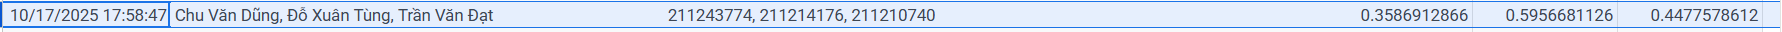

In [6]:
display(Image(filename='Submission/17102025_conf00001.png', embed=True))

## Thử nghiệm conf_thresholds [0.0001, 0.001,0.01,0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

In [16]:
import pandas as pd

DATA_YAML = '/kaggle/working/data_final.yaml'

# Danh sách các ngưỡng confidence cần thử nghiệm
conf_thresholds = [0.0001, 0.001,0.01,0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

# Lưu kết quả
results_list = []

print("Bắt đầu tìm ngưỡng conf tối ưu...")
for conf in conf_thresholds:
    # Chạy validation với ngưỡng conf hiện tại
    metrics = model.val(
        data=DATA_YAML,
        imgsz=640,
        conf=conf,
        iou=0.45,  # Giữ iou cố định
        verbose=False # Tắt bớt log không cần thiết
    )
    
    # Lấy chỉ số Precision và Recall tổng thể (từ 'all' class)
    p = metrics.box.p[0] # Precision
    r = metrics.box.r[0] # Recall
    
    # Tính F1-score
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    
    results_list.append({'conf': conf, 'precision': p, 'recall': r, 'f1': f1})
    print(f"Conf: {conf:.2f} -> P: {p:.3f}, R: {r:.3f}, F1: {f1:.3f}")

# Tạo DataFrame để dễ xem và tìm kết quả tốt nhất
results_df = pd.DataFrame(results_list)

# Tìm dòng có F1-score cao nhất
best_result = results_df.loc[results_df['f1'].idxmax()]

print("\n--- KẾT QUẢ ---")
print(results_df)
print(f"\n🚀 Ngưỡng tối ưu để đạt F1-score cao nhất là:")
print(best_result)

# Gán giá trị tốt nhất để sử dụng sau này
OPTIMAL_CONF = best_result['conf']

Bắt đầu tìm ngưỡng conf tối ưu...
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 539.8±185.8 MB/s, size: 1328.1 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 141.6it/s 19.1s0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.1it/s 1:220.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.586      0.477      0.518      0.308
Speed: 0.3ms preprocess, 24.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Conf: 0.00 -> P: 0.489, R: 0.638, F1: 0.553
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 894.3±323.8 MB/s, size: 1482.0 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 234.3it/s 11.6s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:240.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.586      0.477      0.523      0.317
Speed: 0.3ms preprocess, 26.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2
Conf: 0.00 -> P: 0.489, R: 0.638, F1: 0.553
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 836.9±181.9 MB/s, size: 1634.0 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 234.8it/s 11.6s<0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:260.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.586      0.477      0.537      0.337
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val3
Conf: 0.01 -> P: 0.489, R: 0.638, F1: 0.553
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 879.9±282.0 MB/s, size: 1407.7 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 236.1it/s 11.5s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:250.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.586      0.477      0.563      0.369
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val4
Conf: 0.10 -> P: 0.489, R: 0.638, F1: 0.553
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 763.9±216.4 MB/s, size: 1301.3 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 214.8it/s 12.6s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:240.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145       0.59      0.473      0.567      0.378
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val5
Conf: 0.20 -> P: 0.495, R: 0.637, F1: 0.557
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 640.9±318.8 MB/s, size: 1097.7 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 234.5it/s 11.6s<0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:250.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.614      0.457      0.569      0.381
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val6
Conf: 0.25 -> P: 0.516, R: 0.625, F1: 0.565
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 635.8±413.4 MB/s, size: 1610.6 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 234.9it/s 11.5s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:240.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.636      0.439      0.569      0.383
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val7
Conf: 0.30 -> P: 0.543, R: 0.609, F1: 0.574
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 736.6±220.9 MB/s, size: 1479.5 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 241.2it/s 11.2s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:240.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.684      0.411      0.573      0.391
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val8
Conf: 0.40 -> P: 0.629, R: 0.596, F1: 0.612
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 709.1±145.5 MB/s, size: 1545.3 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 248.3it/s 10.9s0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:230.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.752      0.376      0.581      0.403
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val9
Conf: 0.50 -> P: 0.745, R: 0.568, F1: 0.644

--- KẾT QUẢ ---
     conf  precision    recall        f1
0  0.0001   0.488548  0.637634  0.553223
1  0.0010   0.488548  0.637634  0.553223
2  0.0100   0.488548  0.637634  0.553223
3  0.1000   0.488548  0.637634  0.553223
4  0.2000   0.495397  0.636559  0.557176
5  0.2500   0.515986  0.624731  0.565175
6  0.3000   0.543186  0.608602  0.574037
7  0.4000   0.628831  0.595699  0.611817
8  0.5000   0.744711  0.567742  0.644295

🚀 Ngưỡng tối ưu để đạt F1-score cao nhất là:
conf         0.500000
precision    0.744711
recall       0.567742
f1           0.644295
Name: 8, dtype: float64


## Thử nghiệm conf_thresholds [0.5, 0.6, 0.7]

In [18]:
import pandas as pd

DATA_YAML = '/kaggle/working/data_final.yaml'

# Danh sách các ngưỡng confidence cần thử nghiệm
conf_thresholds = [0.5, 0.6, 0.7]

# Lưu kết quả
results_list = []

print("Bắt đầu tìm ngưỡng conf tối ưu...")
for conf in conf_thresholds:
    # Chạy validation với ngưỡng conf hiện tại
    metrics = model.val(
        data=DATA_YAML,
        imgsz=640,
        conf=conf,
        iou=0.45,  # Giữ iou cố định
        verbose=False # Tắt bớt log không cần thiết
    )
    
    # Lấy chỉ số Precision và Recall tổng thể (từ 'all' class)
    p = metrics.box.p[0] # Precision
    r = metrics.box.r[0] # Recall
    
    # Tính F1-score
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    
    results_list.append({'conf': conf, 'precision': p, 'recall': r, 'f1': f1})
    print(f"Conf: {conf:.2f} -> P: {p:.3f}, R: {r:.3f}, F1: {f1:.3f}")

# Tạo DataFrame để dễ xem và tìm kết quả tốt nhất
results_df = pd.DataFrame(results_list)

# Tìm dòng có F1-score cao nhất
best_result = results_df.loc[results_df['f1'].idxmax()]

print("\n--- KẾT QUẢ ---")
print(results_df)
print(f"\n🚀 Ngưỡng tối ưu để đạt F1-score cao nhất là:")
print(best_result)

# Gán giá trị tốt nhất để sử dụng sau này
OPTIMAL_CONF = best_result['conf']

Bắt đầu tìm ngưỡng conf tối ưu...
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 646.4±313.2 MB/s, size: 1245.2 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 214.6it/s 12.6s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.1it/s 1:220.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.752      0.376      0.581      0.403
Speed: 0.4ms preprocess, 25.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val10
Conf: 0.50 -> P: 0.745, R: 0.568, F1: 0.644
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 565.6±161.9 MB/s, size: 1357.6 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 232.8it/s 11.6s<0.0s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.0it/s 1:230.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.844      0.341      0.599      0.422
Speed: 0.3ms preprocess, 26.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val11
Conf: 0.60 -> P: 0.889, R: 0.533, F1: 0.667
Ultralytics 8.3.216 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 692.8±196.2 MB/s, size: 1576.5 KB)
val: Scanning /kaggle/input/fisheye8k/Fisheye8K/test/labels... 2712 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2712/2712 239.6it/s 11.3s<0.1s
WARNING ⚠️ val: Cache directory /kaggle/input/fisheye8k/Fisheye8K/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 170/170 2.1it/s 1:230.5sss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2712      45145      0.906      0.287      0.597      0.433
Speed: 0.3ms preprocess, 26.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val12
Conf: 0.70 -> P: 0.954, R: 0.442, F1: 0.604

--- KẾT QUẢ ---
   conf  precision    recall        f1
0   0.5   0.744711  0.567742  0.644295
1   0.6   0.888889  0.533333  0.666667
2   0.7   0.953596  0.441935  0.603968

🚀 Ngưỡng tối ưu để đạt F1-score cao nhất là:
conf         0.600000
precision    0.888889
recall       0.533333
f1           0.666667
Name: 1, dtype: float64


In [17]:
# --- Bước 2: Hàm get_image_Id (giữ nguyên) ---
def get_image_Id(img_name):
    base_name = os.path.splitext(img_name)[0]
    sceneList = ['M', 'A', 'E', 'N']
    try:
        cameraIndx = int(base_name.split('_')[0].split('camera')[1])
        sceneIndx = sceneList.index(base_name.split('_')[1])
        frameIndx = int(base_name.split('_')[2])
        imageId = int(str(cameraIndx) + str(sceneIndx) + str(frameIndx))
        return imageId
    except (IndexError, ValueError) as e:
        print(f"Lỗi khi xử lý tên file: {img_name}. Lỗi: {e}")
        return None


# --- Bước 3: Chạy dự đoán và tạo danh sách kết quả ---
dirs = [
    "/kaggle/input/fisheye1keval/images/images",
    "/kaggle/input/fisheye1keval/images1/images1"
]

pred_list = []
print("Bắt đầu quá trình dự đoán...")

for d in dirs:
    print(f"Đang xử lý thư mục: {d}")
    results = model.predict(
        source=d,
        imgsz=640,
        conf=0.0001,
        iou=0.5,
        save=False,
        stream=False,
        verbose=False
    )

    for r in tqdm(results, desc=f"Processing {os.path.basename(d)}"):
        img_name = os.path.basename(r.path)
        image_id = get_image_Id(img_name)
        if image_id is None:
            continue

        boxes_xywh = r.boxes.xywh.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy().astype(int)

        for box, score, cls in zip(boxes_xywh, scores, classes):
            x_center, y_center, w, h = box
            x_min = x_center - w / 2
            y_min = y_center - h / 2

            pred_list.append({
                "image_id": image_id,
                "category_id": int(cls), # ✅ SỬA LỖI: Bỏ "+ 1". ID lớp đã khớp với yêu cầu (0-4).
                "bbox": [
                    round(float(x_min), 2),
                    round(float(y_min), 2),
                    round(float(w), 2),
                    round(float(h), 2)
                ],
                "score": round(float(score), 5)
            })

# --- Bước 4: Lưu kết quả ra file JSON ---
output_path = "/kaggle/working/17102025yolov11_05.json"
print(f"\nĐã xử lý xong. Lưu kết quả vào file: {output_path}")
with open(output_path, 'w') as f:
    json.dump(pred_list, f) # Lưu file không indent để dung lượng nhỏ hơn

print(f"🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.")
print(f"Tổng số đối tượng dự đoán được: {len(pred_list)}")


Bắt đầu quá trình dự đoán...
Đang xử lý thư mục: /kaggle/input/fisheye1keval/images/images


Processing images: 100%|██████████| 431/431 [00:01<00:00, 312.38it/s]


Đang xử lý thư mục: /kaggle/input/fisheye1keval/images1/images1


Processing images1: 100%|██████████| 569/569 [00:01<00:00, 401.01it/s]



Đã xử lý xong. Lưu kết quả vào file: /kaggle/working/17102025yolov11_05.json
🎉 Hoàn tất! File submission.json đã sẵn sàng để nộp.
Tổng số đối tượng dự đoán được: 244892


# Kết quả conf = [0.0001, 0.5, 0.6]


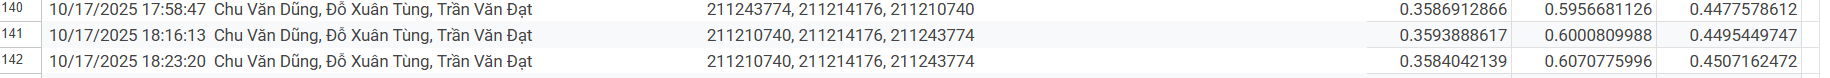

In [5]:
display(Image(filename='Submission/conf_thongKe.png', embed=True))

# Hợp Model

## Tóm tắt các bước

1.  **Khởi tạo (Bước 1-3):**
    * Tải 2 model đã huấn luyện (`model1` là YOLOv8l, `model2` là YOLOv11m) vào bộ nhớ.
    * Quét các thư mục `dirs` để thu thập danh sách tất cả các đường dẫn file ảnh (`.png`) cần dự đoán.

2.  **Xử lý và Ensemble (Bước 4 - Vòng lặp chính):**
    Đây là phần quan trọng nhất, nó lặp qua **từng tấm ảnh một**:
    * **a. Thu thập "Manh mối":** Với một tấm ảnh, nó yêu cầu **cả hai model** dự đoán:
        * Dùng `augment=True` (TTA) để model "nhìn" ảnh từ nhiều góc độ (lật, co giãn) cho chắc chắn.
        * Dùng `conf=0.0001` (siêu thấp) để lấy **tất cả** các phát hiện, kể cả những "manh mối" yếu nhất mà model nghi ngờ.
    * **b. Tổng hợp "Hội đồng":**
        * Tất cả các "manh mối" từ cả hai model được đưa vào hàm `weighted_boxes_fusion` (WBF).
        * `WBF` hoạt động như một giám khảo, gộp các dự đoán trùng lặp và loại bỏ nhiễu để tạo ra một bộ kết quả cuối cùng, đáng tin cậy hơn cho tấm ảnh đó.
    * **c. Định dạng kết quả:** Các tọa độ box cuối cùng được chuyển đổi sang định dạng `[x, y, width, height]` theo yêu cầu của cuộc thi và thêm vào danh sách tổng `pred_list`.

3.  **Lưu kết quả (Bước 5):**
    * Sau khi lặp qua tất cả các ảnh, danh sách `pred_list` (chứa hàng ngàn dự đoán đã được gộp) được lưu lại thành một file JSON duy nhất để nộp bài.



In [2]:
# --- Tạo nội dung YAML mới cho 5 lớp ---
yaml_content_5_classes = """
# Đường dẫn đến thư mục gốc của bộ dữ liệu
path: /kaggle/input/fisheye8k/Fisheye8K/

# Đường dẫn tương đối
train: train/images
val: test/images

# --- Thông tin lớp đã được cập nhật ---
nc: 5
names:
  0: Bus
  1: Bike
  2: Car
  3: Pedestrian
  4: Truck
"""

# Ghi nội dung vào file fisheye8k_aic.yaml
with open('fisheye8k.yaml', 'w') as f:
    f.write(yaml_content_5_classes)

print("Tệp fisheye8k.yaml đã được tạo thành công với 5 lớp.")

Tệp fisheye8k.yaml đã được tạo thành công với 5 lớp.


In [8]:
!pip install ensemble-boxes -q
from ensemble_boxes import weighted_boxes_fusion

In [14]:
import warnings
# Tắt tất cả các cảnh báo thuộc loại UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [15]:
import os
import json
import glob
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion

# --- Bước 1: Tải cả hai model ---
print("Đang tải các model...")
model1 = YOLO('/kaggle/input/yolo8l/other/default/1/best (1).pt')
model2 = YOLO('/kaggle/input/yolov11_final/tensorflow2/default/1/best (5).pt')
models = [model1, model2]
print("Tải model hoàn tất.")


# --- Bước 2: Hàm get_image_Id (giữ nguyên) ---
def get_image_Id(img_name):
    base_name = os.path.splitext(img_name)[0]
    sceneList = ['M', 'A', 'E', 'N']
    try:
        cameraIndx = int(base_name.split('_')[0].split('camera')[1])
        sceneIndx = sceneList.index(base_name.split('_')[1])
        frameIndx = int(base_name.split('_')[2])
        imageId = int(str(cameraIndx) + str(sceneIndx) + str(frameIndx))
        return imageId
    except (IndexError, ValueError) as e:
        print(f"Lỗi khi xử lý tên file: {img_name}. Lỗi: {e}")
        return None


# --- Bước 3: Thu thập tất cả đường dẫn ảnh ---
dirs = [
    "/kaggle/input/fisheye1keval/images/images",
    "/kaggle/input/fisheye1keval/images1/images1"
]
all_image_paths = []
for d in dirs:
    all_image_paths.extend(glob.glob(os.path.join(d, '*.png')))
print(f"Tìm thấy tổng cộng {len(all_image_paths)} ảnh để xử lý.")


# --- Bước 4: Chạy dự đoán, Ensemble và tạo danh sách kết quả ---
pred_list = []
print("Bắt đầu quá trình dự đoán và ensemble với TTA...")

# Cấu hình cho WBF
iou_thr = 0.6
skip_box_thr = 0.0001
weights = [1, 1]

for img_path in tqdm(all_image_paths, desc="Processing images"):
    img_name = os.path.basename(img_path)
    image_id = get_image_Id(img_name)
    if image_id is None:
        continue
    
    all_boxes = []
    all_scores = []
    all_labels = []
    
    h_img, w_img = 0, 0

    # Chạy predict với từng model
    for model in models:
        results = model.predict(
            img_path,
            imgsz=640,
            conf=0.0001,
            verbose=False,
            augment=True
        )[0]
        
        if h_img == 0:
            h_img, w_img = results.orig_shape

        boxes_normalized = results.boxes.xyxyn.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()
        labels = results.boxes.cls.cpu().numpy()
        
        all_boxes.append(boxes_normalized)
        all_scores.append(scores)
        all_labels.append(labels)

    if not any(len(b) > 0 for b in all_boxes):
        continue

    boxes_fused, scores_fused, labels_fused = weighted_boxes_fusion(
        all_boxes, all_scores, all_labels,
        weights=weights,
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr
    )
    
    for box, score, cls in zip(boxes_fused, scores_fused, labels_fused):
        x_min = box[0] * w_img
        y_min = box[1] * h_img
        w = (box[2] - box[0]) * w_img
        h = (box[3] - box[1]) * h_img

        pred_list.append({
            "image_id": image_id,
            "category_id": int(cls),
            "bbox": [
                round(float(x_min), 2),
                round(float(y_min), 2),
                round(float(w), 2),
                round(float(h), 2)
            ],
            "score": round(float(score), 5)
        })

# --- Bước 5: Lưu kết quả ra file JSON (giữ nguyên) ---
output_path = "/kaggle/working/submission_ensemble_tta_conf00001.json"
print(f"\nĐã xử lý xong. Lưu kết quả vào file: {output_path}")
with open(output_path, 'w') as f:
    json.dump(pred_list, f)

print(f"🎉 Hoàn tất! File {os.path.basename(output_path)} đã sẵn sàng để nộp.")
print(f"Tổng số đối tượng dự đoán được: {len(pred_list)}")

Đang tải các model...
Tải model hoàn tất.
Tìm thấy tổng cộng 1000 ảnh để xử lý.
Bắt đầu quá trình dự đoán và ensemble với TTA...


Processing images: 100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]



Đã xử lý xong. Lưu kết quả vào file: /kaggle/working/submission_ensemble_tta_conf00001.json
🎉 Hoàn tất! File submission_ensemble_tta_conf00001.json đã sẵn sàng để nộp.
Tổng số đối tượng dự đoán được: 413038


# Kết quả:

In [4]:
from IPython.display import Image, display
image_path = 'Submission/Final.png'
display(Image(filename=image_path, embed=True))